In [1]:
%load_ext autoreload
%autoreload 2
import volpick.data
import volpick
from obspy.clients.fdsn import Client
from obspy import UTCDateTime,read
import matplotlib.pyplot as plt
import copy
import os
import pandas as pd
import numpy as np
import time
import datetime
from pathlib import Path
from obspy import read
from collections import namedtuple
from volpick.data.utils import freqency_index
import seisbench.data as sbd
from tqdm import tqdm
from matplotlib.ticker import (MultipleLocator,LogLocator, FormatStrFormatter, AutoMinorLocator)

cm = 1 / 2.54
fts=8

In [2]:
def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]

Number of Traces

In [8]:
def dataset_stats(dataset_dir, out_file):
    dataset = sbd.WaveformDataset(
        Path(dataset_dir),
        sampling_rate=100,
        component_order="ZNE",
        dimension_order="NCW",
        cache="full",
    )
    data_eq = dataset.filter(dataset["source_type"] != "noise", inplace=False)
    data_noise = dataset.filter(dataset["source_type"] == "noise", inplace=False)

    trace_with_spikes_index = np.flatnonzero(
        data_eq.metadata["trace_has_spikes"].to_numpy()
    )
    assert len(trace_with_spikes_index) == 0

    assert len(data_eq) + len(data_noise) == len(dataset)
    dataset_lp = dataset.filter(
        (dataset.metadata["source_type"] == "lp"), inplace=False
    )
    dataset_rg = dataset.filter(
        (dataset.metadata["source_type"] != "lp")
        & (dataset.metadata["source_type"] != "noise"),
        inplace=False,
    )
    assert len(dataset_lp) + len(dataset_rg) == len(data_eq)

    # alaska_lp=dataset_lp.filter(dataset_lp.metadata["source_id"].str.contains("alk"),inplace=False)
    alaska_lp = dataset_lp.filter(
        dataset_lp.metadata["trace_chunk"] == "_ak_lp", inplace=False
    )

    # hawaii_lp=dataset_lp.filter((dataset_lp.metadata["source_id"].str[0:6]=="hawaii")&(dataset_lp.metadata["source_id"].str[0:8]!="hawaii2_"),inplace=False)
    # hawaii_lp2=dataset_lp.filter(dataset_lp.metadata["source_id"].str[0:8]=="hawaii2_",inplace=False)
    hawaii_lp2 = dataset_lp.filter(
        dataset_lp.metadata["trace_chunk"] == "_hw12t21_lp", inplace=False
    )
    # japan_lp=dataset_lp.filter((~(dataset_lp.metadata["source_id"].str.contains("alk")))&(~(dataset_lp.metadata["source_id"].str[0:6]=="hawaii")),inplace=False)
    japan_lp = dataset_lp.filter(
        dataset_lp.metadata["trace_chunk"] == "_japan_vol_lp", inplace=False
    )
    assert len(alaska_lp) + len(hawaii_lp2) + len(japan_lp) == len(dataset_lp)

    # alaska_rg=dataset_rg.filter(dataset_rg.metadata["source_id"].str.contains("alk"),inplace=False)
    alaska_rg = dataset_rg.filter(
        dataset_rg.metadata["trace_chunk"] == "_ak_rg", inplace=False
    )
    # hawaii_rg=dataset_rg.filter((dataset_rg.metadata["source_id"].str[0:6]=="hawaii")&(dataset_rg.metadata["source_id"].str[0:8]!="hawaii2_"),inplace=False)
    # hawaii_rg2=dataset_rg.filter(dataset_rg.metadata["source_id"].str[0:8]=="hawaii2_",inplace=False)
    hawaii_rg2 = dataset_rg.filter(
        dataset_rg.metadata["trace_chunk"] == "_hw12t21_rg", inplace=False
    )
    # japan_rg=dataset_rg.filter((~(dataset_rg.metadata["source_id"].str.contains("alk")))&(~(dataset_rg.metadata["source_id"].str[0:6]=="hawaii")),inplace=False)
    japan_rg = dataset_rg.filter(
        dataset_rg.metadata["trace_chunk"] == "_japan_vt", inplace=False
    )
    assert len(alaska_rg) + len(hawaii_rg2) + len(japan_rg) == len(dataset_rg)

    data_stats = {}
    data_stats["Whole dataset"] = [
        len(
            data_eq.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),  # Only use earthquake data to count the number of events
        len(
            data_eq.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            data_eq.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            data_eq.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            dataset
        ),  # Use all the data to count the number of traces (including noise)
        len(dataset.train()),
        len(dataset.dev()),
        len(dataset.test()),
    ]
    data_stats["Earthquake"] = [
        len(
            data_eq.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            data_eq.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            data_eq.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            data_eq.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(data_eq),
        len(data_eq.train()),
        len(data_eq.dev()),
        len(data_eq.test()),
    ]
    data_stats["Noise"] = [
        0,
        0,
        0,
        0,
        len(data_noise),
        len(data_noise.train()),
        len(data_noise.dev()),
        len(data_noise.test()),
    ]
    data_stats["LP earthquakes"] = [
        len(
            dataset_lp.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            dataset_lp.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            dataset_lp.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            dataset_lp.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(dataset_lp),
        len(dataset_lp.train()),
        len(dataset_lp.dev()),
        len(dataset_lp.test()),
    ]
    data_stats["VT earthquakes"] = [
        len(
            dataset_rg.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            dataset_rg.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            dataset_rg.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            dataset_rg.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(dataset_rg),
        len(dataset_rg.train()),
        len(dataset_rg.dev()),
        len(dataset_rg.test()),
    ]
    data_stats["Alaska LPs"] = [
        len(
            alaska_lp.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            alaska_lp.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            alaska_lp.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            alaska_lp.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(alaska_lp),
        len(alaska_lp.train()),
        len(alaska_lp.dev()),
        len(alaska_lp.test()),
    ]
    data_stats["Alaska VTs"] = [
        len(
            alaska_rg.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            alaska_rg.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            alaska_rg.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            alaska_rg.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(alaska_rg),
        len(alaska_rg.train()),
        len(alaska_rg.dev()),
        len(alaska_rg.test()),
    ]

    # data_stats["hawaii_1986_2009_LP"]=[len(hawaii_lp.metadata.drop_duplicates(subset="source_id",keep="first",inplace=False)),
    #                             len(hawaii_lp),len(hawaii_lp.train()),len(hawaii_lp.dev()),len(hawaii_lp.test())]
    data_stats["Hawaii LPs"] = [
        len(
            hawaii_lp2.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            hawaii_lp2.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            hawaii_lp2.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            hawaii_lp2.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(hawaii_lp2),
        len(hawaii_lp2.train()),
        len(hawaii_lp2.dev()),
        len(hawaii_lp2.test()),
    ]
    # data_stats["hawaii_1986_2009_VT"]=[len(hawaii_rg.metadata.drop_duplicates(subset="source_id",keep="first",inplace=False)),
    #                             len(hawaii_rg),len(hawaii_rg.train()),len(hawaii_rg.dev()),len(hawaii_rg.test())]
    data_stats["Hawaii VTs"] = [
        len(
            hawaii_rg2.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            hawaii_rg2.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            hawaii_rg2.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            hawaii_rg2.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(hawaii_rg2),
        len(hawaii_rg2.train()),
        len(hawaii_rg2.dev()),
        len(hawaii_rg2.test()),
    ]
    data_stats["Japan LPs"] = [
        len(
            japan_lp.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            japan_lp.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            japan_lp.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            japan_lp.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(japan_lp),
        len(japan_lp.train()),
        len(japan_lp.dev()),
        len(japan_lp.test()),
    ]
    data_stats["Japan VTs"] = [
        len(
            japan_rg.metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            japan_rg.train().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            japan_rg.dev().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(
            japan_rg.test().metadata.drop_duplicates(
                subset="source_id", keep="first", inplace=False
            )
        ),
        len(japan_rg),
        len(japan_rg.train()),
        len(japan_rg.dev()),
        len(japan_rg.test()),
    ]

    for i in range(4):
        assert (
            data_stats["Alaska LPs"][i]
            + data_stats["Hawaii LPs"][i]
            + data_stats["Japan LPs"][i]
            == data_stats["LP earthquakes"][i]
        )
        assert (
            data_stats["Alaska VTs"][i]
            + data_stats["Hawaii VTs"][i]
            + data_stats["Japan VTs"][i]
            == data_stats["VT earthquakes"][i]
        )

    # assert data_stats["Whole dataset"][0]==data_stats["Whole dataset"][1]+data_stats["Whole dataset"][2]+data_stats["Whole dataset"][3]
    # assert data_stats["LP earthquakes"][0]==data_stats["LP earthquakes"][1]+data_stats["LP earthquakes"][2]+data_stats["LP earthquakes"][3]
    # assert data_stats["VT earthquakes"][0]==data_stats["VT earthquakes"][1]+data_stats["VT earthquakes"][2]+data_stats["VT earthquakes"][3]
    # assert data_stats["Alaska LPs"][0]==data_stats["Alaska LPs"][1]+data_stats["Alaska LPs"][2]+data_stats["Alaska LPs"][3]
    # assert data_stats["Alaska VTs"][0]==data_stats["Alaska VTs"][1]+data_stats["Alaska VTs"][2]+data_stats["Alaska VTs"][3]
    # assert data_stats["Hawaii LPs"][0]==data_stats["Hawaii LPs"][1]+data_stats["Hawaii LPs"][2]+data_stats["Hawaii LPs"][3]
    # assert data_stats["Hawaii VTs"][0]==data_stats["Hawaii VTs"][1]+data_stats["Hawaii VTs"][2]+data_stats["Hawaii VTs"][3]
    # assert data_stats["Japan LPs"][0]==data_stats["Japan LPs"][1]+data_stats["Japan LPs"][2]+data_stats["Japan LPs"][3]
    # assert data_stats["Japan VTs"][0]==data_stats["Japan VTs"][1]+data_stats["Japan VTs"][2]+data_stats["Japan VTs"][3]

    assert (
        data_stats["Whole dataset"][4]
        == data_stats["Whole dataset"][5]
        + data_stats["Whole dataset"][6]
        + data_stats["Whole dataset"][7]
    )
    assert (
        data_stats["LP earthquakes"][4]
        == data_stats["LP earthquakes"][5]
        + data_stats["LP earthquakes"][6]
        + data_stats["LP earthquakes"][7]
    )
    assert (
        data_stats["VT earthquakes"][4]
        == data_stats["VT earthquakes"][5]
        + data_stats["VT earthquakes"][6]
        + data_stats["VT earthquakes"][7]
    )
    assert (
        data_stats["Alaska LPs"][4]
        == data_stats["Alaska LPs"][5]
        + data_stats["Alaska LPs"][6]
        + data_stats["Alaska LPs"][7]
    )
    assert (
        data_stats["Alaska VTs"][4]
        == data_stats["Alaska VTs"][5]
        + data_stats["Alaska VTs"][6]
        + data_stats["Alaska VTs"][7]
    )
    assert (
        data_stats["Hawaii LPs"][4]
        == data_stats["Hawaii LPs"][5]
        + data_stats["Hawaii LPs"][6]
        + data_stats["Hawaii LPs"][7]
    )
    assert (
        data_stats["Hawaii VTs"][4]
        == data_stats["Hawaii VTs"][5]
        + data_stats["Hawaii VTs"][6]
        + data_stats["Hawaii VTs"][7]
    )
    assert (
        data_stats["Japan LPs"][4]
        == data_stats["Japan LPs"][5]
        + data_stats["Japan LPs"][6]
        + data_stats["Japan LPs"][7]
    )
    assert (
        data_stats["Japan VTs"][4]
        == data_stats["Japan VTs"][5]
        + data_stats["Japan VTs"][6]
        + data_stats["Japan VTs"][7]
    )

    df = pd.DataFrame(
        data=data_stats,
        index=[
            "Events",
            "Training events",
            "Validation events",
            "Testing events",
            "Traces",
            "Training traces",
            "Validation traces",
            "Testing traces",
        ],
    )
    df.to_csv(out_file, index=True)
    return df

In [9]:
df = dataset_stats(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis",
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis_stats.csv",
)

KeyboardInterrupt: 

In [10]:
df = pd.read_csv(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis_stats.csv", index_col=0
)

In [68]:
df

,Whole dataset,Earthquake,Noise,LP earthquakes,VT earthquakes,Alaska LPs,Alaska VTs,Hawaii LPs,Hawaii VTs,Japan LPs,Japan VTs
Events,70352,70352,0,33886,36466,15701,15519,2351,2766,15834,18181
Training events,68996,68996,0,33364,35632,15511,15151,2323,2702,15530,17779
Validation events,13346,13346,0,6609,6737,2370,2377,666,653,3573,3707
Testing events,23700,23700,0,11798,11902,4497,4354,1132,1119,6169,6429
Traces,323088,303088,20000,151431,151657,51942,50899,16906,16814,82583,83944
Training traces,270224,257763,12461,128802,128961,44263,43198,14404,14346,70135,71417
Validation traces,17744,15190,2554,7551,7639,2544,2598,811,806,4196,4235
Testing traces,35120,30135,4985,15078,15057,5135,5103,1691,1662,8252,8292


In [11]:
df2 = df.T
df2

,Events,Training events,Validation events,Testing events,Traces,Training traces,Validation traces,Testing traces
Whole dataset,70352,68996,13346,23700,323088,270224,17744,35120
Earthquake,70352,68996,13346,23700,303088,257763,15190,30135
Noise,0,0,0,0,20000,12461,2554,4985
LP earthquakes,33886,33364,6609,11798,151431,128802,7551,15078
VT earthquakes,36466,35632,6737,11902,151657,128961,7639,15057
Alaska LPs,15701,15511,2370,4497,51942,44263,2544,5135
Alaska VTs,15519,15151,2377,4354,50899,43198,2598,5103
Hawaii LPs,2351,2323,666,1132,16906,14404,811,1691
Hawaii VTs,2766,2702,653,1119,16814,14346,806,1662
Japan LPs,15834,15530,3573,6169,82583,70135,4196,8252


In [70]:
df2["Total traces"] = df2.apply(
    lambda x: f"{x['Traces']:,} \\textcolor{{gray}}{{({x['Events']:,})}}", axis=1
)
df2["Training set"] = df2.apply(
    lambda x: f"{x['Training traces']:,} \\textcolor{{gray}}{{({x['Training events']:,})}}",
    axis=1,
)
df2["Validation set"] = df2.apply(
    lambda x: f"{x['Validation traces']:,} \\textcolor{{gray}}{{({x['Validation events']:,})}}",
    axis=1,
)
df2["Test set"] = df2.apply(
    lambda x: f"{x['Testing traces']:,} \\textcolor{{gray}}{{({x['Testing events']:,})}}",
    axis=1,
)

In [71]:
print(df2[["Total traces", "Training set", "Validation set", "Test set"]].to_latex())

\begin{tabular}{lllll}
\toprule
 & Total traces & Training set & Validation set & Test set \\
\midrule
Whole dataset & 323,088 \textcolor{gray}{(70,352)} & 270,224 \textcolor{gray}{(68,996)} & 17,744 \textcolor{gray}{(13,346)} & 35,120 \textcolor{gray}{(23,700)} \\
Earthquake & 303,088 \textcolor{gray}{(70,352)} & 257,763 \textcolor{gray}{(68,996)} & 15,190 \textcolor{gray}{(13,346)} & 30,135 \textcolor{gray}{(23,700)} \\
Noise & 20,000 \textcolor{gray}{(0)} & 12,461 \textcolor{gray}{(0)} & 2,554 \textcolor{gray}{(0)} & 4,985 \textcolor{gray}{(0)} \\
LP earthquakes & 151,431 \textcolor{gray}{(33,886)} & 128,802 \textcolor{gray}{(33,364)} & 7,551 \textcolor{gray}{(6,609)} & 15,078 \textcolor{gray}{(11,798)} \\
VT earthquakes & 151,657 \textcolor{gray}{(36,466)} & 128,961 \textcolor{gray}{(35,632)} & 7,639 \textcolor{gray}{(6,737)} & 15,057 \textcolor{gray}{(11,902)} \\
Alaska LPs & 51,942 \textcolor{gray}{(15,701)} & 44,263 \textcolor{gray}{(15,511)} & 2,544 \textcolor{gray}{(2,370)} & 

# Load dataset

In [12]:
# data_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/alaska"
# dataset = sbd.WaveformDataset(
#     Path(data_path),
#     sampling_rate=100,
#     component_order="ZNE",
#     dimension_order="NCW",
#     cache="full",
# )
# dataset2 = dataset.filter(dataset.metadata["trace_chunk"] == "_ak_rg", inplace=False)
# len(dataset2.train())

In [3]:
data_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis"
dataset = sbd.WaveformDataset(
    Path(data_path),
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)

# japan_tec_lp=sbd.WaveformDataset(
#         Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/japan_tec_lp"),
#         sampling_rate=100,
#         component_order="ZNE",
#         dimension_order="NCW",
#         cache="full",
#     )
# ncedc_lp=sbd.WaveformDataset(
#         Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc"),
#         sampling_rate=100,
#         component_order="ZNE",
#         dimension_order="NCW",
#         cache="full",
#     )

In [4]:
dataset

In [5]:
np.unique(dataset["trace_chunk"])

array(['_ak_lp', '_ak_rg', '_aknoise', '_hw12t21_lp', '_hw12t21_rg',
       '_hwnoise', '_japan_vol_lp', '_japan_vt', '_jpnoise'], dtype=object)

In [6]:
data_eq = dataset.filter(dataset["source_type"] != "noise", inplace=False)
data_noise = dataset.filter(dataset["source_type"] == "noise", inplace=False)

In [17]:
print(f"{len(dataset.train())}, {len(dataset.train())/len(dataset)}")
print(f"{len(dataset.dev())}, {len(dataset.dev())/len(dataset)}")
print(f"{len(dataset.test())}, {len(dataset.test())/len(dataset)}")

270224, 0.836378943198138
17744, 0.054920021789729115
35120, 0.10870103501213292


In [18]:
print(f"{len(data_eq.train())}, {len(data_eq.train())/len(data_eq)}")
print(f"{len(data_eq.dev())}, {len(data_eq.dev())/len(data_eq)}")
print(f"{len(data_eq.test())}, {len(data_eq.test())/len(data_eq)}")

257763, 0.850455973182706
15190, 0.05011745763606609
30135, 0.0994265691812279


In [19]:
print(f"{len(data_noise.train())}, {len(data_noise.train())/len(data_noise)}")
print(f"{len(data_noise.dev())}, {len(data_noise.dev())/len(data_noise)}")
print(f"{len(data_noise.test())}, {len(data_noise.test())/len(data_noise)}")

12461, 0.62305
2554, 0.1277
4985, 0.24925


In [20]:
data_eq.get_sample(303087)[0].shape

(3, 11042)

In [44]:
lengths = []
start_to_p = []
s_to_end = []
for i in tqdm(range(len(data_eq))):
    waveform, meta = data_eq.get_sample(i)
    lengths.append(waveform.shape[-1])
    start_to_p.append(meta["trace_p_arrival_sample"])
    s_to_end.append(waveform.shape[-1] - meta["trace_s_arrival_sample"])

  0%|          | 0/303088 [00:00<?, ?it/s]

100%|██████████| 303088/303088 [01:45<00:00, 2875.24it/s]


(array([1.00000000e+00, 9.99990102e-01, 9.99990102e-01, 9.99990102e-01,
        9.99986803e-01, 9.99983503e-01, 9.99973605e-01, 9.99947210e-01,
        9.99930713e-01, 9.99901019e-01, 9.99854828e-01, 9.99808636e-01,
        9.99802038e-01, 9.77198041e-01, 8.51369899e-01, 7.18352426e-01,
        6.29328776e-01, 5.67967059e-01, 5.27572850e-01, 5.02893549e-01,
        4.88772238e-01, 4.79421818e-01, 4.73862377e-01, 4.70378240e-01,
        4.67778335e-01, 4.65937286e-01, 4.65142137e-01, 4.64564747e-01,
        4.64013752e-01, 4.63512247e-01, 4.63152616e-01, 4.62796284e-01,
        4.62522436e-01, 4.62232091e-01, 4.61968141e-01, 4.61723988e-01,
        4.61400649e-01, 4.61044317e-01, 4.60711081e-01, 4.60417437e-01,
        7.58855514e-05, 5.93886924e-05, 4.28918334e-05, 3.29937180e-05,
        1.64968590e-05, 6.59874360e-06, 6.59874360e-06, 3.29937180e-06,
        3.29937180e-06, 3.29937180e-06]),
 array([ 128.  ,  275.62,  423.24,  570.86,  718.48,  866.1 , 1013.72,
        1161.34, 1308.9

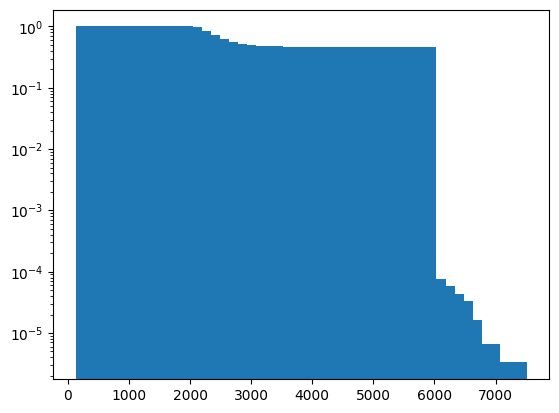

In [55]:
plt.hist(start_to_p, cumulative=-1, bins=50, density=True, log=True)

(array([1.00000000e+00, 9.99990102e-01, 9.99967006e-01, 9.99957108e-01,
        9.99943911e-01, 9.99937312e-01, 9.99917516e-01, 9.99904318e-01,
        9.99874624e-01, 9.99821834e-01, 9.99765745e-01, 9.96410283e-01,
        9.93331970e-01, 9.89098876e-01, 9.84549042e-01, 9.80068495e-01,
        9.76287415e-01, 9.73370770e-01, 9.71133796e-01, 9.69282849e-01,
        9.67586971e-01, 9.66263923e-01, 9.65326902e-01, 9.64432772e-01,
        9.63670617e-01, 9.62783086e-01, 9.61918651e-01, 9.60879349e-01,
        9.59467217e-01, 9.57801035e-01, 9.55729029e-01, 1.66054083e-01,
        1.63506968e-01, 1.60517737e-01, 1.56419918e-01, 1.49814575e-01,
        1.42974978e-01, 1.35541493e-01, 1.26725571e-01, 1.15220662e-01,
        1.02224436e-01, 8.61597952e-02, 6.88446920e-02, 5.01438526e-02,
        3.33995407e-02, 2.16636752e-02, 1.32040859e-02, 6.11373594e-03,
        1.94003062e-03, 2.54051629e-04]),
 array([  12.  ,  210.04,  408.08,  606.12,  804.16, 1002.2 , 1200.24,
        1398.28, 1596.3

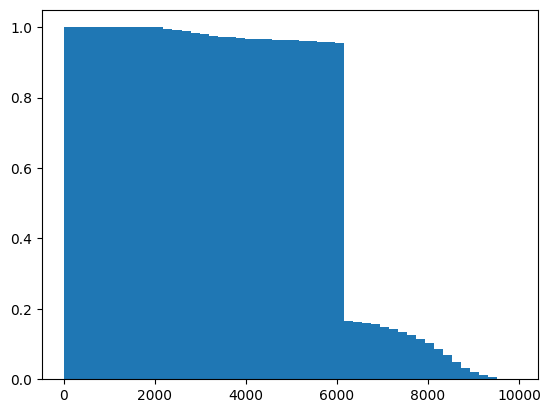

In [50]:
plt.hist(s_to_end, cumulative=-1, bins=50, density=True)

In [34]:

for i in tqdm(range(len(data_eq))):
    # lengths.append(data_eq.get_waveforms(i).shape[-1])
    start_to_p.append(data_eq.metadata.iloc[0]["trace_p_arrival_sample"])
    s_to_end.append(lengths[i] - data_eq.metadata.iloc[0]["trace_s_arrival_sample"])

100%|██████████| 303088/303088 [00:33<00:00, 9030.34it/s]


In [36]:
min(s_to_end)

-3366.0

(array([2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        5.0000e+00, 8.0000e+00, 1.2000e+01, 1.0000e+01, 1.4750e+03,
        1.2653e+04, 2.7401e+04, 3.5147e+04, 2.3746e+04, 1.8056e+04,
        1.2813e+04, 9.1270e+03, 7.1380e+03, 4.2850e+03, 3.0590e+03,
        2.3950e+03, 1.6030e+03, 1.0780e+03, 9.0900e+02, 6.6600e+02,
        4.9500e+02, 3.0700e+02, 2.0800e+02, 1.9300e+02, 1.8300e+02,
        3.7576e+04, 6.4838e+04, 2.1378e+04, 1.0747e+04, 2.8730e+03,
        1.3080e+03, 5.9400e+02, 3.8600e+02, 1.7800e+02, 1.0300e+02,
        7.2000e+01, 2.2000e+01, 1.2000e+01, 7.0000e+00, 4.0000e+00,
        2.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 294.  ,  481.88,  669.76,  857.64, 1045.52, 1233.4 , 1421.28,
        1609.16, 1797.04, 1984.92, 2172.8 , 2360.68, 2548.56, 2736.44,
        2924.32, 3112.2 , 3300.08, 3487.96, 3675.84, 3863.72, 4051.6 ,
        4239.48, 4427.36, 4615.24, 4803.12, 4991.  , 5178.88, 5366.76,
        5554.64, 5742.52, 5930.4 ,

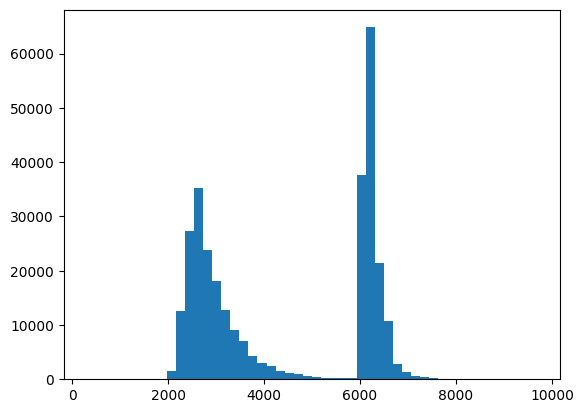

In [37]:
plt.hist(data_eq.metadata["trace_s_arrival_sample"], bins=50)

# Components

In [ ]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")
meta_files = [x.name for x in data_path.iterdir() if x.name.endswith(".csv")]

In [ ]:
meta_files

['metadata_hwnoise.csv',
 'metadata_hw12t21_lp.csv',
 'metadata_jpnoise.csv',
 'metadata_japan_vt.csv',
 'metadata_ak_rg.csv',
 'metadata_hw12t21_rg.csv',
 'metadata_aknoise.csv',
 'metadata_ak_lp.csv',
 'metadata_japan_vol_lp.csv']

In [197]:
def get_comp_stats(data_dir, meta_file):
    stat_dict = {1: 0, 2: 0, 3: 0}
    meta = pd.read_csv(meta_file)
    # mseed_fnames=meta.apply(lambda x: x["trace_name_original"] if pd.notna(x["trace_name_original"]) else x["trace_name"],axis=1)
    # for mseed_file in tqdm(mseed_fnames):
    for i in tqdm(range(len(meta))):
        if pd.notna(meta.iloc[i]["trace_name_original"]):
            mseed_file = meta.iloc[i]["trace_name_original"]
        else:
            mseed_file = meta.iloc[i]["trace_name"]

        try:
            st = read(data_dir / mseed_file)
        except TypeError as e:
            print(mseed_file)
            raise e
        component_list = set([tr.id for tr in st])
        # assert len(st)>0 and len(st)<=3
        n_cp = len(component_list)  # number of components
        stat_dict[n_cp] = stat_dict[n_cp] + 1
    return stat_dict

In [ ]:
hwnoise_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Noise/hw_mseed"),
    data_path / "metadata_hwnoise.csv",
)

jpnoise_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Noise/jp_mseed12"),
    data_path / "metadata_jpnoise.csv",
)

aknoise_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Noise/ak_mseed"),
    data_path / "metadata_aknoise.csv",
)

ak_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Alaska/mseed"),
    data_path / "metadata_ak_lp.csv",
)
ak_rg_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Alaska/mseed"),
    data_path / "metadata_ak_rg.csv",
)

hw12t21_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/hawaii2012to2021/mseed"),
    data_path / "metadata_hw12t21_lp.csv",
)
hw12t21_rg_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/hawaii2012to2021/mseed"),
    data_path / "metadata_hw12t21_rg.csv",
)

japan_vol_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Japan/Vol_lp/mseed"),
    data_path / "metadata_japan_vol_lp.csv",
)
japan_vt_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Japan/VT/mseed"),
    data_path / "metadata_japan_vt.csv",
)

  0%|          | 0/5198 [00:00<?, ?it/s]

100%|██████████| 83944/83944 [25:47<00:00, 54.24it/s] 


In [ ]:
comp_stats_list = [
    hwnoise_comp_stat,
    jpnoise_comp_stat,
    aknoise_comp_stat,
    ak_lp_comp_stat,
    ak_rg_comp_stat,
    hw12t21_lp_comp_stat,
    hw12t21_rg_comp_stat,
    japan_vol_lp_comp_stat,
    japan_vt_comp_stat,
]

In [ ]:
comp_stats_list

[{'hwnoise': {'1': 1207, '2': 2, '3': 3989}},
 {'jpnoise': {'1': 21, '2': 14, '3': 7550}},
 {'aknoise': {'1': 5692, '2': 32, '3': 1493}},
 {'ak_lp': {'1': 34214, '2': 43, '3': 17685}},
 {'ak_rg': {'1': 31337, '2': 218, '3': 19344}},
 {'hw12t21_lp': {'1': 560, '2': 18, '3': 16328}},
 {'hw12t21_rg': {'1': 693, '2': 26, '3': 16095}},
 {'japan_vol_lp': {'1': 17, '2': 1056, '3': 81510}},
 {'japan_vt': {'1': 59, '2': 116, '3': 83769}}]

In [ ]:
comp_stats_df = pd.DataFrame.from_records(
    comp_stats_list,
    index=[
        "hwnoise",
        "jpnoise",
        "aknoise",
        "ak_lp",
        "ak_rg",
        "hw12t21_lp",
        "hw12t21_rg",
        "japan_vol_lp",
        "japan_vt",
    ],
)
comp_stats_df.to_csv(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis_component_stats.csv"
)

In [ ]:
comp_stats_df.loc["hwnoise"]

1    1207
2       2
3    3989
Name: hwnoise, dtype: int64

In [10]:
comp_stats_df

,1,2,3
hwnoise,1207,2,3989
jpnoise,21,14,7550
aknoise,5692,32,1493
ak_lp,34214,43,17685
ak_rg,31337,218,19344
hw12t21_lp,560,18,16328
hw12t21_rg,693,26,16095
japan_vol_lp,17,1056,81510
japan_vt,59,116,83769


In [22]:
comp_stats_df = pd.read_csv(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis_component_stats.csv",
    index_col=0,
)
comp_stats_list = [comp_stats_df.loc[x].to_dict() for x in comp_stats_df.index]
comp_stats = {1: 0, 2: 0, 3: 0}
for i in range(len(comp_stats_list)):
    print(comp_stats_list[i])
    for n_comp, count in comp_stats_list[i].items():
        comp_stats[int(n_comp)] = comp_stats[int(n_comp)] + count

{'1': 1207, '2': 2, '3': 3989}
{'1': 21, '2': 14, '3': 7550}
{'1': 5692, '2': 32, '3': 1493}
{'1': 34214, '2': 43, '3': 17685}
{'1': 31337, '2': 218, '3': 19344}
{'1': 560, '2': 18, '3': 16328}
{'1': 693, '2': 26, '3': 16095}
{'1': 17, '2': 1056, '3': 81510}
{'1': 59, '2': 116, '3': 83769}
{'1': 3353, '2': 65, '3': 1423}
{'1': 867, '2': 29, '3': 3945}
{'1': 0, '2': 0, '3': 6224}


In [11]:
comp_stats

{1: 73800, 2: 1525, 3: 247763}

['1 components', '2 components', '3 components']
[78020, 1619, 259355]


([<matplotlib.patches.Wedge at 0x7f3420638c40>,
 [Text(0.8247757096203628, 0.7278358529367916, '1 components'),
  Text(0.120436302038059, 1.0933869841695563, '2 components'),
  Text(-0.8137629319866083, -0.7401282932874266, '3 components')],
 [Text(0.5998368797239002, 0.5293351657722121, '23.015%'),
  Text(0.08759003784586109, 0.7951905339414955, '0.478%'),
  Text(-0.5918275868993516, -0.5382751223908556, '76.507%')])

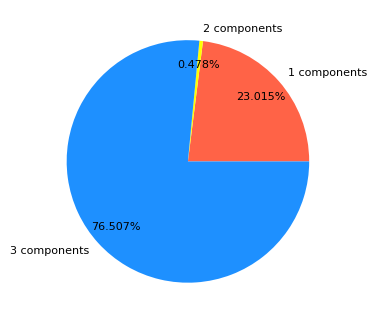

In [23]:
cm = 1 / 2.54
fig, ax = plt.subplots(1, 1, figsize=(12 * cm, 10 * cm))
labels = []
counts = []
for label, count in comp_stats.items():
    labels.append(f"{label} components")
    counts.append(count)
print(labels)
print(counts)
fts = 8
ax.pie(
    counts,
    labels=labels,
    autopct="%1.3f%%",
    colors=["tomato", "yellow", "dodgerblue"],
    textprops={"fontsize": fts},
    #    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    pctdistance=0.8,
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/components_pie_chart.pdf",
    dpi=300,
    bbox_inches="tight",
)

In [15]:
sum(counts)

323088

# SNR

In [108]:
np.unique(data_eq["trace_chunk"])

array(['_ak_lp', '_ak_rg', '_hw12t21_lp', '_hw12t21_rg', '_japan_vol_lp',
       '_japan_vt'], dtype=object)

In [109]:
data_eq.metadata["trace_snr_db"].iloc[0]

'[8.089339552166457, nan, nan]'

In [110]:
def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00,
        8.0000e+00, 6.0000e+00, 9.0000e+00, 9.0000e+00, 1.5000e+01,
        4.0000e+01, 1.5000e+02, 6.4600e+02, 2.9460e+03, 9.6360e+03,
        2.1037e+04, 2.9069e+04, 3.1029e+04, 3.0346e+04, 2.8967e+04,
        2.7065e+04, 2.4591e+04, 2.0985e+04, 1.7170e+04, 1.3613e+04,
        1.0360e+04, 7.8720e+03, 5.9710e+03, 4.6680e+03, 3.6520e+03,
        2.9160e+03, 2.3980e+03, 1.8200e+03, 1.5000e+03, 1.1700e+03,
        9.3200e+02, 6.6400e+02, 5.1300e+02, 3.4600e+02, 2.3900e+02,
        1.7200e+02, 1.5000e+02, 9.4000e+01, 6.8000e+01, 5.9000e+01,
        3.7000e+01, 3.9000e+01, 2.2000e+01, 2.0000e+01, 1.7000e+01,
        1.0000e+01, 1.1000e+01, 6.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.00

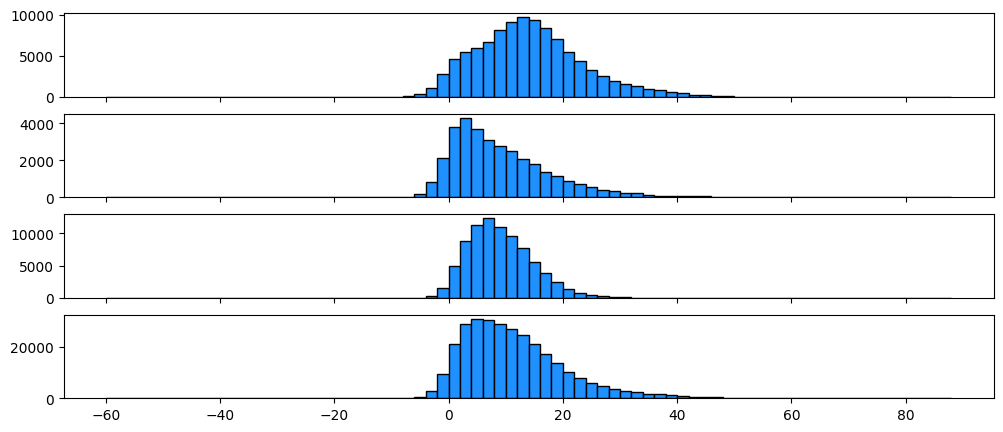

In [111]:
bins = np.arange(-60, 90, 2)
bins
total_snr = data_eq.metadata["trace_mean_snr_db"]
japan_snr = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_japan_vol_lp")
    | (data_eq.metadata["trace_chunk"] == "_japan_vol_lp")
]["trace_mean_snr_db"]
hawaii_snr = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_hw12t21_lp")
    | (data_eq.metadata["trace_chunk"] == "_hw12t21_rg")
]["trace_mean_snr_db"]
alaska_snr = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_ak_lp")
    | (data_eq.metadata["trace_chunk"] == "_ak_rg")
]["trace_mean_snr_db"]
fig, axs = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
axs[0].hist(alaska_snr, bins=bins, color="dodgerblue", edgecolor="black")
axs[1].hist(hawaii_snr, bins=bins, color="dodgerblue", edgecolor="black")
axs[2].hist(japan_snr, bins=bins, color="dodgerblue", edgecolor="black")
axs[3].hist(total_snr, bins=bins, color="dodgerblue", edgecolor="black")

In [112]:
np.unique(data_eq["trace_chunk"])

array(['_ak_lp', '_ak_rg', '_hw12t21_lp', '_hw12t21_rg', '_japan_vol_lp',
       '_japan_vt'], dtype=object)

In [113]:
def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]


total_snr_zne = data_eq.metadata["trace_snr_db"].apply(str2list)
total_snr_zne_lp = data_eq.metadata[data_eq.metadata["source_type"] == "lp"][
    "trace_snr_db"
].apply(str2list)
total_snr_zne_vt = data_eq.metadata[data_eq.metadata["source_type"] != "lp"][
    "trace_snr_db"
].apply(str2list)

japan_snr_zne = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_japan_vol_lp")
    | (data_eq.metadata["trace_chunk"] == "_japan_vt")
]["trace_snr_db"].apply(str2list)

japan_snr_zne_lp = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_japan_vol_lp")
]["trace_snr_db"].apply(str2list)
japan_snr_zne_vt = data_eq.metadata[(data_eq.metadata["trace_chunk"] == "_japan_vt")][
    "trace_snr_db"
].apply(str2list)

hawaii_snr_zne = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_hw12t21_lp")
    | (data_eq.metadata["trace_chunk"] == "_hw12t21_rg")
]["trace_snr_db"].apply(str2list)
hawaii_snr_zne_lp = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_hw12t21_lp")
]["trace_snr_db"].apply(str2list)
hawaii_snr_zne_vt = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_hw12t21_rg")
]["trace_snr_db"].apply(str2list)

alaska_snr_zne = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_ak_lp")
    | (data_eq.metadata["trace_chunk"] == "_ak_rg")
]["trace_snr_db"].apply(str2list)

alaska_snr_zne_lp = data_eq.metadata[data_eq.metadata["trace_chunk"] == "_ak_lp"][
    "trace_snr_db"
].apply(str2list)
alaska_snr_zne_vt = data_eq.metadata[(data_eq.metadata["trace_chunk"] == "_ak_rg")][
    "trace_snr_db"
].apply(str2list)

In [114]:
# print(np.min(total_snr_zne),np.max(total_snr_zne))
snr_mean = total_snr_zne.apply(np.mean)
print(np.min(snr_mean), np.max(snr_mean))

-60.10486204865622 85.16601837881369


In [115]:
alaska_snr_zne

0                             [8.089339552166457, nan, nan]
1         [12.314789945589508, 16.11889869690067, 9.4106...
2         [19.0045297959485, 12.128193929878003, 14.4137...
3         [16.50637382103238, 5.883320034987504, 12.7329...
4         [22.719516448098705, 10.604068714832064, 16.20...
                                ...                        
102836    [6.874830461274595, -2.046546552722889, -11.12...
102837                        [24.10640603349033, nan, nan]
102838                        [21.88252622274184, nan, nan]
102839                        [4.714262319400774, nan, nan]
102840                       [5.8104577261665415, nan, nan]
Name: trace_snr_db, Length: 102841, dtype: object

In [116]:
# snr_j = alaska_snr_zne.apply(np.nanmean)

In [117]:
len(alaska_snr_zne)

102841

An example of NaN SNR of a 3-component earthquake waveform

Reason: Although both P and S picks are avaible, there is a gap immediately after the S pick or there is a gap before the P pick for some components. 

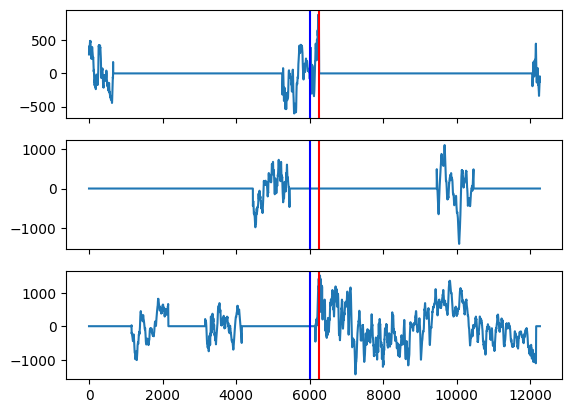

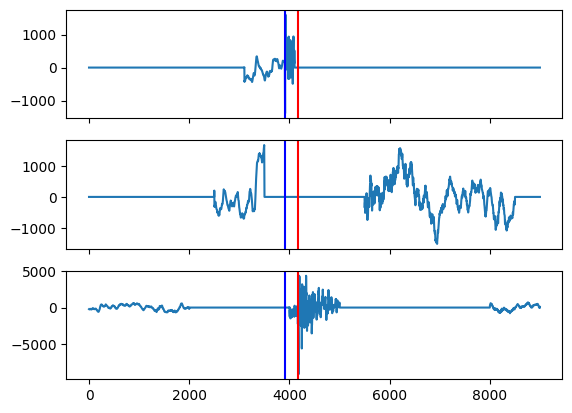

In [118]:
akmeta = data_eq.metadata[
    (data_eq.metadata["trace_chunk"] == "_ak_lp")
    | (data_eq.metadata["trace_chunk"] == "_ak_rg")
]
xx = akmeta[
    akmeta["trace_snr_db"].apply(str2list).apply(lambda x: np.all(pd.isna(np.array(x))))
]
alaska_nosnr_data = data_eq.filter(
    data_eq["trace_name_original"].isin(xx["trace_name_original"]), inplace=False
)

for idx in range(2):
    waveforms = alaska_nosnr_data.get_waveforms(idx)
    fig, axs = plt.subplots(3, 1, sharex=True)
    for i in range(3):
        ax = axs[i]
        ax.plot(waveforms[i])
        ax.axvline(
            alaska_nosnr_data.metadata.iloc[idx]["trace_p_arrival_sample"], color="blue"
        )
        ax.axvline(
            alaska_nosnr_data.metadata.iloc[idx]["trace_s_arrival_sample"], color="red"
        )

In [119]:
pd.isna(np.array([np.nan, 1]))

array([ True, False])

In [120]:
snr_j = snr_j[pd.notna(snr_j)]
len(snr_j)

6224

In [121]:
alaska_snr_zne.apply(np.nanmean)

/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/pandas/core/apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(


0          8.089340
1         12.614768
2         15.182152
3         11.707556
4         16.510555
            ...    
102836    -2.098538
102837    24.106406
102838    21.882526
102839     4.714262
102840     5.810458
Name: trace_snr_db, Length: 102841, dtype: float64

In [122]:
len(alaska_snr_zne)

102841

In [123]:
len(alaska_snr_zne[alaska_snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))])

102839

In [124]:
# len(snr_lp_j) + len(snr_vt_j) == len(snr_j)

Plot SNRs

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


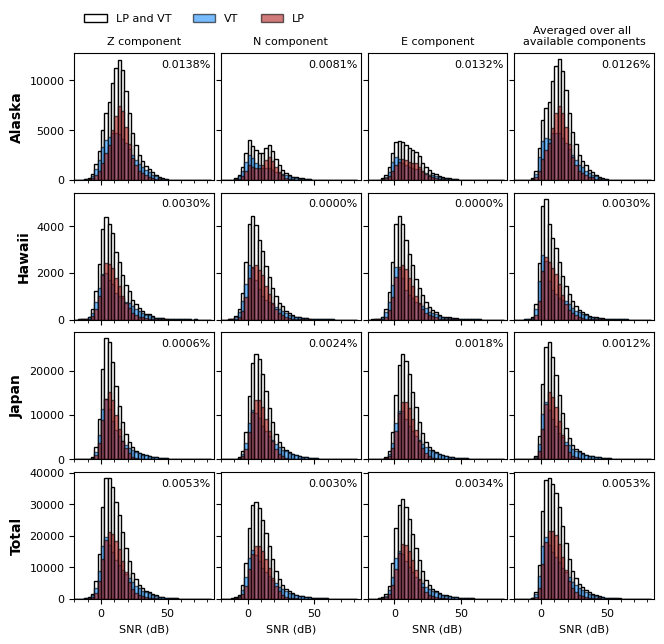

In [125]:
snr_up_b = 85
snr_lw_b = -20
bins = np.arange(snr_lw_b, snr_up_b, 2.5)
fig, axs = plt.subplots(4, 4, figsize=(19 * cm, 18 * cm), sharex=True, sharey="row")
plt.subplots_adjust(hspace=0.1, wspace=0.05)
fts = 8
for i, (snr_zne, snr_zne_lp, snr_zne_vt, label) in enumerate(
    zip(
        [alaska_snr_zne, hawaii_snr_zne, japan_snr_zne, total_snr_zne],
        [alaska_snr_zne_lp, hawaii_snr_zne_lp, japan_snr_zne_lp, total_snr_zne_lp],
        [alaska_snr_zne_vt, hawaii_snr_zne_vt, japan_snr_zne_vt, total_snr_zne_vt],
        ["Alaska", "Hawaii", "Japan", "Total"],
    )
):
    # snr_z=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    # snr_n=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    # snr_e=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    component_order = ["Z", "N", "E"]
    na_snrs = snr_zne[snr_zne.apply(lambda x: np.all(pd.isna(np.array(x))))]
    # print(len(na_snrs))
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr_zne_lp = snr_zne_lp[
        snr_zne_lp.apply(lambda x: not np.all(pd.isna(np.array(x))))
    ]
    snr_zne_vt = snr_zne_vt[
        snr_zne_vt.apply(lambda x: not np.all(pd.isna(np.array(x))))
    ]
    for j in range(4):
        print(i, j)
        if j < 3:
            snr_j = snr_zne.apply(lambda x: x[j])
            snr_j = snr_j[pd.notna(snr_j)]

            snr_lp_j = snr_zne_lp.apply(lambda x: x[j])
            snr_lp_j = snr_lp_j[pd.notna(snr_lp_j)]

            snr_vt_j = snr_zne_vt.apply(lambda x: x[j])
            snr_vt_j = snr_vt_j[pd.notna(snr_vt_j)]
        else:
            snr_j = snr_zne.apply(np.nanmean)
            snr_j = snr_j[pd.notna(snr_j)]

            snr_lp_j = snr_zne_lp.apply(np.nanmean)
            snr_lp_j = snr_lp_j[pd.notna(snr_lp_j)]

            snr_vt_j = snr_zne_vt.apply(np.nanmean)
            snr_vt_j = snr_vt_j[pd.notna(snr_vt_j)]

        # print(np.min(snr_j),np.max(snr_j))
        axs[i][j].hist(
            snr_j,
            bins=bins,
            color="white",
            edgecolor="black",
            log=False,
            label="LP and VT",
        )

        axs[i][j].hist(
            snr_vt_j,
            bins=bins,
            color="dodgerblue",
            edgecolor="black",
            log=False,
            alpha=0.6,
            label="VT",
        )
        axs[i][j].hist(
            snr_lp_j,
            bins=bins,
            color="firebrick",
            edgecolor="black",
            log=False,
            alpha=0.6,
            label="LP",
        )

        # axs[i][j].axvline(np.median(snr_j),color="dodgerblue")
        axs[i][j].tick_params(labelsize=fts)
        axs[i][j].xaxis.set_minor_locator(MultipleLocator(10))
        out = len(snr_j[(snr_j > snr_up_b) | (snr_j < snr_lw_b)]) / len(snr_j)
        # if j==2 and (i==1 or i==3):
        #     print(i,len(snr_j[(snr_j>snr_up_b)|(snr_j<snr_lw_b)]))
        # if i==1:
        #     print(j,"len",len(snr_j))
        # print(f"{out:e}")
        axs[i][j].text(
            0.975,
            0.95,
            f"""{out*100:>6.4f}%""",
            verticalalignment="top",
            horizontalalignment="right",
            transform=axs[i][j].transAxes,
            fontsize=fts,
        )
        axs[i][j].set_xlim(snr_lw_b, snr_up_b)

    for j in range(3):
        axs[-1][j].set_xlabel(f"SNR (dB)", fontsize=fts)
        axs[0][j].set_title(f"{component_order[j]} component", fontsize=fts)
    axs[-1][3].set_xlabel(f"SNR (dB)", fontsize=fts)
    axs[0][3].set_title(f"Averaged over all \navailable components", fontsize=fts)
    axs[i][0].set_ylabel(label, fontsize=fts + 2, weight="bold")
# axs[0].hist(alaska_snr,bins=bins,color="dodgerblue", edgecolor="black");
# axs[1].hist(hawaii_snr,bins=bins,color="dodgerblue", edgecolor="black");
# axs[2].hist(japan_snr,bins=bins,color="dodgerblue", edgecolor="black");
# axs[3].hist(total_snr,bins=bins,color="dodgerblue", edgecolor="black");
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 1.15, 1.5, 0.25),
    frameon=False,
    fontsize=fts,
    ncols=3,
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/SNR.pdf", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/SNR.jpg", dpi=600, bbox_inches="tight"
)

In [ ]:
total_snr_zne.apply(lambda x: x[0])

0          8.089340
1         12.314790
2         19.004530
3         16.506374
4         22.719516
            ...    
315498     8.642836
315499    10.383165
315500    17.761843
315501    11.823561
315502    11.087434
Name: trace_snr_db, Length: 303088, dtype: float64

# Frequency index

In [36]:
freq_indices = dataset.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()

lp_metadata = dataset.metadata[dataset.metadata["source_type"] == "lp"]
rg_metadata = dataset.metadata[dataset.metadata["source_type"] != "lp"]
print(len(lp_metadata))
print(len(rg_metadata))

# source id of lp events and frequency indexes of lp events
freq_indices_lp = lp_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()
freq_indices_rg = rg_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()

151431
171657


max nan
min nan


Text(0, 0.5, 'Frequency density')

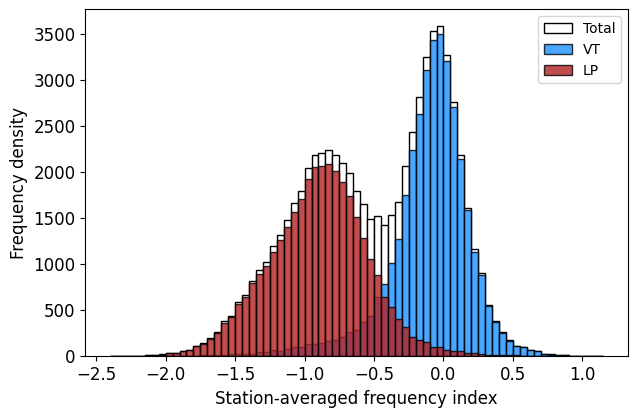

In [37]:
print(f"max {np.max(freq_indices)}")
print(f"min {np.min(freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))

bins = np.arange(-2.4, 1.2, 0.05)
plt.hist(
    freq_indices, bins, density=False, color="white", edgecolor="black", label="Total"
)
plt.hist(
    freq_indices_rg,
    bins,
    density=False,
    color="dodgerblue",
    edgecolor="black",
    alpha=0.8,
    label="VT",
)
plt.hist(
    freq_indices_lp,
    bins,
    density=False,
    color="firebrick",
    edgecolor="black",
    alpha=0.8,
    label="LP",
)

plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-averaged frequency index", fontsize=fts)
plt.ylabel("Frequency density", fontsize=fts)
# plt.savefig(root_save_path/"FI_averaged_over_stations.jpg", bbox_inches="tight", dpi=600)
# plt.savefig(root_save_path/"FI_averaged_over_stations.pdf", bbox_inches="tight", dpi=600)

In [38]:
freq_indices_df = dataset.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"]
freq_indices = freq_indices_df.to_numpy()

lp_metadata = dataset.metadata[dataset.metadata["source_type"] == "lp"]
rg_metadata = dataset.metadata[dataset.metadata["source_type"] != "lp"]
print(len(lp_metadata))
print(len(rg_metadata))

# source id of lp events and frequency indexes of lp events
freq_indices_lp = lp_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()
freq_indices_rg = rg_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()

151431
171657


In [39]:
np.unique(dataset["trace_chunk"])

array(['_ak_lp', '_ak_rg', '_aknoise', '_hw12t21_lp', '_hw12t21_rg',
       '_hwnoise', '_japan_vol_lp', '_japan_vt', '_jpnoise'], dtype=object)

In [40]:
freq_indices_df = dataset.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)

In [ ]:
# freq_indices_lp=freq_indices_df[freq_indices_df["source_type"]=="lp"]["source_frequency_index"]
# freq_indices_rg=freq_indices_df[freq_indices_df["source_type"]!="lp"]["source_frequency_index"]
# print(len(freq_indices_lp))
# print(len(freq_indices_rg))

33886
36467


## Event-based frequency index

-4.667948492281088 1.6273361702316074
1.281230e-04
-2.448048345595826 1.3477482530379676
0.000000e+00
-2.045824666156581 1.1955126312986517
0.000000e+00
-4.667948492281088 1.6273361702316074
5.685614e-05


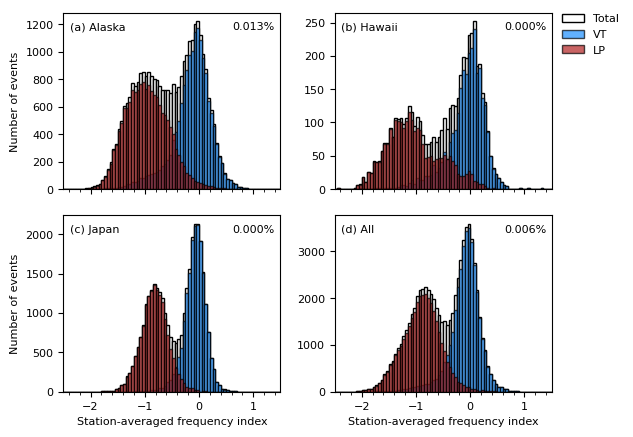

In [32]:
freq_indices_df = dataset.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)
fts = 8
fig, axs = plt.subplots(2, 2, figsize=(16 * cm, 12.5 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
up_b = 1.5
lw_b = -2.5
bins = np.arange(lw_b, up_b + 0.01, 0.05)
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
for i in range(4):
    ax = axs.flat[i]
    label = labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = freq_indices_df[
            (freq_indices_df["trace_chunk"] == chunks[0])
            | (freq_indices_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = freq_indices_df
    freq_indices = current_df["source_frequency_index"]
    print(min(freq_indices), max(freq_indices))
    # freq_indices=freq_indices_df[(freq_indices_df["trace_chunk"]==chunks[0])|(freq_indices_df["trace_chunk"]==chunks[1])]["source_frequency_index"]
    freq_indices_lp = current_df[current_df["source_type"] == "lp"][
        "source_frequency_index"
    ]
    freq_indices_rg = current_df[current_df["source_type"] != "lp"][
        "source_frequency_index"
    ]
    ax.hist(
        freq_indices,
        bins,
        density=False,
        color="white",
        edgecolor="black",
        label="Total",
    )
    ax.hist(
        freq_indices_rg,
        bins,
        density=False,
        color="dodgerblue",
        edgecolor="black",
        alpha=0.7,
        label="VT",
    )
    ax.hist(
        freq_indices_lp,
        bins,
        density=False,
        color="firebrick",
        edgecolor="black",
        alpha=0.7,
        label="LP",
    )
    ax.text(
        0.03,
        0.95,
        label,
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    out = len(freq_indices[(freq_indices > up_b) | (freq_indices < lw_b)]) / len(
        freq_indices
    )
    print(f"{out:e}")
    ax.text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.set_xlim([lw_b, up_b])
# freq_indices=freq_indices_df["source_frequency_index"]
# freq_indices_lp=freq_indices_df[freq_indices_df["source_type"]=="lp"]["source_frequency_index"]
# freq_indices_rg=freq_indices_df[freq_indices_df["source_type"]!="lp"]["source_frequency_index"]
# axs[1][1].hist(freq_indices,bins,density=False, color="white", edgecolor="black",label="Total");
# axs[1][1].hist(freq_indices_rg, bins,density=False, color="dodgerblue", edgecolor="black", alpha=0.8, label="VT");
# axs[1][1].hist(freq_indices_lp, bins,density=False, color="firebrick", edgecolor="black", alpha=0.8, label="LP");
# axs[1][1].text(
#             0.03,
#             0.95,
#             "(d) All",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=axs[1][1].transAxes,
#             fontsize=fts,
#             # weight="bold",
#             color="black",
#         )
# axs[1][1].tick_params(labelsize=10)
# axs[1][1].xaxis.set_minor_locator(MultipleLocator(0.2))
axs[0][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_xlabel("Station-averaged frequency index", fontsize=fts)
axs[1][1].set_xlabel("Station-averaged frequency index", fontsize=fts)

axs[0][1].legend(
    loc="upper left", bbox_to_anchor=(1.0, 0.55, 0.2, 0.5), frameon=False, fontsize=fts
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/event_FI_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/event_FI_histogram.jpg",
    dpi=300,
    bbox_inches="tight",
)

1.304546e-04
0.000000e+00
0.000000e+00
0.000000e+00
0.000000e+00
0.000000e+00
0.000000e+00
0.000000e+00
0.000000e+00
5.797354e-05
0.000000e+00
0.000000e+00


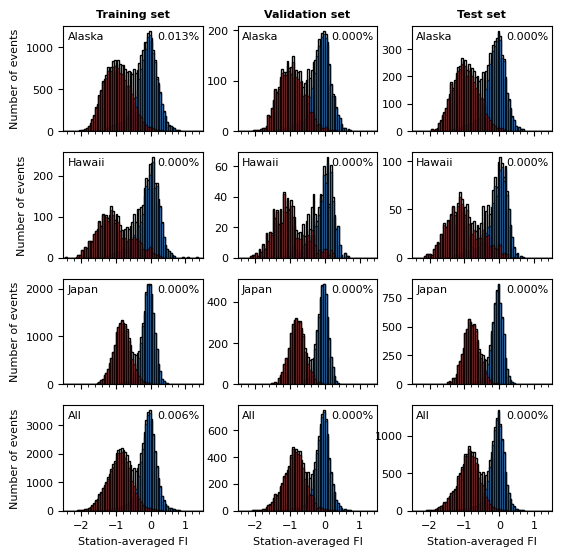

In [ ]:
freq_indices_df_list = [
    dataset.train().metadata.drop_duplicates(
        subset="source_id", keep="first", inplace=False
    ),
    dataset.dev().metadata.drop_duplicates(
        subset="source_id", keep="first", inplace=False
    ),
    dataset.test().metadata.drop_duplicates(
        subset="source_id", keep="first", inplace=False
    ),
]

fig, axs = plt.subplots(4, 3, figsize=(16 * cm, 16 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.2)
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["Alaska", "Hawaii", "Japan", "All"]
up_b = 1.5
lw_b = -2.5
bins = np.arange(lw_b, up_b + 0.01, 0.05)
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
for i in range(4):
    for j in range(3):
        ax = axs[i][j]
        freq_indices_df = freq_indices_df_list[j]
        if i < 3:
            current_df = freq_indices_df[
                (freq_indices_df["trace_chunk"] == trace_chunks[i][0])
                | (freq_indices_df["trace_chunk"] == trace_chunks[i][1])
            ]
        else:
            current_df = freq_indices_df

        freq_indices = current_df["source_frequency_index"]
        # freq_indices=freq_indices_df[(freq_indices_df["trace_chunk"]==chunks[0])|(freq_indices_df["trace_chunk"]==chunks[1])]["source_frequency_index"]
        freq_indices_lp = current_df[current_df["source_type"] == "lp"][
            "source_frequency_index"
        ]
        freq_indices_rg = current_df[current_df["source_type"] != "lp"][
            "source_frequency_index"
        ]
        ax.hist(
            freq_indices,
            bins,
            density=False,
            color="white",
            edgecolor="black",
            label="Total",
        )
        ax.hist(
            freq_indices_rg,
            bins,
            density=False,
            color="dodgerblue",
            edgecolor="black",
            alpha=0.7,
            label="VT",
        )
        ax.hist(
            freq_indices_lp,
            bins,
            density=False,
            color="firebrick",
            edgecolor="black",
            alpha=0.7,
            label="LP",
        )
        label = labels[i]
        ax.text(
            0.03,
            0.95,
            label,
            verticalalignment="top",
            horizontalalignment="left",
            transform=ax.transAxes,
            fontsize=fts,
            # weight="bold",
            color="black",
        )
        out = len(freq_indices[(freq_indices > up_b) | (freq_indices < lw_b)]) / len(
            freq_indices
        )
        print(f"{out:e}")
        ax.text(
            0.975,
            0.95,
            f"""{out*100:>5.3f}%""",
            verticalalignment="top",
            horizontalalignment="right",
            transform=ax.transAxes,
            fontsize=fts,
        )
        ax.tick_params(labelsize=fts)
        ax.xaxis.set_minor_locator(MultipleLocator(0.2))
        ax.set_xlim([lw_b, up_b])

# freq_indices=freq_indices_df["source_frequency_index"]
# freq_indices_lp=freq_indices_df[freq_indices_df["source_type"]=="lp"]["source_frequency_index"]
# freq_indices_rg=freq_indices_df[freq_indices_df["source_type"]!="lp"]["source_frequency_index"]
# axs[1][1].hist(freq_indices,bins,density=False, color="white", edgecolor="black",label="Total");
# axs[1][1].hist(freq_indices_rg, bins,density=False, color="dodgerblue", edgecolor="black", alpha=0.8, label="VT");
# axs[1][1].hist(freq_indices_lp, bins,density=False, color="firebrick", edgecolor="black", alpha=0.8, label="LP");
# axs[1][1].text(
#             0.03,
#             0.95,
#             "(d) All",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=axs[1][1].transAxes,
#             fontsize=fts,
#             # weight="bold",
#             color="black",
#         )
axs[1][1].tick_params(labelsize=fts)
axs[1][1].xaxis.set_minor_locator(MultipleLocator(0.2))
for i in range(4):
    axs[i][0].set_ylabel("Number of events", fontsize=fts)

split_lables = ["Training set", "Validation set", "Test set"]
for j in range(3):
    axs[0][j].set_title(split_lables[j], fontsize=fts, weight="bold")
    axs[-1][j].set_xlabel("Station-averaged FI", fontsize=fts)
# axs[1][0].set_ylabel("Number of events",fontsize=fts)
# axs[1][0].set_xlabel("Station-averaged frequency index",fontsize=fts)
# axs[1][1].set_xlabel("Station-averaged frequency index",fontsize=fts)

## Waveform-based frequency index

2.819887e-04
4.448399e-04
0.000000e+00
1.361858e-04


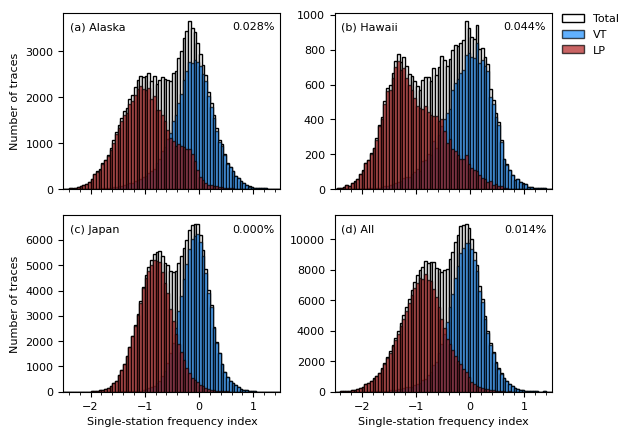

In [33]:
freq_indices_df = dataset.metadata

fig, axs = plt.subplots(2, 2, figsize=(16 * cm, 12.5 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]

fts = 8
up_b = 1.5
lw_b = -2.5
bins = np.arange(lw_b, up_b + 0.01, 0.05)
for i in range(4):
    ax = axs.flat[i]
    label = labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = freq_indices_df[
            (freq_indices_df["trace_chunk"] == chunks[0])
            | (freq_indices_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = freq_indices_df

    freq_indices = current_df["trace_frequency_index"]
    # print(len(freq_indices))
    # freq_indices=freq_indices_df[(freq_indices_df["trace_chunk"]==chunks[0])|(freq_indices_df["trace_chunk"]==chunks[1])]["trace_frequency_index"]
    freq_indices_lp = current_df[current_df["source_type"] == "lp"][
        "trace_frequency_index"
    ]
    freq_indices_rg = current_df[current_df["source_type"] != "lp"][
        "trace_frequency_index"
    ]
    ax.hist(
        freq_indices,
        bins,
        density=False,
        color="white",
        edgecolor="black",
        label="Total",
    )
    ax.hist(
        freq_indices_rg,
        bins,
        density=False,
        color="dodgerblue",
        edgecolor="black",
        alpha=0.7,
        label="VT",
    )
    ax.hist(
        freq_indices_lp,
        bins,
        density=False,
        color="firebrick",
        edgecolor="black",
        alpha=0.7,
        label="LP",
    )
    ax.text(
        0.03,
        0.95,
        label,
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    out = len(freq_indices[(freq_indices > up_b) | (freq_indices < lw_b)]) / len(
        freq_indices
    )
    print(f"{out:e}")
    ax.text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.set_xlim([lw_b, up_b])

axs[0][0].set_ylabel("Number of traces", fontsize=fts)
axs[1][0].set_ylabel("Number of traces", fontsize=fts)
axs[1][0].set_xlabel("Single-station frequency index", fontsize=fts)
axs[1][1].set_xlabel("Single-station frequency index", fontsize=fts)

axs[0][1].legend(
    loc="upper left", bbox_to_anchor=(1.0, 0.55, 0.2, 0.5), frameon=False, fontsize=fts
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/trace_FI_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/trace_FI_histogram.jpg",
    dpi=300,
    bbox_inches="tight",
)

# Epicentral_distance

0
0
0
0


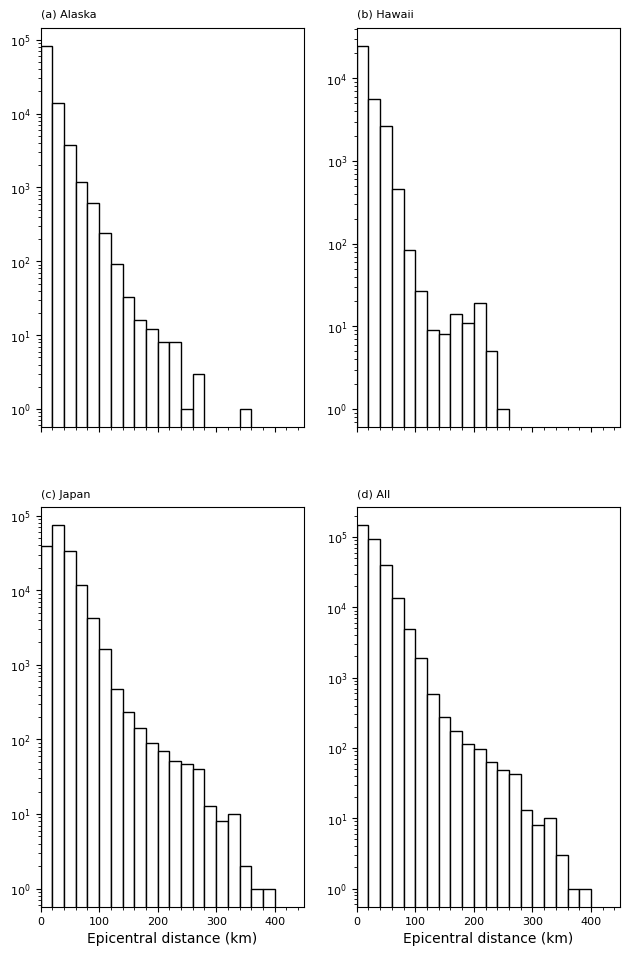

In [43]:
epic_dist_df = data_eq.metadata

fig, axs = plt.subplots(2, 2, figsize=(19 * cm, 29 * cm), sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
bins = np.arange(0, 450, 20)
for i in range(4):
    ax = axs.flat[i]

    label = labels[i]

    if i < 3:
        chunks = trace_chunks[i]
        current_df = epic_dist_df[
            (epic_dist_df["trace_chunk"] == chunks[0])
            | (epic_dist_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = epic_dist_df
    print(len(current_df[pd.isna(current_df["station_epicentral_distance_m"])]))
    ax.hist(
        current_df["station_epicentral_distance_m"] / 1000,
        bins=bins,
        color="white",
        edgecolor="black",
        log=True,
    )
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.set_xlim([0, 450])
    ax.tick_params(labelsize=fts)
axs[1][0].set_xlabel("Epicentral distance (km)")
axs[1][1].set_xlabel("Epicentral distance (km)")
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/epic_dist_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)
ax.xaxis.set_minor_locator(MultipleLocator(20))

0 102841
0 33720
0 166527
0 303088


Text(0.5, 0, 'Azimuth ($^\\circ$)')

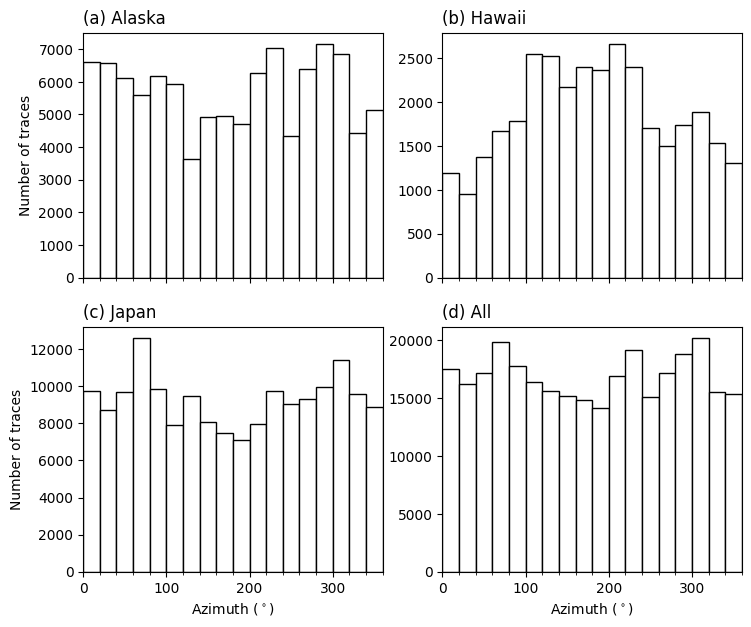

In [ ]:
azimuth_df = data_eq.metadata

fig, axs = plt.subplots(2, 2, figsize=(8.5, 7), sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
for i in range(4):
    ax = axs.flat[i]

    label = labels[i]

    if i < 3:
        chunks = trace_chunks[i]
        current_df = azimuth_df[
            (azimuth_df["trace_chunk"] == chunks[0])
            | (azimuth_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = azimuth_df
    print(
        len(current_df[pd.isna(current_df["path_back_azimuth_deg"])]),
        len(current_df[pd.notna(current_df["path_back_azimuth_deg"])]),
    )
    ax.hist(
        current_df["path_back_azimuth_deg"],
        bins=np.arange(0, 360 + 1, 20),
        color="white",
        edgecolor="black",
        log=False,
    )
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=12,
        # weight="bold",
        color="black",
    )
    ax.tick_params(labelsize=10)
    ax.set_xlim([0, 360])
    ax.xaxis.set_minor_locator(MultipleLocator(20))
axs[0][0].set_ylabel(r"Number of traces", fontsize=10)
axs[1][0].set_ylabel(r"Number of traces", fontsize=10)
axs[-1][0].set_xlabel(r"Azimuth ($^\circ$)", fontsize=10)
axs[-1][1].set_xlabel(r"Azimuth ($^\circ$)", fontsize=10)

In [ ]:
print(max(current_df["station_epicentral_distance_m"] / 1000))

381.8521620627691


Epicentral distances and azimuths in the same plot

0
0
0
0
0 102841
0 33720
0 166527
0 303088


Text(0.5, 0, 'Back azimuth ($^\\circ$)')

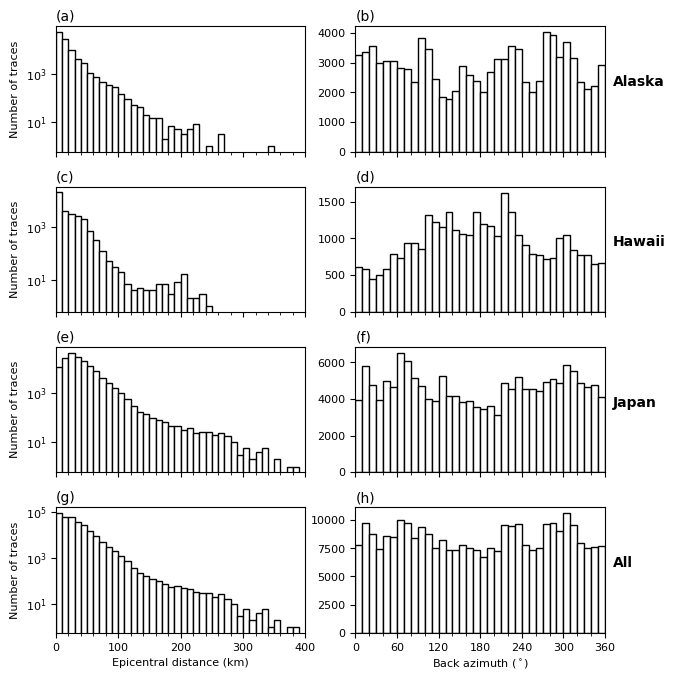

In [45]:
epidist_and_azimuth_df = data_eq.metadata

fig, axs = plt.subplots(4, 2, figsize=(18 * cm, 20 * cm), sharex="col")
plt.subplots_adjust(wspace=0.2, hspace=0.28)

trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a)", "(c)", "(e)", "(g)"]
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
bins = np.arange(0, 400 + 1, 10)
for i in range(4):
    ax = axs[i][0]

    label = labels[i]

    if i < 3:
        chunks = trace_chunks[i]
        current_df = epidist_and_azimuth_df[
            (epidist_and_azimuth_df["trace_chunk"] == chunks[0])
            | (epidist_and_azimuth_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = epidist_and_azimuth_df
    print(len(current_df[pd.isna(current_df["station_epicentral_distance_m"])]))
    ax.hist(
        current_df["station_epicentral_distance_m"] / 1000,
        bins=bins,
        color="white",
        edgecolor="black",
        log=True,
    )
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts + 2,
        # weight="bold",
        color="black",
    )
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
    # ax.yaxis.set_major_locator(LogLocator(10,(1,2,3,4,5)))
    ax.set_xlim([0, 400])
    ax.set_ylabel("Number of traces", fontsize=fts)
    ax.tick_params(labelsize=fts)

labels = ["(b)", "(d)", "(f)", "(h)"]
region_labels = ["Alaska", "Hawaii", "Japan", "All"]
for i in range(4):
    ax = axs[i][1]
    label = labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = epidist_and_azimuth_df[
            (epidist_and_azimuth_df["trace_chunk"] == chunks[0])
            | (epidist_and_azimuth_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = epidist_and_azimuth_df
    print(
        len(current_df[pd.isna(current_df["path_back_azimuth_deg"])]),
        len(current_df[pd.notna(current_df["path_back_azimuth_deg"])]),
    )
    ax.hist(
        current_df["path_back_azimuth_deg"],
        bins=np.arange(0, 360 + 1, 10),
        color="white",
        edgecolor="black",
        log=False,
    )
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts + 2,
        # weight="bold",
        color="black",
    )
    ax.text(
        1.03,
        0.5,
        region_labels[i],
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts + 2,
        weight="bold",
        color="black",
    )
    ax.tick_params(labelsize=fts)
    ax.set_xlim([0, 360])
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(20))

axs[-1][0].set_xlabel("Epicentral distance (km)", fontsize=fts)
axs[-1][1].set_xlabel(r"Back azimuth ($^\circ$)", fontsize=fts)
# plt.savefig(
#     "/home/zhongyiyuan/DATA/my_datasets_seisbench/epic_dist_histogram.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )
# ax.xaxis.set_minor_locator(MultipleLocator(20))

In [ ]:
epidist_and_azimuth_df = data_eq.metadata

In [ ]:
len(
    epidist_and_azimuth_df[
        epidist_and_azimuth_df["station_epicentral_distance_m"] / 1000 > 100
    ]
) / len(epidist_and_azimuth_df)

0.010957213746502666

Distribution shown in the polar cooridinate

0
0
0
0


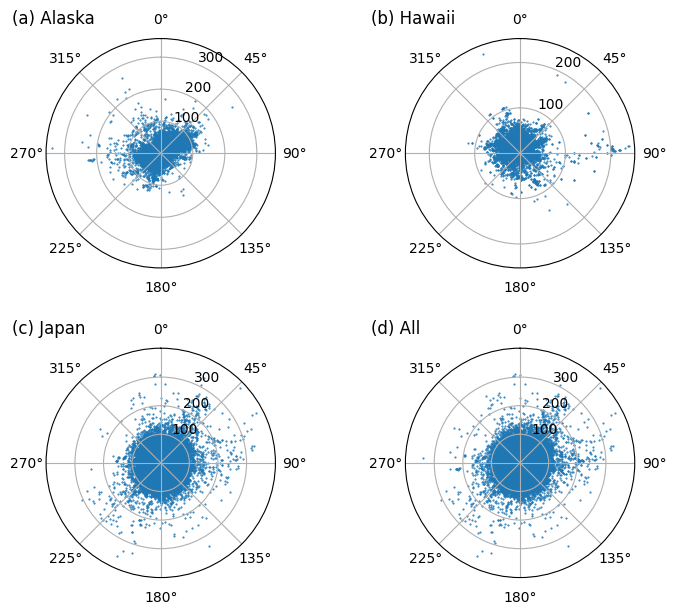

In [ ]:
azimuth_df = data_eq.metadata

fig, axs = plt.subplots(2, 2, figsize=(8.5, 7), subplot_kw={"projection": "polar"})
plt.subplots_adjust(wspace=0.2, hspace=0.35)
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
for i in range(4):
    ax = axs.flat[i]

    label = labels[i]

    if i < 3:
        chunks = trace_chunks[i]
        current_df = azimuth_df[
            (azimuth_df["trace_chunk"] == chunks[0])
            | (azimuth_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = azimuth_df
    print(len(current_df[pd.isna(current_df["path_azimuth_deg"])]))
    # ax.hist(current_df["path_azimuth_deg"],bins=50,color="white", edgecolor="black",log=False)
    ax.scatter(
        current_df["path_azimuth_deg"] / 180 * np.pi,
        current_df["station_epicentral_distance_m"] / 1000,
        s=0.25,
    )
    ax.set_theta_zero_location("N")  # theta=0 at the top
    ax.set_theta_direction(-1)  # theta increasing clockwise
    # ax.set_rlabel_position(-22.5)
    ax.tick_params(labelsize=10)
    ax.set_rticks(
        np.arange(
            100, np.max(current_df["station_epicentral_distance_m"] / 1000) + 1, 100
        )
    )
    ax.text(
        -0.15,
        1.05,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=12,
        # weight="bold",
        color="black",
    )

# Depth

Log scale

0
-3.2 173.99
0
-3.79 69.95
0
0.0 278.0
0
-3.79 278.0


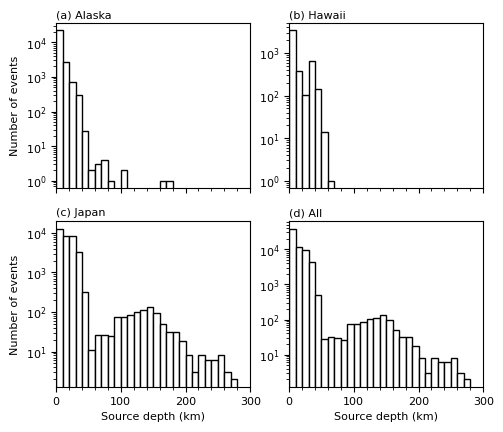

In [ ]:
depth_df = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)

fig, axs = plt.subplots(2, 2, figsize=(14 * cm, 12 * cm), sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
bins = np.arange(0, 300 + 1, 10)
for i in range(4):
    ax = axs.flat[i]

    label = labels[i]

    if i < 3:
        chunks = trace_chunks[i]
        current_df = depth_df[
            (depth_df["trace_chunk"] == chunks[0])
            | (depth_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = depth_df
    print(len(current_df[pd.isna(current_df["source_depth_km"])]))
    print(min(current_df["source_depth_km"]), max(current_df["source_depth_km"]))
    ax.hist(
        current_df["source_depth_km"],
        bins=bins,
        color="white",
        edgecolor="black",
        log=True,
    )
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.set_xlim([0, 300])
    ax.tick_params(labelsize=fts)
axs[1][0].set_xlabel("Source depth (km)", fontsize=fts)
axs[1][1].set_xlabel("Source depth (km)", fontsize=fts)
axs[0][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/depths_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(20))

In [ ]:
depths

(array([ 8.82,  7.02,  7.02, ..., 12.42,  5.77,  0.  ]),
 array([25.96, 29.08, 32.82, ..., 26.68, 29.82, 28.54]))

In [ ]:
depth_df = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)

In [ ]:
len(depth_df[(depth_df["source_depth_km"] < 20) & (depth_df["source_depth_km"] > 0)])

48939

In [ ]:
depth_df = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)
print(len(depth_df[pd.isna(depth_df["source_depth_km"])]))
depths_gt_60 = len(depth_df[depth_df["source_depth_km"] > 60])
print(depths_gt_60 / len(depth_df))

0
0.01350352513077098


In [ ]:
bins

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300])

Linear scale

278.0
0 0
-3.2 173.99
0 0
-3.79 57.08
0 0
0.0 278.0
0 0
-3.79 278.0


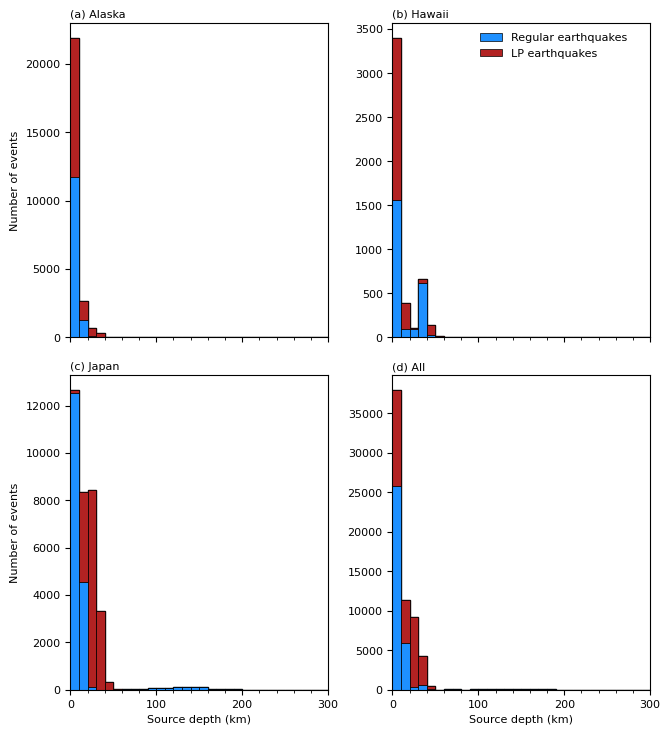

In [ ]:
fts = 8
depth_df = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)
depth_df_lp = depth_df[depth_df["source_type"] == "lp"]
depth_df_vt = depth_df[depth_df["source_type"] != "lp"]

print(np.max(depth_df_vt["source_depth_km"]))
fig, axs = plt.subplots(2, 2, figsize=(19 * cm, 22 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.12)

trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
# bins=np.arange(0,300+1,10)
for i in range(4):
    ax = axs.flat[i]

    label = labels[i]

    if i < 3:
        chunks = trace_chunks[i]
        current_df = depth_df[
            (depth_df["trace_chunk"] == chunks[0])
            | (depth_df["trace_chunk"] == chunks[1])
        ]
        current_df_vt = depth_df_vt[
            (depth_df_vt["trace_chunk"] == chunks[0])
            | (depth_df_vt["trace_chunk"] == chunks[1])
        ]
        current_df_lp = depth_df_lp[
            (depth_df_lp["trace_chunk"] == chunks[0])
            | (depth_df_lp["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = depth_df
        current_df_vt = depth_df_vt
        current_df_lp = depth_df_lp
    print(
        len(current_df_vt[pd.isna(current_df_vt["source_depth_km"])]),
        len(current_df_lp[pd.isna(current_df_lp["source_depth_km"])]),
    )
    print(min(current_df_vt["source_depth_km"]), max(current_df_vt["source_depth_km"]))
    ax.hist(current_df["source_depth_km"], bins=bins, color="white", edgecolor="black")
    # ax.hist(current_df_lp["source_depth_km"],bins=bins,color="blue", edgecolor="black")
    ax.hist(
        [current_df_vt["source_depth_km"], current_df_lp["source_depth_km"]],
        bins=bins,
        color=["dodgerblue", "firebrick"],
        edgecolor="black",
        stacked=True,
        linewidth=0.5,
        label=["Regular earthquakes", "LP earthquakes"],
    )

    # ax.hist(current_df_lp["source_depth_km"],bins=bins,color="firebrick", edgecolor="black",log=False,alpha=0.5,stacked=True)
    # ax.hist(current_df_vt["source_depth_km"],bins=bins,color="dodgerblue", edgecolor="black",log=False,alpha=0.5,stacked=True)

    ax.text(
        0.0,
        1.01,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.set_xlim([0, 300])
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
axs[0][1].legend(
    loc="upper left", bbox_to_anchor=(0.3, 0.5, 0.2, 0.5), frameon=False, fontsize=fts
)
axs[1][0].set_xlabel("Source depth (km)", fontsize=fts)
axs[1][1].set_xlabel("Source depth (km)", fontsize=fts)
axs[0][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)

# plt.savefig(
#     "/home/zhongyiyuan/DATA/my_datasets_seisbench/depths_histogram_linear.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )

Histogram of stacked data sets example

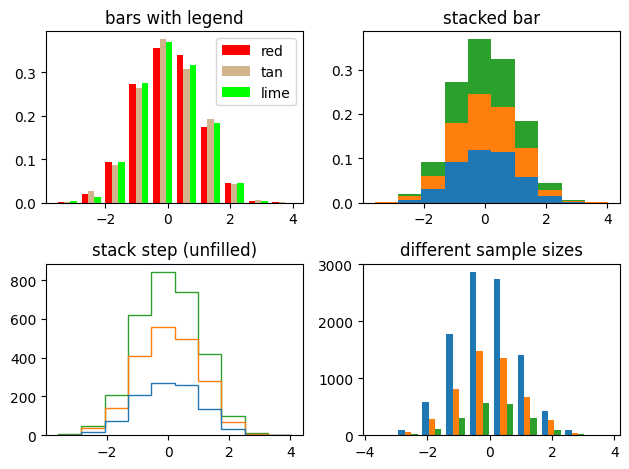

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors = ["red", "tan", "lime"]
ax0.hist(x, n_bins, density=True, histtype="bar", color=colors, label=colors)
ax0.legend(prop={"size": 10})
ax0.set_title("bars with legend")

ax1.hist(x, n_bins, density=True, histtype="bar", stacked=True)
ax1.set_title("stacked bar")

ax2.hist(x, n_bins, histtype="step", stacked=True, fill=False)
ax2.set_title("stack step (unfilled)")

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype="bar")
ax3.set_title("different sample sizes")

fig.tight_layout()
plt.show()

# Magnitude

In [55]:
# no_mag_data=data_eq.filter(pd.isna(data_eq["source_magnitude_type"]),inplace=False)
# available_mag_data=data_eq.filter(pd.notna(data_eq["source_magnitude_type"]),inplace=False)

eq_metadata = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)

no_mag_data = eq_metadata[
    (pd.isna(eq_metadata["source_magnitude_type"]))
    | (eq_metadata["source_magnitude_type"] == "m")
]  # see line 3493 and line 2273 in data/data.py
available_mag_data = eq_metadata[
    (pd.notna(eq_metadata["source_magnitude_type"]))
    & (eq_metadata["source_magnitude_type"] != "m")
]

In [56]:
print(len(no_mag_data))
print(len(available_mag_data))
print(len(eq_metadata))

488
69864
70352


In [ ]:
no_mag_data

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_arrival_sample,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,trace_chunk,trace_component_order
37827,37827,alk70011104,2012-05-30T16:54:15.610000Z,60.506667,-152.663000,3.40,0.0,m,lp,AV,...,6066.0,NaN,"[18.15780551532945, 19.608454574214463, 22.054...",19.940316,-0.941282,test,alk70011104_AV.REF..EH.mseed,-1.101861,_ak_lp,ZNE
110280,222,hawaii2_60395051,2012-09-07T18:12:44.780000Z,19.424000,-155.270000,12.01,0.0,NaN,lp,HV,...,6349.0,NaN,"[-7.089277480648376, 5.8797848963628425, -3.40...",-1.537535,-0.619998,train,hawaii2_60395051_HV.AIND..HH.mseed,-0.462712,_hw12t21_lp,ZNE
110320,262,hawaii2_60419896,2012-10-26T16:28:04.470000Z,19.417000,-155.271167,2.43,0.0,NaN,lp,HV,...,6140.0,NaN,"[12.399851628742464, 10.865207857191294, 11.34...",11.538311,-1.595250,train,hawaii2_60419896_HV.AHUD..EH.mseed,-1.336447,_hw12t21_lp,ZNE
111115,1057,hawaii2_60632386,2014-01-28T09:25:15.530000Z,19.332000,-155.143167,1.43,0.0,NaN,lp,HV,...,6590.0,NaN,"[-2.4262530251523335, -4.5702985913509995, -3....",-3.444018,-0.141152,train,hawaii2_60632386_HV.AIND..HH.mseed,-0.119401,_hw12t21_lp,ZNE
112107,2049,hawaii2_60651311,2014-03-07T05:33:03.180000Z,19.421167,-155.272000,2.11,0.0,NaN,lp,HV,...,6058.0,NaN,"[-3.9769776356165067, -1.198921071674197, -5.2...",-3.465247,-0.083847,train,hawaii2_60651311_HV.BYL..HH.mseed,0.116985,_hw12t21_lp,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143655,16691,hawaii2_72716697,2021-09-20T06:15:55.500000Z,19.181333,-155.409167,31.35,0.0,NaN,le,HV,...,6620.0,NaN,"[-1.3336621844345078, 2.622033064556635, 4.456...",1.914857,0.128925,train,hawaii2_72716697_HV.HSSD..HH.mseed,0.128925,_hw12t21_rg,ZNE
143656,16692,hawaii2_72716947,2021-09-20T11:20:24.780000Z,19.221833,-155.418000,33.44,0.0,NaN,le,HV,...,6426.0,NaN,"[5.3811740236991525, 9.15646541811258, 7.49593...",7.344525,0.124694,train,hawaii2_72716947_HV.AIND..HH.mseed,0.095745,_hw12t21_rg,ZNE
143661,16697,hawaii2_72719827,2021-09-22T10:07:02.110000Z,19.221833,-155.405667,32.26,0.0,NaN,le,HV,...,6604.0,NaN,"[3.079789949492378, 4.562398021837321, 1.32561...",2.989268,0.215271,train,hawaii2_72719827_HV.HSSD..HH.mseed,-0.077973,_hw12t21_rg,ZNE
143671,16707,hawaii2_72720132,2021-09-22T15:09:50.820000Z,19.202667,-155.389167,32.45,0.0,NaN,le,HV,...,6459.0,NaN,"[1.502858826627883, -5.087286302189527, 1.6875...",-0.632281,0.177313,train,hawaii2_72720132_HV.PUHI..HH.mseed,0.103659,_hw12t21_rg,ZNE


In [ ]:
np.unique(available_mag_data["source_magnitude_type"])

array(['D', 'V', 'md', 'mh', 'ml', 'v'], dtype=object)

$M_D$, $M_V$ and $M_v are from JMA

$D$ displacement magnitude

$V$ velocity magnitude

$v$ same as $M_V$ but for two or three stations

Others

$md$ duration https://www.usgs.gov/programs/earthquake-hazards/magnitude-types

$mh$ 

$ml$ local magnitude

['$M_V$', '$M_v$', '$M_D$', '$M_d$', '$M_h$', '$M_l$', 'Not available']
[30258, 3730, 27, 3066, 12, 32771, 488]


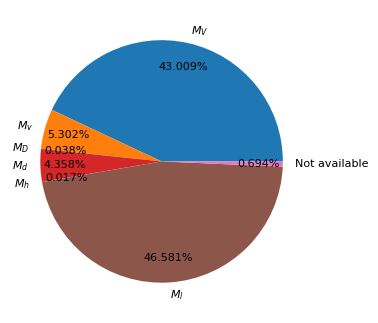

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12 * cm, 10 * cm))
types = ["V", "v", "D", "md", "mh", "ml"]
counts = []
labels = []
type_label_dict = {
    "D": r"$M_D$",
    "V": r"$M_V$",
    "md": r"$M_d$",
    "mh": r"$M_h$",
    "ml": r"$M_l$",
    "v": r"$M_v$",
}
for i in range(len(types)):
    labels.append(f"{type_label_dict[types[i]]}")
    counts.append(
        len(available_mag_data[available_mag_data["source_magnitude_type"] == types[i]])
    )
    # counts.append(count)
labels.append("Not available")
counts.append(len(no_mag_data))
print(labels)
print(counts)
plt.pie(
    counts,
    labels=labels,
    autopct="%1.3f%%",
    textprops={"fontsize": fts},
    #    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    pctdistance=0.8,
)
# plt.savefig(
#     "/home/zhongyiyuan/DATA/my_datasets_seisbench/mag_types_pie_chart.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )

In [ ]:
mags

0         0.1
2        -0.1
3         0.4
4        -0.1
5        -0.2
         ... 
315491    2.3
315492    2.7
315493    2.5
315494    1.7
315495    2.3
Name: source_magnitude, Length: 69864, dtype: float64

min -1.22, max 4.5
min -9.0, max 3.87
min -1.1, max 4.8
min -9.0, max 4.8


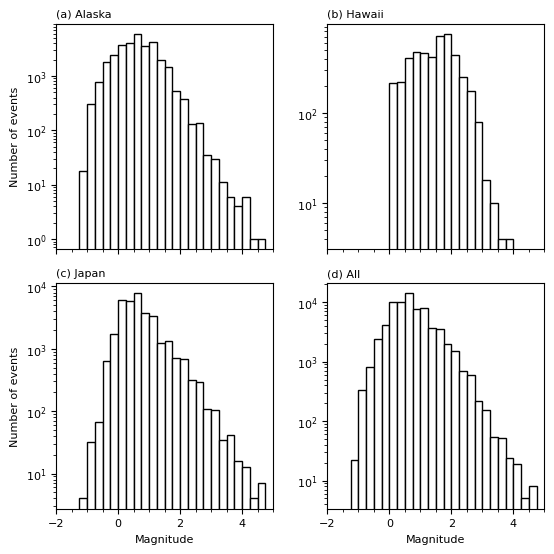

In [ ]:
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
subplot_labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
fig, axs = plt.subplots(2, 2, figsize=(16 * cm, 16 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
for i in range(4):
    ax = axs.flat[i]
    label = subplot_labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = available_mag_data[
            (available_mag_data["trace_chunk"] == chunks[0])
            | (available_mag_data["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = available_mag_data
    mags = current_df["source_magnitude"]
    # print((mags[mags<-1]))
    print(f"min {np.min(mags)}, max {np.max(mags)}")

    bins = np.arange(-2.0, 5, 0.25)
    ax.hist(
        mags.values, bins, density=False, color="white", edgecolor="black", log=True
    )  # ,cumulative=-1
    ax.set_xlim([-2, 5])
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
# plt.hist(freq_indices_rg, bins,density=False, color="dodgerblue", edgecolor="black", alpha=0.8, label="VT")
# plt.hist(freq_indices_lp, bins,density=False, color="firebrick", edgecolor="black", alpha=0.8, label="LP")

plt.gca().tick_params(labelsize=fts)
axs[1][0].set_xlabel("Magnitude", fontsize=fts)
axs[1][1].set_xlabel("Magnitude", fontsize=fts)
axs[0][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/magnitude_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)

min -1.22, max 4.5
min -9.0, max 3.62
min -0.9, max 2.9
min -9.0, max 4.5


Text(0, 0.5, 'Number of events')

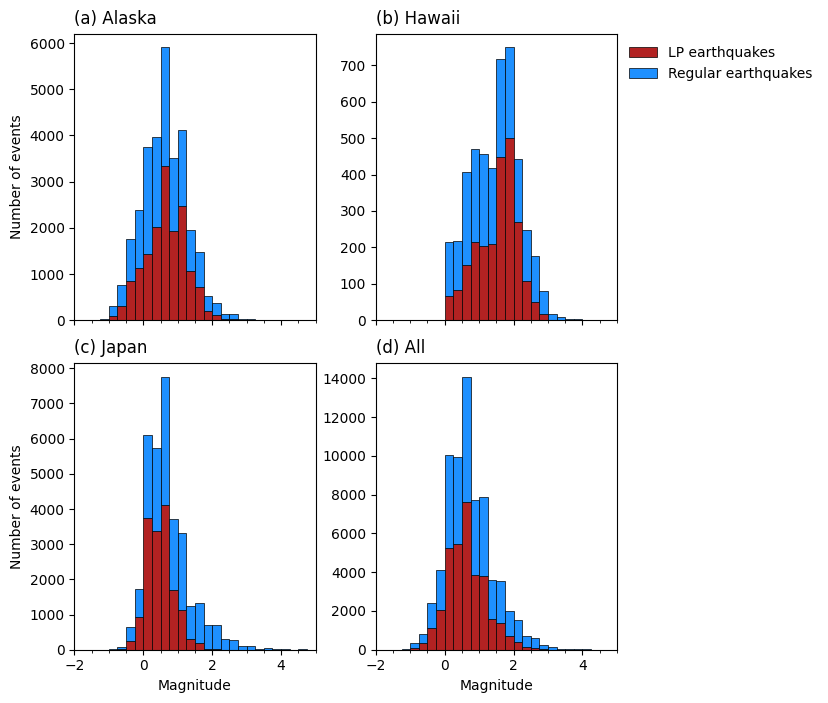

In [ ]:
fts = 10
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
subplot_labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
fig, axs = plt.subplots(2, 2, figsize=(7, 8), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
for i in range(4):
    ax = axs.flat[i]
    label = subplot_labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = available_mag_data[
            (available_mag_data["trace_chunk"] == chunks[0])
            | (available_mag_data["trace_chunk"] == chunks[1])
        ]
        current_df_vt = available_mag_data[
            (
                (available_mag_data["trace_chunk"] == chunks[0])
                | (available_mag_data["trace_chunk"] == chunks[1])
            )
            & (available_mag_data["source_type"] != "lp")
        ]
        current_df_lp = available_mag_data[
            (
                (available_mag_data["trace_chunk"] == chunks[0])
                | (available_mag_data["trace_chunk"] == chunks[1])
            )
            & (available_mag_data["source_type"] == "lp")
        ]
    else:
        current_df = available_mag_data
        current_df_vt = available_mag_data[available_mag_data["source_type"] != "lp"]
        current_df_lp = available_mag_data[available_mag_data["source_type"] == "lp"]
    mags = current_df["source_magnitude"]
    # print((mags[mags<-1]))
    print(
        f"min {np.min(current_df_lp['source_magnitude'])}, max {np.max(current_df_lp['source_magnitude'])}"
    )

    bins = np.arange(-2.0, 5, 0.25)
    # ax.hist(mags.values,bins,density=False,color="white", edgecolor="black",log=True) # cumulative=-1
    ax.hist(
        [
            current_df_lp["source_magnitude"].values,
            current_df_vt["source_magnitude"].values,
        ],
        bins,
        density=False,
        color=["firebrick", "dodgerblue"],
        edgecolor="black",
        stacked=True,
        linewidth=0.5,
        label=["LP earthquakes", "Regular earthquakes"],
    )  # cumulative=-1
    ax.set_xlim([-2, 5])
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts + 2,
        # weight="bold",
        color="black",
    )
# plt.hist(freq_indices_rg, bins,density=False, color="dodgerblue", edgecolor="black", alpha=0.8, label="VT")
# plt.hist(freq_indices_lp, bins,density=False, color="firebrick", edgecolor="black", alpha=0.8, label="LP")
axs[0][1].legend(
    loc="upper left", bbox_to_anchor=(1.0, 0.5, 0.2, 0.5), frameon=False, fontsize=fts
)
# plt.gca().tick_params(labelsize=fts)
axs[1][0].set_xlabel("Magnitude", fontsize=fts)
axs[1][1].set_xlabel("Magnitude", fontsize=fts)
axs[0][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)
# plt.savefig("/home/zhongyiyuan/DATA/my_datasets_seisbench/magnitude_histogram.pdf",dpi=300,bbox_inches="tight")

In [ ]:
available_mag_data[
    (available_mag_data["source_magnitude"] < -1)
    & (available_mag_data["source_magnitude"] > -9)
]

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_arrival_sample,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,trace_chunk,trace_component_order
38305,38305,alk60198197,2012-10-20T09:49:31.100000Z,60.067000,-153.007500,9.05,-1.10,ml,lp,AV,...,6156.0,NaN,"[9.309903558752223, nan, nan]",9.309904,-0.073086,train,alk60198197_AV.ILS..EH.mseed,-0.904866,_ak_lp,ZNE
39766,39766,alk70180709,2013-08-11T16:54:08.500000Z,60.512833,-152.765000,0.11,-1.06,ml,lp,AV,...,6194.0,NaN,"[4.207717741781448, nan, nan]",4.207718,-0.825961,train,alk70180709_AV.DFR..EH.mseed,-0.847022,_ak_lp,ZNE
51280,51280,alk70766884,2017-11-02T10:14:36.630000Z,58.289667,-154.990500,12.07,-1.07,ml,lp,AV,...,6235.0,NaN,"[5.015158287240446, -2.3287264978726356, 2.272...",1.652982,-1.249398,test,alk70766884_AV.KABU..BH.mseed,-1.100445,_ak_lp,ZNE
51283,51283,alk70766889,2017-11-02T10:14:47.360000Z,58.290333,-154.977500,11.07,-1.22,ml,lp,AV,...,6204.0,NaN,"[8.472119367631066, -1.8640849474591072, 1.288...",2.632058,-0.571755,train,alk70766889_AV.KAKN..BH.mseed,-0.792119,_ak_lp,ZNE
96589,44647,alk70704094,2016-03-15T07:42:36.140000Z,59.355000,-153.442833,0.82,-1.02,ml,le,AV,...,6110.0,NaN,"[3.0204072765327346, -3.279547104697591, nan]",-0.129570,-0.777320,train,alk70704094_AV.AUQ..BH.mseed,-0.903128,_ak_rg,ZNE
96920,44978,alk70709934,2016-05-07T06:25:11.960000Z,59.352500,-153.438167,0.55,-1.02,ml,le,AV,...,6062.0,NaN,"[-7.872949040300643, 5.351439478276776, -2.800...",-1.773867,-0.966437,train,alk70709934_AV.AUJA..BH.mseed,-0.801992,_ak_rg,ZNE
97369,45427,alk70715819,2016-07-06T16:04:42.380000Z,59.359333,-153.431500,-0.05,-1.12,ml,le,AV,...,6064.0,NaN,"[-0.858599290770632, 3.4809867704350155, 3.662...",2.094849,-0.303701,train,alk70715819_AV.AUCH..BH.mseed,-0.458347,_ak_rg,ZNE
97373,45431,alk70715799,2016-07-06T16:44:38.490000Z,59.360167,-153.432167,-0.07,-1.03,ml,le,AV,...,6056.0,NaN,"[0.09625732860534461, 2.475772353753387, -1.42...",0.382103,-0.424372,train,alk70715799_AV.AUSS..BH.mseed,-0.322472,_ak_rg,ZNE
97401,45459,alk70716579,2016-07-12T04:36:58.140000Z,59.359000,-153.433333,-0.03,-1.05,ml,le,AV,...,6044.0,NaN,"[6.705200171465105, 4.889928624037393, 6.38838...",5.994504,-0.266018,train,alk70716579_AV.AUCH..BH.mseed,-0.468255,_ak_rg,ZNE
97407,45465,alk70716544,2016-07-12T06:04:53.350000Z,59.359500,-153.428500,0.36,-1.10,ml,le,AV,...,6062.0,NaN,"[-6.541108532850383, -2.8747593332192247, 2.27...",-2.381884,-0.539476,test,alk70716544_AV.AUJA..BH.mseed,-0.313270,_ak_rg,ZNE


In [ ]:
available_mag_data.metadata[available_mag_data["source_magnitude_type"] == "m"]

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_arrival_sample,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,trace_chunk,trace_component_order
37827,37827,alk70011104,2012-05-30T16:54:15.610000Z,60.506667,-152.663,3.4,0.0,m,lp,AV,...,6066.0,NaN,"[18.15780551532945, 19.608454574214463, 22.054...",19.940316,-0.941282,test,alk70011104_AV.REF..EH.mseed,-1.101861,_ak_lp,ZNE
37828,37828,alk70011104,2012-05-30T16:54:15.610000Z,60.506667,-152.663,3.4,0.0,m,lp,AV,...,6130.0,NaN,"[23.298747321739288, nan, nan]",23.298747,-1.262441,train,alk70011104_AV.RSO..EH.mseed,-1.101861,_ak_lp,ZNE


# Extra test sets

In [66]:
japan_tec_lp = sbd.WaveformDataset(
    Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/japan_tec_lp"),
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)

In [67]:
len(
    japan_tec_lp.metadata.drop_duplicates(
        subset="source_id", keep="first", inplace=False
    )
)

2356

In [68]:
ncedc = sbd.WaveformDataset(
    Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc"),
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)

In [69]:
ncedc_vt = ncedc.filter(ncedc["trace_chunk"] == "_ncedc_vt", inplace=False)

In [70]:
ncedc_lp = ncedc.filter(ncedc["trace_chunk"] == "_ncedc_lp", inplace=False)

In [71]:
len(ncedc_lp)

4841

In [72]:
len(ncedc_vt)

4841

In [73]:
print(
    len(ncedc.metadata.drop_duplicates(subset="source_id", keep="first", inplace=False))
)

2743


In [74]:
1649 + 1094

2743

In [75]:
len(ncedc_vt)

4841

In [76]:
len(ncedc_lp)

4841

In [77]:
print(len(ncedc_lp))
print(
    len(
        ncedc_lp.metadata.drop_duplicates(
            subset="source_id", keep="first", inplace=False
        )
    )
)

4841
1094


In [78]:
print(len(ncedc_vt))
print(
    len(
        ncedc_vt.metadata.drop_duplicates(
            subset="source_id", keep="first", inplace=False
        )
    )
)

4841
1649


In [79]:
ncedc_lp.metadata.drop_duplicates(subset="source_id", keep="first", inplace=False)

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,source_active_volcano_distance_m,trace_chunk,trace_component_order
0,0,ncedc40269,1985-01-17T06:47:42.830000Z,40.506000,-121.630167,15.91,1.35,Md,lp,NC,...,NaN,"[10.827836335356018, nan, nan]",10.827836,-0.840885,test,ncedc40269_NC.LDB..EH.mseed,-0.959857,10471.986418,_ncedc_lp,ZNE
5,5,ncedc49370,1985-06-03T05:24:31.930000Z,39.058333,-122.965167,24.20,1.55,Md,lp,NC,...,NaN,"[12.824042540553116, nan, nan]",12.824043,-0.733444,test,ncedc49370_NC.GHG..EH.mseed,-1.015047,19541.844805,_ncedc_lp,ZNE
7,7,ncedc58439,1985-10-20T11:19:33.030000Z,40.468833,-121.519833,12.15,1.50,Md,lp,NC,...,NaN,"[12.666200385912461, nan, nan]",12.666200,-1.019100,test,ncedc58439_NC.LSL..EH.mseed,-1.019100,2761.268961,_ncedc_lp,ZNE
8,8,ncedc59576,1985-11-08T04:08:58.100000Z,39.036167,-122.924667,21.67,1.94,Md,lp,NC,...,NaN,"[18.616647943473193, nan, nan]",18.616648,-1.007215,test,ncedc59576_NC.GHG..EH.mseed,-1.007215,15279.179384,_ncedc_lp,ZNE
9,9,ncedc62678,1985-12-10T10:24:04.980000Z,39.016167,-122.919167,21.39,2.27,Md,lp,NC,...,NaN,"[15.54972256358047, nan, nan]",15.549723,-1.085947,test,ncedc62678_NC.GHV..EH.mseed,-1.085947,13902.244442,_ncedc_lp,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820,4820,ncedc73301801,2019-11-09T22:32:45.340000Z,40.463667,-121.609167,10.42,0.33,Md,lp,NC,...,NaN,"[11.626837167615365, nan, nan]",11.626837,-0.741026,test,ncedc73301801_NC.LSI..EH.mseed,-1.048433,9137.252612,_ncedc_lp,ZNE
4825,4825,ncedc73311616,2019-11-30T14:02:39.180000Z,40.490500,-121.610000,14.17,0.50,Md,lp,NC,...,NaN,"[8.352762130032648, nan, nan]",8.352762,-0.323537,test,ncedc73311616_NC.LSH.03.EH.mseed,-1.099095,8649.038716,_ncedc_lp,ZNE
4831,4831,ncedc73312786,2019-12-09T06:48:42.340000Z,37.643333,-118.896000,-1.58,0.48,Md,lp,NC,...,NaN,"[39.257606702989136, 29.61068018438818, 31.401...",33.423187,-1.232621,test,ncedc73312786_NC.MEM..EH.mseed,-0.792398,6694.671609,_ncedc_lp,ZNE
4834,4834,ncedc73313121,2019-12-10T06:41:45.760000Z,37.649333,-118.896667,-1.29,0.25,Md,lp,NC,...,NaN,"[38.06851563749734, nan, nan]",38.068516,-0.579173,test,ncedc73313121_NC.MCS..EH.mseed,-0.579173,6095.749274,_ncedc_lp,ZNE


In [80]:
cascade = sbd.WaveformDataset(
    Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/cascade"),
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
cascade_vt = cascade.filter(cascade["trace_chunk"] == "_cascade_vt", inplace=False)
cascade_lp = cascade.filter(cascade["trace_chunk"] == "_cascade_lp", inplace=False)
print(len(cascade_vt))
print(len(cascade_lp))
print(
    len(
        cascade.metadata.drop_duplicates(
            subset="source_id", keep="first", inplace=False
        )
    )
)

print(
    len(
        cascade_vt.metadata.drop_duplicates(
            subset="source_id", keep="first", inplace=False
        )
    )
)
print(
    len(
        cascade_lp.metadata.drop_duplicates(
            subset="source_id", keep="first", inplace=False
        )
    )
)

810
810
421
220
201


In [81]:
1649 + 220

1869

In [82]:
1094 + 201

1295

In [83]:
1649 + 220 + 1094 + 201

3164

In [84]:
4841 + 810

5651

In [85]:
westernus = sbd.WaveformDataset(
    Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus"),
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
westernus_vt = westernus.filter(
    westernus["trace_chunk"].str.contains("_vt"), inplace=False
)
westernus_lp = westernus.filter(
    westernus["trace_chunk"].str.contains("_lp"), inplace=False
)
print(len(westernus_vt))
print(len(westernus_lp))
print(
    len(
        westernus.metadata.drop_duplicates(
            subset="source_id", keep="first", inplace=False
        )
    )
)

print(
    len(
        westernus_vt.metadata.drop_duplicates(
            subset="source_id", keep="first", inplace=False
        )
    )
)
print(
    len(
        westernus_lp.metadata.drop_duplicates(
            subset="source_id", keep="first", inplace=False
        )
    )
)

5651
5651
3164
1869
1295


Frequency index

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,source_active_volcano_distance_m,trace_chunk,trace_component_order
0,0,alk61731378,1997-11-07T13:50:12.150000Z,60.043500,-153.073167,1.36,0.1,ml,lp,AV,...,NaN,"[8.089339552166457, nan, nan]",8.089340,-0.791209,train,alk61731378_AV.ILS..EH.mseed,-0.882456,1657.972277,_ak_lp,ZNE
1,1,alk61731378,1997-11-07T13:50:12.150000Z,60.043500,-153.073167,1.36,0.1,ml,lp,AV,...,NaN,"[12.314789945589508, 16.11889869690067, 9.4106...",12.614768,-0.973703,train,alk61731378_AV.IVE..EH.mseed,-0.882456,1657.972277,_ak_lp,ZNE
2,2,alk61732163,1997-11-25T04:38:49.980000Z,60.019667,-153.120000,1.25,-0.1,ml,lp,AV,...,NaN,"[19.0045297959485, 12.128193929878003, 14.4137...",15.182152,-0.821472,train,alk61732163_AV.IVE..EH.mseed,-0.821472,2080.833652,_ak_lp,ZNE
3,3,alk61732213,1997-11-26T21:22:44.070000Z,60.026000,-153.096667,0.61,0.4,ml,lp,AV,...,NaN,"[16.50637382103238, 5.883320034987504, 12.7329...",11.707556,-0.390263,train,alk61732213_AV.IVE..EH.mseed,-0.390263,711.129974,_ak_lp,ZNE
4,4,alk61732218,1997-11-26T21:24:32.230000Z,60.031833,-153.093000,-0.49,-0.1,ml,lp,AV,...,NaN,"[22.719516448098705, 10.604068714832064, 16.20...",16.510555,-0.281600,train,alk61732218_AV.IVE..EH.mseed,-0.281600,67.306677,_ak_lp,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323083,7580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,...,NaN,"[nan, nan, nan]",NaN,NaN,train,japan_N.MSMH070223T220300.000.mseed,NaN,NaN,_jpnoise,ZNE
323084,7581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,...,NaN,"[nan, nan, nan]",NaN,NaN,train,japan_N.MZKH070223T220300.000.mseed,NaN,NaN,_jpnoise,ZNE
323085,7582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,...,NaN,"[nan, nan, nan]",NaN,NaN,train,japan_N.NAWH070223T220300.000.mseed,NaN,NaN,_jpnoise,ZNE
323086,7583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,...,NaN,"[nan, nan, nan]",NaN,NaN,train,japan_N.NAZH070223T220300.000.mseed,NaN,NaN,_jpnoise,ZNE


2.819887e-04
4.448399e-04
0.000000e+00
4.070076e-03
0.000000e+00
2.642287e-04


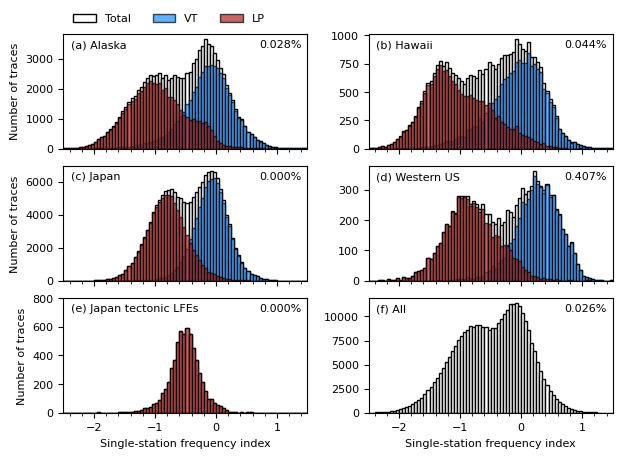

In [170]:
fig, axs = plt.subplots(3, 2, figsize=(18 * cm, 12.5 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = [
    "(a) Alaska",
    "(b) Hawaii",
    "(c) Japan",
    "(d) Western US",
    "(e) Japan tectonic LFEs",
    "(f) All",
]

extra_test_sets = [westernus, japan_tec_lp]

fts = 8
up_b = 1.5
lw_b = -2.5
bins = np.arange(lw_b, up_b + 0.01, 0.05)
for i in range(6):
    ax = axs.flat[i]
    label = labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = dataset.metadata[
            (dataset.metadata["trace_chunk"] == chunks[0])
            | (dataset.metadata["trace_chunk"] == chunks[1])
        ]
    elif i >= 3 and i < 5:
        current_df = extra_test_sets[i - 3].metadata
    else:
        current_df = pd.concat(
            [
                dataset.metadata,
                extra_test_sets[0].metadata,
                extra_test_sets[1].metadata,
            ],
            ignore_index=True,
        )

    freq_indices = current_df["trace_frequency_index"]
    # print(len(freq_indices))
    # freq_indices=freq_indices_df[(freq_indices_df["trace_chunk"]==chunks[0])|(freq_indices_df["trace_chunk"]==chunks[1])]["trace_frequency_index"]
    freq_indices_lp = current_df[current_df["source_type"] == "lp"][
        "trace_frequency_index"
    ]
    freq_indices_rg = current_df[current_df["source_type"] != "lp"][
        "trace_frequency_index"
    ]
    ax.hist(
        freq_indices,
        bins,
        density=False,
        color="white",
        edgecolor="black",
        label="Total",
    )
    if i < 5:
        ax.hist(
            freq_indices_rg,
            bins,
            density=False,
            color="dodgerblue",
            edgecolor="black",
            alpha=0.7,
            label="VT",
        )
        ax.hist(
            freq_indices_lp,
            bins,
            density=False,
            color="firebrick",
            edgecolor="black",
            alpha=0.7,
            label="LP",
        )
    ax.text(
        0.03,
        0.95,
        label,
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    out = len(freq_indices[(freq_indices > up_b) | (freq_indices < lw_b)]) / len(
        freq_indices
    )
    print(f"{out:e}")
    ax.text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.set_xlim([lw_b, up_b])

axs[0][0].set_ylabel("Number of traces", fontsize=fts)
axs[1][0].set_ylabel("Number of traces", fontsize=fts)
axs[2][0].set_ylabel("Number of traces", fontsize=fts)
axs[-1][0].set_xlabel("Single-station frequency index", fontsize=fts)
axs[-1][1].set_xlabel("Single-station frequency index", fontsize=fts)

axs[2][0].set_ylim([0, 800])

axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 1.0, 0.5, 0.1),
    frameon=False,
    fontsize=fts,
    ncols=3,
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/trace_FI_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/trace_FI_histogram.jpg",
    dpi=300,
    bbox_inches="tight",
)

-4.667948492281088 1.6273361702316074
1.281230e-04
-2.448048345595826 1.3477482530379676
0.000000e+00
-2.045824666156581 1.1955126312986517
0.000000e+00
-4.787927541635342 1.239009965703311
9.481669e-04
-1.6928608656847526 0.5963918205455377
0.000000e+00
-4.787927541635342 1.6273361702316074
9.225943e-05


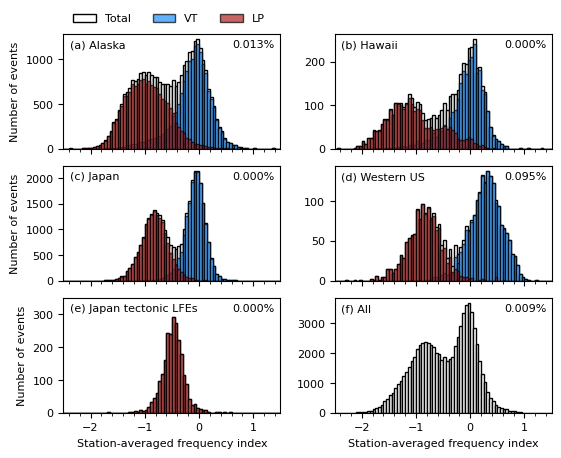

In [169]:
freq_indices_df1 = dataset.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)
fts = 8
fig, axs = plt.subplots(3, 2, figsize=(16 * cm, 12.5 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.15)
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = [
    "(a) Alaska",
    "(b) Hawaii",
    "(c) Japan",
    "(d) Western US",
    "(e) Japan tectonic LFEs",
    "(f) All",
]
up_b = 1.5
lw_b = -2.5
bins = np.arange(lw_b, up_b + 0.01, 0.05)
extra_test_sets = [westernus, japan_tec_lp]
extra_tests_fi_dfs = [
    x.metadata.drop_duplicates(subset="source_id", keep="first", inplace=False)
    for x in extra_test_sets
]

# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
for i in range(6):
    ax = axs.flat[i]
    label = labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = freq_indices_df1[
            (freq_indices_df1["trace_chunk"] == chunks[0])
            | (freq_indices_df1["trace_chunk"] == chunks[1])
        ]
    elif i >= 3 and i < 5:
        current_df = extra_tests_fi_dfs[i - 3]
    else:
        current_df = pd.concat(
            [freq_indices_df1, extra_tests_fi_dfs[0], extra_tests_fi_dfs[1]],
            ignore_index=True,
        )
    freq_indices = current_df["source_frequency_index"]
    print(min(freq_indices), max(freq_indices))
    # freq_indices=freq_indices_df1[(freq_indices_df1["trace_chunk"]==chunks[0])|(freq_indices_df1["trace_chunk"]==chunks[1])]["source_frequency_index"]
    freq_indices_lp = current_df[current_df["source_type"] == "lp"][
        "source_frequency_index"
    ]
    freq_indices_rg = current_df[current_df["source_type"] != "lp"][
        "source_frequency_index"
    ]
    ax.hist(
        freq_indices,
        bins,
        density=False,
        color="white",
        edgecolor="black",
        label="Total",
    )
    if i < 5:
        ax.hist(
            freq_indices_rg,
            bins,
            density=False,
            color="dodgerblue",
            edgecolor="black",
            alpha=0.7,
            label="VT",
        )
        ax.hist(
            freq_indices_lp,
            bins,
            density=False,
            color="firebrick",
            edgecolor="black",
            alpha=0.7,
            label="LP",
        )
    ax.text(
        0.03,
        0.95,
        label,
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    out = len(freq_indices[(freq_indices > up_b) | (freq_indices < lw_b)]) / len(
        freq_indices
    )
    print(f"{out:e}")
    ax.text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.set_xlim([lw_b, up_b])
# freq_indices=freq_indices_df1["source_frequency_index"]
# freq_indices_lp=freq_indices_df1[freq_indices_df1["source_type"]=="lp"]["source_frequency_index"]
# freq_indices_rg=freq_indices_df1[freq_indices_df1["source_type"]!="lp"]["source_frequency_index"]
# axs[1][1].hist(freq_indices,bins,density=False, color="white", edgecolor="black",label="Total");
# axs[1][1].hist(freq_indices_rg, bins,density=False, color="dodgerblue", edgecolor="black", alpha=0.8, label="VT");
# axs[1][1].hist(freq_indices_lp, bins,density=False, color="firebrick", edgecolor="black", alpha=0.8, label="LP");
# axs[1][1].text(
#             0.03,
#             0.95,
#             "(d) All",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=axs[1][1].transAxes,
#             fontsize=fts,
#             # weight="bold",
#             color="black",
#         )
# axs[1][1].tick_params(labelsize=10)
# axs[1][1].xaxis.set_minor_locator(MultipleLocator(0.2))
axs[0][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)
axs[2][0].set_ylabel("Number of events", fontsize=fts)
axs[-1][0].set_xlabel("Station-averaged frequency index", fontsize=fts)
axs[-1][1].set_xlabel("Station-averaged frequency index", fontsize=fts)

axs[-1][0].set_ylim([0, 350])

axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 1.0, 0.5, 0.1),
    frameon=False,
    fontsize=fts,
    ncols=3,
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/event_FI_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/event_FI_histogram.jpg",
    dpi=300,
    bbox_inches="tight",
)

1.7326133191762194
-5.279731596357192
3.981596e-03
0.6431950141187742
-1.947114533489873
0.000000e+00
1.239009965703311
-4.787927541635342
9.481669e-04
0.5963918205455377
-1.6928608656847526
0.000000e+00


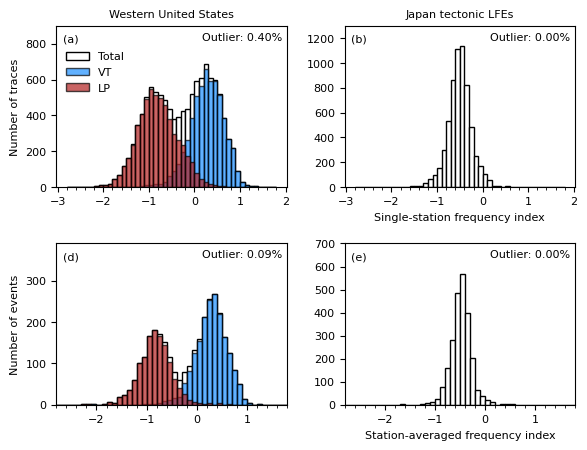

In [49]:
extra_test_sets = [westernus, japan_tec_lp]
labels = ["(a)", "(b)", "(c)"]
cm = 1 / 2.54
fig, axs = plt.subplots(2, 2, figsize=(17 * cm, 12.5 * cm), sharex="row")
up_b = 1.8
lw_b = -2.8
bins = np.arange(lw_b, up_b + 0.01, 0.1)

fts = 8
plt.subplots_adjust(wspace=0.25, hspace=0.35)
for i in range(2):
    ax = axs[0][i]
    freq_indices_df = extra_test_sets[i].metadata
    freq_indices = freq_indices_df["trace_frequency_index"]
    print(max(freq_indices))
    print(min(freq_indices))

    freq_indices_lp = freq_indices_df[freq_indices_df["source_type"] == "lp"][
        "trace_frequency_index"
    ]
    freq_indices_rg = freq_indices_df[freq_indices_df["source_type"] != "lp"][
        "trace_frequency_index"
    ]

    ax.hist(
        freq_indices,
        bins,
        density=False,
        color="white",
        edgecolor="black",
        label="Total",
    )
    if i == 0:
        ax.hist(
            freq_indices_rg,
            bins,
            density=False,
            color="dodgerblue",
            edgecolor="black",
            alpha=0.7,
            label="VT",
        )
        ax.hist(
            freq_indices_lp,
            bins,
            density=False,
            color="firebrick",
            edgecolor="black",
            alpha=0.7,
            label="LP",
        )
    ax.text(
        0.03,
        0.95,
        labels[i],
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    out = len(freq_indices[(freq_indices > up_b) | (freq_indices < lw_b)]) / len(
        freq_indices
    )
    print(f"{out:e}")
    ax.text(
        0.98,
        0.96,
        f"""Outlier: {out*100:>4.2f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
axs[0][1].set_xlabel("Single-station frequency index", fontsize=fts)

labels = ["(d)", "(e)", "(f)"]
for i in range(2):
    ax = axs[1][i]
    freq_indices_df = extra_test_sets[i].metadata.drop_duplicates(
        subset="source_id", keep="first", inplace=False
    )
    freq_indices = freq_indices_df["source_frequency_index"]
    freq_indices_lp = freq_indices_df[freq_indices_df["source_type"] == "lp"][
        "source_frequency_index"
    ]
    freq_indices_rg = freq_indices_df[freq_indices_df["source_type"] != "lp"][
        "source_frequency_index"
    ]
    print(max(freq_indices))
    print(min(freq_indices))

    ax.hist(freq_indices, bins, density=False, color="white", edgecolor="black")
    if i == 0:
        ax.hist(
            freq_indices_rg,
            bins,
            density=False,
            color="dodgerblue",
            edgecolor="black",
            alpha=0.7,
            label="VT",
        )
        ax.hist(
            freq_indices_lp,
            bins,
            density=False,
            color="firebrick",
            edgecolor="black",
            alpha=0.7,
            label="LP",
        )
    ax.text(
        0.03,
        0.95,
        labels[i],
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    out = len(freq_indices[(freq_indices > up_b) | (freq_indices < lw_b)]) / len(
        freq_indices
    )
    print(f"{out:e}")
    ax.text(
        0.98,
        0.96,
        f"""Outlier: {out*100:>4.2f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))

    ax.set_xlim([lw_b, up_b])


axs[1][1].set_xlabel("Station-averaged frequency index", fontsize=fts)

axs[0][0].set_ylabel("Number of traces", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)
axs[0][0].set_title("Western United States", fontsize=fts)
# axs[0][0].set_title("Northern California", fontsize=fts)
# axs[0][1].set_title("Cascade Volcanoes", fontsize=fts)
axs[0][1].set_title("Japan tectonic LFEs", fontsize=fts)

axs[0][0].set_ylim([0, 900])
axs[1][0].set_ylim([0, 390])

# axs[0][1].set_ylim([0, 120])
# axs[1][1].set_ylim([0, 40])

axs[0][1].set_ylim([0, 1300])
axs[1][1].set_ylim([0, 700])

axs[0][0].legend(
    loc="upper left", bbox_to_anchor=(0.0, 0.35, 0.4, 0.55), frameon=False, fontsize=fts
)
# axs[0][0].legend(loc="center left", frameon=False, fontsize=fts)
# plt.savefig(
#     "/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus_jp_tec_FIs.jpg",
#     dpi=600,
#     bbox_inches="tight",
# )
# plt.savefig(
#     "/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus_jp_tec_FIs.pdf",
#     dpi=600,
#     bbox_inches="tight",
# )

Signal-to-noise ratio

0
-18.427903812376403 82.55854371088981
-15.297570616972965 87.61525396407002
-10.710959685378288 87.93499736720797
-18.427903812376403 82.55854371088981
0
-8.335501116753177 25.236206250121633
-10.23951663432182 29.23732492851218
-8.485480719320291 28.29917940298416
-6.077731475681941 27.485581434259498


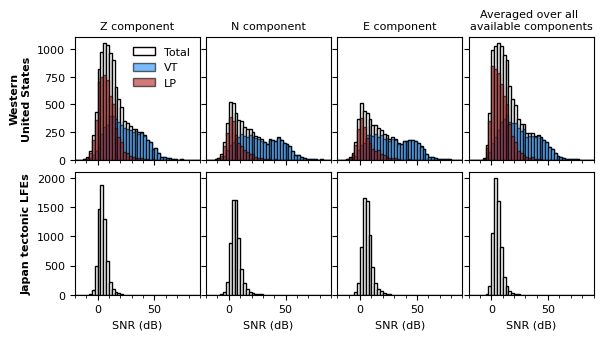

In [90]:
japan_teclp_snr_zne = japan_tec_lp.metadata["trace_snr_db"].apply(str2list)
# japan_teclp_snr_zne = ncedc_vt.metadata["trace_snr_db"].apply(str2list)
westernus_snr_zne = westernus.metadata["trace_snr_db"].apply(str2list)
westernus_vt_snr_zne = westernus_vt.metadata["trace_snr_db"].apply(str2list)
westernus_lp_snr_zne = westernus_lp.metadata["trace_snr_db"].apply(str2list)
# cascade_snr_zne = cascade.metadata["trace_snr_db"].apply(str2list)
# cascade_vt_snr_zne = cascade_vt.metadata["trace_snr_db"].apply(str2list)
# cascade_lp_snr_zne = cascade_lp.metadata["trace_snr_db"].apply(str2list)
snr_up_b = 90
snr_lw_b = -20
bins = np.arange(snr_lw_b, snr_up_b + 0.1, 2.5)
fig, axs = plt.subplots(2, 4, figsize=(17 * cm, 8.5 * cm), sharex=True, sharey="row")
plt.subplots_adjust(hspace=0.1, wspace=0.05)
fts = 8
for i, (snr_zne, label) in enumerate(
    zip(
        [westernus_snr_zne, japan_teclp_snr_zne],
        ["Western\nUnited States", "Japan tectonic LFEs"],
    )
):
    # snr_z=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    # snr_n=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    # snr_e=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    component_order = ["Z", "N", "E"]
    na_snrs = snr_zne[snr_zne.apply(lambda x: np.all(pd.isna(np.array(x))))]
    print(len(na_snrs))
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    for j in range(4):
        if j < 3:
            snr_j = snr_zne.apply(lambda x: x[j])
            snr_j = snr_j[pd.notna(snr_j)]
        else:
            snr_j = snr_zne.apply(np.nanmean)
            snr_j = snr_j[pd.notna(snr_j)]

        print(np.min(snr_j), np.max(snr_j))
        axs[i][j].hist(
            snr_j, bins=bins, color="white", edgecolor="black", log=False, label="Total"
        )
        # axs[i][j].axvline(np.median(snr_j),color="dodgerblue")
        axs[i][j].tick_params(labelsize=fts)
        axs[i][j].xaxis.set_minor_locator(MultipleLocator(10))
        out = len(snr_j[(snr_j > snr_up_b) | (snr_j < snr_lw_b)]) / len(snr_j)
        # print(f"{out:e}")
        # axs[i][j].text(
        #     0.975,
        #     0.95,
        #     f"""{out*100:>6.4f}%""",
        #     verticalalignment="top",
        #     horizontalalignment="right",
        #     transform=axs[i][j].transAxes,
        #     fontsize=fts,
        # )
        axs[i][j].set_xlim(snr_lw_b, snr_up_b)

    for j in range(3):
        axs[-1][j].set_xlabel(f"SNR (dB)", fontsize=fts)
        axs[0][j].set_title(f"{component_order[j]} component", fontsize=fts)
    axs[-1][3].set_xlabel(f"SNR (dB)", fontsize=fts)
    axs[0][3].set_title(f"Averaged over all \navailable components", fontsize=fts)
    axs[i][0].set_ylabel(label, fontsize=fts, weight="bold")

for i, (lp_snr_zne, vt_snr_zne) in enumerate(
    zip([westernus_lp_snr_zne], [westernus_vt_snr_zne])
):
    for j in range(4):
        if j < 3:
            snr_lp_j = lp_snr_zne.apply(lambda x: x[j])
            snr_lp_j = snr_lp_j[pd.notna(snr_lp_j)]

            snr_vt_j = vt_snr_zne.apply(lambda x: x[j])
            snr_vt_j = snr_vt_j[pd.notna(snr_vt_j)]
        else:
            snr_lp_j = lp_snr_zne.apply(np.nanmean)
            snr_lp_j = snr_lp_j[pd.notna(snr_lp_j)]
            snr_vt_j = vt_snr_zne.apply(np.nanmean)
            snr_vt_j = snr_vt_j[pd.notna(snr_vt_j)]

        axs[i][j].hist(
            snr_vt_j,
            bins=bins,
            color="dodgerblue",
            edgecolor="black",
            log=False,
            alpha=0.6,
            label="VT",
        )
        axs[i][j].hist(
            snr_lp_j,
            bins=bins,
            color="firebrick",
            edgecolor="black",
            log=False,
            alpha=0.6,
            label="LP",
        )
axs[0][0].legend(loc="upper right", frameon=False, fontsize=fts)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus_jp_tec_SNR.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/westernus_jp_tec_SNR.jpg",
    dpi=300,
    bbox_inches="tight",
)

In [173]:
total_snr_zne_lp

0                             [8.089339552166457, nan, nan]
1         [12.314789945589508, 16.11889869690067, 9.4106...
2         [19.0045297959485, 12.128193929878003, 14.4137...
3         [16.50637382103238, 5.883320034987504, 12.7329...
4         [22.719516448098705, 10.604068714832064, 16.20...
                                ...                        
231554    [5.4180400611748585, 9.4692248350453, 10.85849...
231555    [8.023079538850762, 13.789222068325437, 9.1628...
231556    [11.689864758630183, 11.523587200542542, 9.620...
231557    [6.617064884533636, 6.87958872011687, 7.094960...
231558    [9.209302924713022, 10.115380113574863, 6.2812...
Name: trace_snr_db, Length: 151431, dtype: object

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
0
-18.427903812376403 82.55854371088981
-15.297570616972965 87.61525396407002
-10.710959685378288 87.93499736720797
-18.427903812376403 82.55854371088981
0
-8.335501116753177 25.236206250121633
-10.23951663432182 29.23732492851218
-8.485480719320291 28.29917940298416
-6.077731475681941 27.485581434259498
6
-86.14632491126565 83.27960932540807
-94.1484478317025 87.61525396407002
-29.209560898630503 89.59201551441652
-60.10486204865622 85.16601837881369


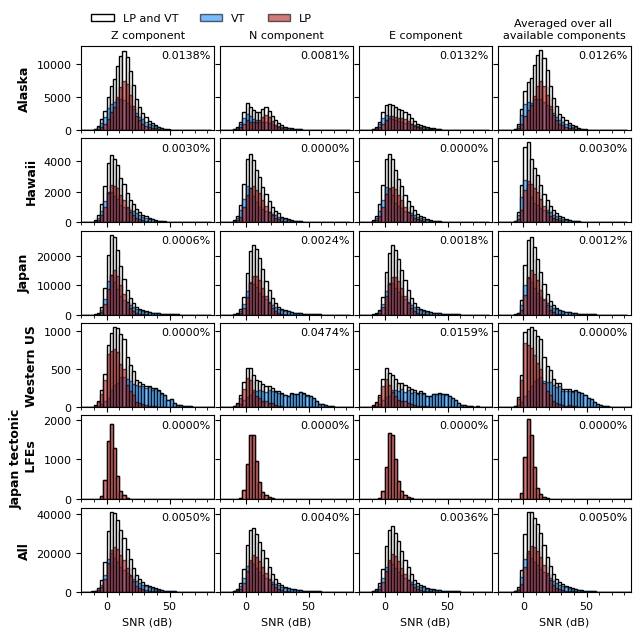

In [184]:
snr_up_b = 85
snr_lw_b = -20
bins = np.arange(snr_lw_b, snr_up_b, 2.5)
fig, axs = plt.subplots(6, 4, figsize=(18 * cm, 18 * cm), sharex=True, sharey="row")
plt.subplots_adjust(hspace=0.1, wspace=0.05)
fts = 8
for i, (snr_zne, snr_zne_lp, snr_zne_vt, label) in enumerate(
    zip(
        [alaska_snr_zne, hawaii_snr_zne, japan_snr_zne],  # total_snr_zne
        [alaska_snr_zne_lp, hawaii_snr_zne_lp, japan_snr_zne_lp],  # total_snr_zne_lp
        [alaska_snr_zne_vt, hawaii_snr_zne_vt, japan_snr_zne_vt],  # total_snr_zne_vt
        ["Alaska", "Hawaii", "Japan", "Total"],
    )
):
    # snr_z=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    # snr_n=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    # snr_e=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    component_order = ["Z", "N", "E"]
    na_snrs = snr_zne[snr_zne.apply(lambda x: np.all(pd.isna(np.array(x))))]
    # print(len(na_snrs))
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr_zne_lp = snr_zne_lp[
        snr_zne_lp.apply(lambda x: not np.all(pd.isna(np.array(x))))
    ]
    snr_zne_vt = snr_zne_vt[
        snr_zne_vt.apply(lambda x: not np.all(pd.isna(np.array(x))))
    ]
    for j in range(4):
        print(i, j)
        if j < 3:
            snr_j = snr_zne.apply(lambda x: x[j])
            snr_j = snr_j[pd.notna(snr_j)]

            snr_lp_j = snr_zne_lp.apply(lambda x: x[j])
            snr_lp_j = snr_lp_j[pd.notna(snr_lp_j)]

            snr_vt_j = snr_zne_vt.apply(lambda x: x[j])
            snr_vt_j = snr_vt_j[pd.notna(snr_vt_j)]
        else:
            snr_j = snr_zne.apply(np.nanmean)
            snr_j = snr_j[pd.notna(snr_j)]

            snr_lp_j = snr_zne_lp.apply(np.nanmean)
            snr_lp_j = snr_lp_j[pd.notna(snr_lp_j)]

            snr_vt_j = snr_zne_vt.apply(np.nanmean)
            snr_vt_j = snr_vt_j[pd.notna(snr_vt_j)]

        # print(np.min(snr_j),np.max(snr_j))
        axs[i][j].hist(
            snr_j,
            bins=bins,
            color="white",
            edgecolor="black",
            log=False,
            label="LP and VT",
        )

        axs[i][j].hist(
            snr_vt_j,
            bins=bins,
            color="dodgerblue",
            edgecolor="black",
            log=False,
            alpha=0.6,
            label="VT",
        )
        axs[i][j].hist(
            snr_lp_j,
            bins=bins,
            color="firebrick",
            edgecolor="black",
            log=False,
            alpha=0.6,
            label="LP",
        )

        # axs[i][j].axvline(np.median(snr_j),color="dodgerblue")
        axs[i][j].tick_params(labelsize=fts)
        axs[i][j].xaxis.set_minor_locator(MultipleLocator(10))
        out = len(snr_j[(snr_j > snr_up_b) | (snr_j < snr_lw_b)]) / len(snr_j)
        # if j==2 and (i==1 or i==3):
        #     print(i,len(snr_j[(snr_j>snr_up_b)|(snr_j<snr_lw_b)]))
        # if i==1:
        #     print(j,"len",len(snr_j))
        # print(f"{out:e}")
        axs[i][j].text(
            0.975,
            0.95,
            f"""{out*100:>6.4f}%""",
            verticalalignment="top",
            horizontalalignment="right",
            transform=axs[i][j].transAxes,
            fontsize=fts,
        )
        axs[i][j].set_xlim(snr_lw_b, snr_up_b)

    for j in range(3):
        # axs[-1][j].set_xlabel(f"SNR (dB)", fontsize=fts)
        axs[0][j].set_title(f"{component_order[j]} component", fontsize=fts)
    # axs[-1][3].set_xlabel(f"SNR (dB)", fontsize=fts)
    axs[0][3].set_title(f"Averaged over all \navailable components", fontsize=fts)
    axs[i][0].set_ylabel(label, fontsize=fts + 1, weight="bold")
# axs[0].hist(alaska_snr,bins=bins,color="dodgerblue", edgecolor="black");
# axs[1].hist(hawaii_snr,bins=bins,color="dodgerblue", edgecolor="black");
# axs[2].hist(japan_snr,bins=bins,color="dodgerblue", edgecolor="black");
# axs[3].hist(total_snr,bins=bins,color="dodgerblue", edgecolor="black");

# extra test sets
japan_teclp_snr_zne = japan_tec_lp.metadata["trace_snr_db"].apply(str2list)
# japan_teclp_snr_zne = ncedc_vt.metadata["trace_snr_db"].apply(str2list)
westernus_snr_zne = westernus.metadata["trace_snr_db"].apply(str2list)
westernus_vt_snr_zne = westernus_vt.metadata["trace_snr_db"].apply(str2list)
westernus_lp_snr_zne = westernus_lp.metadata["trace_snr_db"].apply(str2list)
# all
total_snr_zne_plus_extra_tests = pd.concat(
    [total_snr_zne, westernus_snr_zne, japan_teclp_snr_zne], ignore_index=True
)
total_snr_zne_lp_plus_extra_tests = pd.concat(
    [total_snr_zne_lp, westernus_lp_snr_zne, japan_teclp_snr_zne], ignore_index=True
)

total_snr_zne_vt_plus_extra_tests = pd.concat(
    [total_snr_zne_vt, westernus_vt_snr_zne], ignore_index=True
)

bins = np.arange(snr_lw_b, snr_up_b + 0.1, 2.5)
for i, (snr_zne, label) in enumerate(
    zip(
        [westernus_snr_zne, japan_teclp_snr_zne, total_snr_zne_plus_extra_tests],
        ["Western US", "Japan tectonic\n LFEs", "All"],
    )
):
    # snr_z=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    # snr_n=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    # snr_e=snr_zne[pd.notna(snr_zne)].apply(lambda x: x[0])
    component_order = ["Z", "N", "E"]
    na_snrs = snr_zne[snr_zne.apply(lambda x: np.all(pd.isna(np.array(x))))]
    print(len(na_snrs))
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    for j in range(4):
        if j < 3:
            snr_j = snr_zne.apply(lambda x: x[j])
            snr_j = snr_j[pd.notna(snr_j)]
        else:
            snr_j = snr_zne.apply(np.nanmean)
            snr_j = snr_j[pd.notna(snr_j)]

        print(np.min(snr_j), np.max(snr_j))
        axs[i + 3][j].hist(
            snr_j, bins=bins, color="white", edgecolor="black", log=False, label="Total"
        )
        # axs[i][j].axvline(np.median(snr_j),color="dodgerblue")
        axs[i + 3][j].tick_params(labelsize=fts)
        axs[i + 3][j].xaxis.set_minor_locator(MultipleLocator(10))
        out = len(snr_j[(snr_j > snr_up_b) | (snr_j < snr_lw_b)]) / len(snr_j)
        axs[i + 3][j].set_xlim(snr_lw_b, snr_up_b)
        axs[i + 3][j].text(
            0.975,
            0.95,
            f"""{out*100:>6.4f}%""",
            verticalalignment="top",
            horizontalalignment="right",
            transform=axs[i + 3][j].transAxes,
            fontsize=fts,
        )
    for j in range(3):
        axs[-1][j].set_xlabel(f"SNR (dB)", fontsize=fts)
        # axs[0][j].set_title(f"{component_order[j]} component", fontsize=fts)
    axs[-1][3].set_xlabel(f"SNR (dB)", fontsize=fts)
    # axs[0][3].set_title(f"Averaged over all \navailable components", fontsize=fts)
    axs[i + 3][0].set_ylabel(label, fontsize=fts + 1, weight="bold")

for i, (lp_snr_zne, vt_snr_zne) in enumerate(
    zip(
        [westernus_lp_snr_zne, japan_teclp_snr_zne, total_snr_zne_lp_plus_extra_tests],
        [westernus_vt_snr_zne, None, total_snr_zne_vt_plus_extra_tests],
    )
):
    lp_snr_zne = lp_snr_zne[
        lp_snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))
    ]
    if vt_snr_zne is not None:
        vt_snr_zne = vt_snr_zne[
            vt_snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))
        ]
    for j in range(4):
        if j < 3:
            snr_lp_j = lp_snr_zne.apply(lambda x: x[j])
            snr_lp_j = snr_lp_j[pd.notna(snr_lp_j)]
            if vt_snr_zne is not None:
                snr_vt_j = vt_snr_zne.apply(lambda x: x[j])
                snr_vt_j = snr_vt_j[pd.notna(snr_vt_j)]
            else:
                snr_vt_j = None
        else:
            snr_lp_j = lp_snr_zne.apply(np.nanmean)
            snr_lp_j = snr_lp_j[pd.notna(snr_lp_j)]
            if vt_snr_zne is not None:
                snr_vt_j = vt_snr_zne.apply(np.nanmean)
                snr_vt_j = snr_vt_j[pd.notna(snr_vt_j)]
            else:
                snr_vt_j = None
        if snr_vt_j is not None:
            axs[i + 3][j].hist(
                snr_vt_j,
                bins=bins,
                color="dodgerblue",
                edgecolor="black",
                log=False,
                alpha=0.6,
                label="VT",
            )
        axs[i + 3][j].hist(
            snr_lp_j,
            bins=bins,
            color="firebrick",
            edgecolor="black",
            log=False,
            alpha=0.6,
            label="LP",
        )


axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 1.15, 1.5, 0.25),
    frameon=False,
    fontsize=fts,
    ncols=3,
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/SNR.pdf", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/SNR.jpg", dpi=600, bbox_inches="tight"
)

In [58]:
len(westernus_lp_snr_zne) + len(westernus_lp_snr_zne) == len(westernus_snr_zne)

True

# Epicentral distance

0
0
0
0 102841
0 33720
0 166527


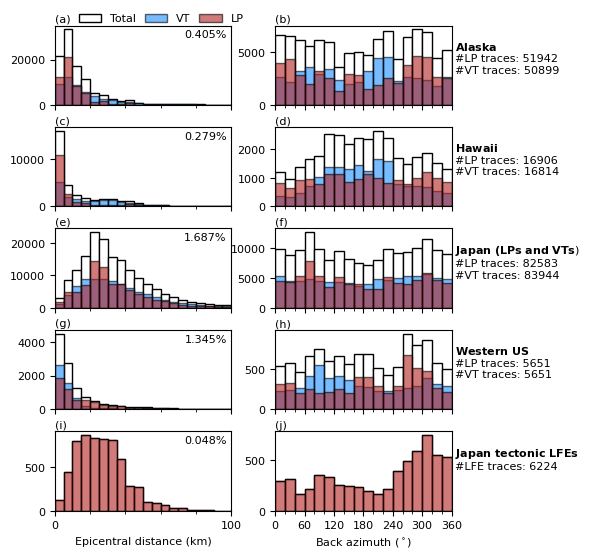

In [307]:
epidist_and_azimuth_df = data_eq.metadata

fig, axs = plt.subplots(5, 2, figsize=(13 * cm, 16 * cm), sharex="col")
plt.subplots_adjust(wspace=0.25, hspace=0.28)

trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
labels = ["(a)", "(c)", "(e)", "(g)", "(i)", "(k)", "(m)"]
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
bins = np.arange(0, 100 + 1, 5)
for i in range(3):
    ax = axs[i][0]

    label = labels[i]

    if i < 3:
        chunks = trace_chunks[i]
        current_df = epidist_and_azimuth_df[
            (epidist_and_azimuth_df["trace_chunk"] == chunks[0])
            | (epidist_and_azimuth_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = epidist_and_azimuth_df
    print(len(current_df[pd.isna(current_df["station_epicentral_distance_m"])]))
    ax.hist(
        current_df["station_epicentral_distance_m"] / 1000,
        bins=bins,
        color="white",
        edgecolor="black",
        log=False,
        label="Total",
    )
    ax.hist(
        current_df[current_df["source_type"] != "lp"]["station_epicentral_distance_m"]
        / 1000,
        bins=bins,
        color="dodgerblue",
        edgecolor="black",
        log=False,
        alpha=0.6,
        label="VT",
    )
    ax.hist(
        current_df[current_df["source_type"] == "lp"]["station_epicentral_distance_m"]
        / 1000,
        bins=bins,
        color="firebrick",
        edgecolor="black",
        log=False,
        alpha=0.6,
        label="LP",
    )
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
    # ax.yaxis.set_major_locator(LogLocator(10,(1,2,3,4,5)))
    ax.set_xlim([0, 100])
    # ax.set_ylabel("Number of traces", fontsize=fts)
    ax.tick_params(labelsize=fts)

    out = len(
        current_df[current_df["station_epicentral_distance_m"] / 1000 > 100]
    ) / len(current_df)
    ax.text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )

for i, current_df in enumerate([westernus.metadata, japan_tec_lp.metadata]):
    ax = axs[i + 3][0]
    label = labels[i + 3]
    ax.hist(
        current_df["station_epicentral_distance_m"] / 1000,
        bins=bins,
        color="white",
        edgecolor="black",
        log=False,
    )
    if i == 0:
        ax.hist(
            current_df[current_df["source_type"] != "lp"][
                "station_epicentral_distance_m"
            ]
            / 1000,
            bins=bins,
            color="dodgerblue",
            edgecolor="black",
            log=False,
            alpha=0.6,
        )
    ax.hist(
        current_df[current_df["source_type"] == "lp"]["station_epicentral_distance_m"]
        / 1000,
        bins=bins,
        color="firebrick",
        edgecolor="black",
        log=False,
        alpha=0.6,
    )

    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.set_xlim([0, 100])
    # ax.set_ylabel("Number of traces", fontsize=fts)
    ax.tick_params(labelsize=fts)
    out = len(
        current_df[current_df["station_epicentral_distance_m"] / 1000 > 100]
    ) / len(current_df)
    ax.text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )

labels = ["(b)", "(d)", "(f)", "(h)", "(j)", "(l)"]
ak_nlp = len(
    epidist_and_azimuth_df[(epidist_and_azimuth_df["trace_chunk"] == "_ak_lp")]
)
ak_nvt = len(
    epidist_and_azimuth_df[(epidist_and_azimuth_df["trace_chunk"] == "_ak_rg")]
)
hw_nlp = len(
    epidist_and_azimuth_df[(epidist_and_azimuth_df["trace_chunk"] == "_hw12t21_lp")]
)
hw_nvt = len(
    epidist_and_azimuth_df[(epidist_and_azimuth_df["trace_chunk"] == "_hw12t21_rg")]
)
jp_nlp = len(
    epidist_and_azimuth_df[(epidist_and_azimuth_df["trace_chunk"] == "_japan_vol_lp")]
)
jp_nvt = len(
    epidist_and_azimuth_df[(epidist_and_azimuth_df["trace_chunk"] == "_japan_vt")]
)
nc_nlp = len(ncedc.metadata[ncedc.metadata["source_type"] == "lp"])
nc_nvt = len(ncedc.metadata[ncedc.metadata["source_type"] != "lp"])
cc_nlp = len(cascade.metadata[cascade.metadata["source_type"] == "lp"])
cc_nvt = len(cascade.metadata[cascade.metadata["source_type"] != "lp"])
jp_nlfe = len(japan_tec_lp.metadata)
region_labels = [
    r"$\bf{Alaska}$" + f"\n#LP traces: {ak_nlp}\n#VT traces: {ak_nvt}",
    r"$\bf{Hawaii}$" + f"\n#LP traces: {hw_nlp}\n#VT traces: {hw_nvt}",
    r"$\bf{Japan}$ $\bf{(LPs}$ $\bf{and}$ $\bf{VTs}$)"
    + f"\n#LP traces: {jp_nlp}\n#VT traces: {jp_nvt}",
    # r"$\bf{Northern}$ $\bf{California}$"
    # + f"\n#LP traces: {nc_nlp}\n#VT traces: {nc_nvt}",
    r"$\bf{Western}$ $\bf{US}$"
    + f"\n#LP traces: {nc_nlp+cc_nlp}\n#VT traces: {nc_nvt+cc_nvt}",
    # r"$\bf{Cascade}$ $\bf{volcanoes}$"
    # + f"\n#LP traces: {cc_nlp}\n#VT traces: {cc_nvt}",
    r"$\bf{Japan}$ $\bf{tectonic}$ $\bf{LFEs}$" + f"\n#LFE traces: {jp_nlfe}",
]
for i in range(3):
    ax = axs[i][1]
    label = labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = epidist_and_azimuth_df[
            (epidist_and_azimuth_df["trace_chunk"] == chunks[0])
            | (epidist_and_azimuth_df["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = epidist_and_azimuth_df
    print(
        len(current_df[pd.isna(current_df["path_back_azimuth_deg"])]),
        len(current_df[pd.notna(current_df["path_back_azimuth_deg"])]),
    )
    ax.hist(
        current_df["path_back_azimuth_deg"],
        bins=np.arange(0, 360 + 1, 20),
        color="white",
        edgecolor="black",
        log=False,
    )
    ax.hist(
        current_df[current_df["source_type"] != "lp"]["path_back_azimuth_deg"],
        bins=np.arange(0, 360 + 1, 20),
        color="dodgerblue",
        edgecolor="black",
        log=False,
        alpha=0.6,
    )
    ax.hist(
        current_df[current_df["source_type"] == "lp"]["path_back_azimuth_deg"],
        bins=np.arange(0, 360 + 1, 20),
        color="firebrick",
        edgecolor="black",
        log=False,
        alpha=0.6,
    )

    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.text(
        1.02,
        0.82,
        region_labels[i],
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.tick_params(labelsize=fts)
    ax.set_xlim([0, 360])
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
for i, current_df in enumerate(
    [westernus.metadata, japan_tec_lp.metadata]  # cascade.metadata,
):
    ax = axs[i + 3][1]
    label = labels[i + 3]
    ax.hist(
        current_df["path_back_azimuth_deg"],
        bins=np.arange(0, 360 + 1, 20),
        color="white",
        edgecolor="black",
        log=False,
    )
    if i == 0:
        ax.hist(
            current_df[current_df["source_type"] != "lp"]["path_back_azimuth_deg"],
            bins=np.arange(0, 360 + 1, 20),
            color="dodgerblue",
            edgecolor="black",
            log=False,
            alpha=0.6,
        )
    ax.hist(
        current_df[current_df["source_type"] == "lp"]["path_back_azimuth_deg"],
        bins=np.arange(0, 360 + 1, 20),
        color="firebrick",
        edgecolor="black",
        log=False,
        alpha=0.6,
    )
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.text(
        1.02,
        0.82,
        region_labels[i + 3],
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    ax.tick_params(labelsize=fts)
    ax.set_xlim([0, 360])
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
axs[-1][0].set_xlabel("Epicentral distance (km)", fontsize=fts)
axs[-1][1].set_xlabel(r"Back azimuth ($^\circ$)", fontsize=fts)
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(0.08, 0.9, 1.5, 0.2),
    frameon=False,
    fontsize=fts,
    ncols=3,
    columnspacing=0.8,
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/epic_dist_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)

# Depth

278.0
0 0
-3.2 173.99
0 0
-3.79 57.08
0 0
0.0 278.0


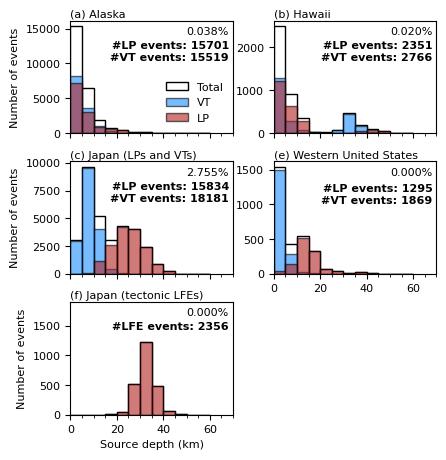

In [301]:
bins = np.arange(0, 60 + 1, 5)
fts = 8
depth_df = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)
depth_df_lp = depth_df[depth_df["source_type"] == "lp"]
depth_df_vt = depth_df[depth_df["source_type"] != "lp"]

print(np.max(depth_df_vt["source_depth_km"]))
fig, axs = plt.subplots(3, 2, figsize=(12 * cm, 13 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.25)

trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
ak_nlp = len(depth_df[(depth_df["trace_chunk"] == "_ak_lp")])
ak_nvt = len(depth_df[(depth_df["trace_chunk"] == "_ak_rg")])
hw_nlp = len(depth_df[(depth_df["trace_chunk"] == "_hw12t21_lp")])
hw_nvt = len(depth_df[(depth_df["trace_chunk"] == "_hw12t21_rg")])
jp_nlp = len(depth_df[(depth_df["trace_chunk"] == "_japan_vol_lp")])
jp_nvt = len(depth_df[(depth_df["trace_chunk"] == "_japan_vt")])
wu_nlp = len(
    westernus.metadata[westernus.metadata["source_type"] == "lp"]
    .drop_duplicates(subset="source_id", keep="first", inplace=False)
    .copy()
)
wu_nvt = len(
    westernus.metadata[westernus.metadata["source_type"] != "lp"]
    .drop_duplicates(subset="source_id", keep="first", inplace=False)
    .copy()
)
# cc_nlp = len(
#     cascade.metadata[cascade.metadata["source_type"] == "lp"]
#     .drop_duplicates(subset="source_id", keep="first", inplace=False)
#     .copy()
# )
# cc_nvt = len(
#     cascade.metadata[cascade.metadata["source_type"] != "lp"]
#     .drop_duplicates(subset="source_id", keep="first", inplace=False)
#     .copy()
# )
jp_nlfe = len(
    japan_tec_lp.metadata.drop_duplicates(
        subset="source_id", keep="first", inplace=False
    ).copy()
)
labels = [
    "(a) Alaska",
    "(b) Hawaii",
    "(c) Japan (LPs and VTs)",
    "(e) Western United States",
    "(f) Japan (tectonic LFEs)",
]
n_lps = [ak_nlp, hw_nlp, jp_nlp, wu_nlp]
n_vts = [ak_nvt, hw_nvt, jp_nvt, wu_nvt]
# for ax,chunks,label in zip([axs[0][0],axs[0][1],axs[1][0]],trace_chunks,labels):
# bins=np.arange(0,300+1,10)
for i in range(3):
    ax = axs.flat[i]

    label = labels[i]

    if i < 3:
        chunks = trace_chunks[i]
        current_df = depth_df[
            (depth_df["trace_chunk"] == chunks[0])
            | (depth_df["trace_chunk"] == chunks[1])
        ]
        current_df_vt = depth_df_vt[
            (depth_df_vt["trace_chunk"] == chunks[0])
            | (depth_df_vt["trace_chunk"] == chunks[1])
        ]
        current_df_lp = depth_df_lp[
            (depth_df_lp["trace_chunk"] == chunks[0])
            | (depth_df_lp["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = depth_df
        current_df_vt = depth_df_vt
        current_df_lp = depth_df_lp
    print(
        len(current_df_vt[pd.isna(current_df_vt["source_depth_km"])]),
        len(current_df_lp[pd.isna(current_df_lp["source_depth_km"])]),
    )
    print(min(current_df_vt["source_depth_km"]), max(current_df_vt["source_depth_km"]))
    ax.hist(
        current_df["source_depth_km"],
        bins=bins,
        color="white",
        edgecolor="black",
        label="Total",
    )
    # ax.hist(current_df_lp["source_depth_km"],bins=bins,color="blue", edgecolor="black")
    # ax.hist(
    #     [current_df_vt["source_depth_km"], current_df_lp["source_depth_km"]],
    #     bins=bins,
    #     color=["dodgerblue", "firebrick"],
    #     edgecolor="black",
    #     stacked=True,
    #     linewidth=1,
    #     label=["Regular earthquakes", "LP earthquakes"],
    # )
    ax.hist(
        current_df_vt["source_depth_km"],
        bins=bins,
        color="dodgerblue",
        edgecolor="black",
        label="VT",
        alpha=0.6,
    )
    ax.hist(
        current_df_lp["source_depth_km"],
        bins=bins,
        color="firebrick",
        edgecolor="black",
        label="LP",
        alpha=0.6,
    )

    # ax.hist(current_df_lp["source_depth_km"],bins=bins,color="firebrick", edgecolor="black",log=False,alpha=0.5,stacked=True)
    # ax.hist(current_df_vt["source_depth_km"],bins=bins,color="dodgerblue", edgecolor="black",log=False,alpha=0.5,stacked=True)

    ax.text(
        0.0,
        1.01,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    out = len(current_df[current_df["source_depth_km"] > 60]) / len(current_df)
    ax.text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )

    ax.text(
        0.975,
        0.82,
        f"""#LP events: {n_lps[i]}\n#VT events: {n_vts[i]}""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
        weight="bold",
    )
    ax.set_xlim([min(bins), max(bins)])
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
for i, current_df in enumerate([westernus.metadata, japan_tec_lp.metadata]):
    current_df = current_df.drop_duplicates(
        subset="source_id", keep="first", inplace=False
    ).copy()
    ax = axs.flat[3 + i]
    label = labels[3 + i]
    ax.hist(
        current_df["source_depth_km"],
        bins=bins,
        color="white",
        edgecolor="black",
        label="Total",
    )
    if i == 0:
        ax.hist(
            current_df[current_df["source_type"] != "lp"]["source_depth_km"],
            bins=bins,
            color="dodgerblue",
            edgecolor="black",
            label="VT",
            alpha=0.6,
        )
    ax.hist(
        current_df[current_df["source_type"] == "lp"]["source_depth_km"],
        bins=bins,
        color="firebrick",
        edgecolor="black",
        label="LP",
        alpha=0.6,
    )
    ax.text(
        0.0,
        1.01,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
    if i == 0:
        ax.text(
            0.975,
            0.80,
            f"""#LP events: {n_lps[i+3]}\n#VT events: {n_vts[i+3]}""",
            verticalalignment="top",
            horizontalalignment="right",
            transform=ax.transAxes,
            fontsize=fts,
            weight="bold",
        )
    else:
        ax.text(
            0.975,
            0.83,
            f"""#LFE events: {jp_nlfe}""",
            verticalalignment="top",
            horizontalalignment="right",
            transform=ax.transAxes,
            fontsize=fts,
            weight="bold",
        )
    ax.set_xlim([min(bins), max(bins)])
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    out = len(current_df[current_df["source_depth_km"] > 60]) / len(current_df)
    ax.text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize=fts,
    )
axs[0][0].legend(loc="lower right", frameon=False, fontsize=fts)
axs[-1][0].set_xlabel("Source depth (km)", fontsize=fts)
axs[-1][1].set_xlabel("Source depth (km)", fontsize=fts)
axs[0][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)
axs[2][0].set_ylabel("Number of events", fontsize=fts)
axs[2][0].set_xlim([0, 70])
axs[2][0].set_ylim([0, 1900])
fig.delaxes(axs[2][1])
axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
axs[2][1].set_xlabel("Source depth (km)", fontsize=fts)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/depths_histogram_linear.pdf",
    dpi=300,
    bbox_inches="tight",
)

In [76]:
chunks

('_japan_vol_lp', '_japan_vt')

In [85]:
current_df_vt = depth_df_vt[
    (depth_df_vt["trace_chunk"] == chunks[0])
    | (depth_df_vt["trace_chunk"] == chunks[1])
]
current_df_lp = depth_df_lp[
    (depth_df_lp["trace_chunk"] == chunks[0])
    | (depth_df_lp["trace_chunk"] == chunks[1])
]
print(len(current_df_lp[current_df_lp["source_depth_km"] > 60]) / len(current_df_lp))
print(len(current_df_vt[current_df_vt["source_depth_km"] > 60]) / len(current_df_vt))

0.0
0.05153731917936307


In [83]:
print(out)

0.05153731917936307


# Magnitude

In [59]:
# no_mag_data=data_eq.filter(pd.isna(data_eq["source_magnitude_type"]),inplace=False)
# available_mag_data=data_eq.filter(pd.notna(data_eq["source_magnitude_type"]),inplace=False)

eq_metadata1 = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
).copy()
eq_metadata2 = ncedc.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
).copy()
eq_metadata3 = japan_tec_lp.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
).copy()
eq_metadata = pd.concat([eq_metadata1, eq_metadata2, eq_metadata3], ignore_index=True)

no_mag_data = eq_metadata[
    (pd.isna(eq_metadata["source_magnitude_type"]))
    | (eq_metadata["source_magnitude_type"] == "m")
]  # see line 3493 and line 2273 in data/data.py
available_mag_data = eq_metadata[
    (pd.notna(eq_metadata["source_magnitude_type"]))
    & (eq_metadata["source_magnitude_type"] != "m")
]

print(len(no_mag_data))
print(len(available_mag_data))
print(len(eq_metadata))

488
74963
75451


['$M_V$', '$M_v$', '$M_D$', '$M_d$', '$M_h$', '$M_l$', 'Not available']
[32400, 3944, 27, 3066, 12, 32771, 488]


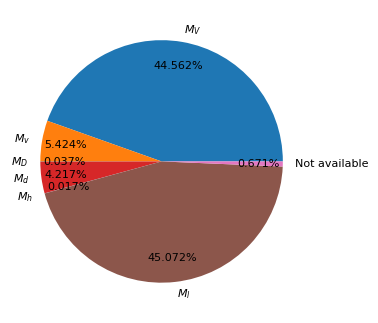

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(12 * cm, 10 * cm))
types = ["V", "v", "D", "md", "mh", "ml"]
counts = []
labels = []
type_label_dict = {
    "D": r"$M_D$",
    "V": r"$M_V$",
    "md": r"$M_d$",
    "mh": r"$M_h$",
    "ml": r"$M_l$",
    "v": r"$M_v$",
}
for i in range(len(types)):
    labels.append(f"{type_label_dict[types[i]]}")
    counts.append(
        len(available_mag_data[available_mag_data["source_magnitude_type"] == types[i]])
    )
    # counts.append(count)
labels.append("Not available")
counts.append(len(no_mag_data))
print(labels)
print(counts)
plt.pie(
    counts,
    labels=labels,
    autopct="%1.3f%%",
    textprops={"fontsize": fts},
    #    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    pctdistance=0.8,
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/mag_types_pie_chart.pdf",
    dpi=300,
    bbox_inches="tight",
)

min -0.56, max 3.59
min -0.6, max 1.3


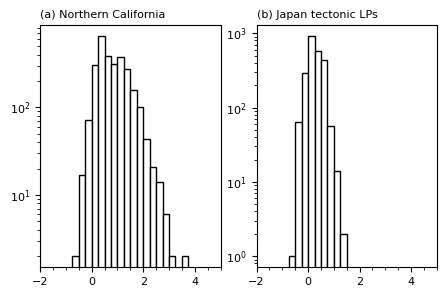

In [124]:
extra_test_sets = [ncedc, japan_tec_lp]
fig, axs = plt.subplots(1, 2, figsize=(13 * cm, 8 * cm), sharex="row")
plt.subplots_adjust(wspace=0.2)
bins = np.arange(0, 60 + 1, 2.5)
labels = ["(a) Northern California", "(b) Japan tectonic LPs"]
for i in range(2):
    mag_df = extra_test_sets[i].metadata.drop_duplicates(
        subset="source_id", keep="first", inplace=False
    )
    mag_df = mag_df[
        (pd.notna(mag_df["source_magnitude_type"]))
        & (mag_df["source_magnitude_type"] != "m")
    ]
    ax = axs[i]
    label = labels[i]
    mags = mag_df["source_magnitude"]
    print(f"min {np.min(mags)}, max {np.max(mags)}")
    bins = np.arange(-2.0, 4, 0.25)
    ax.hist(
        mags.values, bins, density=False, color="white", edgecolor="black", log=True
    )  # ,cumulative=-1
    ax.set_xlim([-2, 5])
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
# plt.savefig(
#     "/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc_jp_tec_magnitude.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )

min -1.22, max 4.5
min -9.0, max 3.87
min -1.1, max 4.8
min -0.56, max 3.59
min -0.6, max 1.3


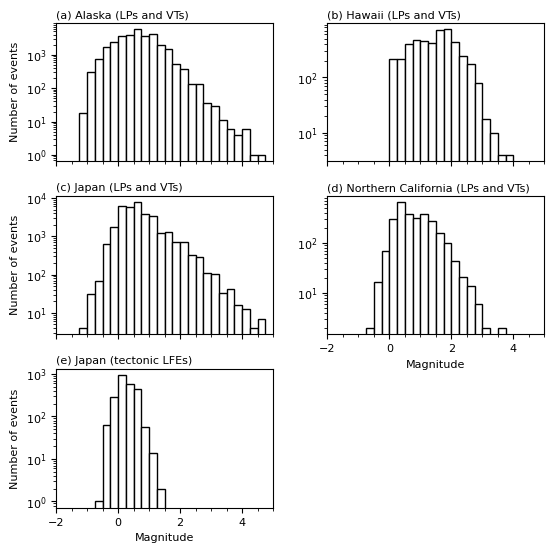

In [125]:
trace_chunks = [
    ("_ak_lp", "_ak_rg"),
    ("_hw12t21_lp", "_hw12t21_rg"),
    ("_japan_vol_lp", "_japan_vt"),
]
# subplot_labels = ["(a) Alaska", "(b) Hawaii", "(c) Japan", "(d) All"]
subplot_labels = [
    "(a) Alaska (LPs and VTs)",
    "(b) Hawaii (LPs and VTs)",
    "(c) Japan (LPs and VTs)",
    "(d) Northern California (LPs and VTs)",
    "(e) Japan (tectonic LFEs)",
]
fig, axs = plt.subplots(3, 2, figsize=(16 * cm, 16 * cm), sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for i in range(3):
    ax = axs.flat[i]
    label = subplot_labels[i]
    if i < 3:
        chunks = trace_chunks[i]
        current_df = available_mag_data[
            (available_mag_data["trace_chunk"] == chunks[0])
            | (available_mag_data["trace_chunk"] == chunks[1])
        ]
    else:
        current_df = available_mag_data
    mags = current_df["source_magnitude"]
    # print((mags[mags<-1]))
    print(f"min {np.min(mags)}, max {np.max(mags)}")

    bins = np.arange(-2.0, 5, 0.25)
    ax.hist(
        mags.values, bins, density=False, color="white", edgecolor="black", log=True
    )  # ,cumulative=-1
    ax.set_xlim([-2, 5])
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
for i, current_df in enumerate([ncedc.metadata, japan_tec_lp.metadata]):
    ax = axs.flat[3 + i]
    label = subplot_labels[3 + i]
    mag_df = current_df.drop_duplicates(subset="source_id", keep="first", inplace=False)
    mag_df = mag_df[
        (pd.notna(mag_df["source_magnitude_type"]))
        & (mag_df["source_magnitude_type"] != "m")
    ]
    mags = mag_df["source_magnitude"]
    print(f"min {np.min(mags)}, max {np.max(mags)}")
    bins = np.arange(-2.0, 5, 0.25)
    ax.hist(
        mags.values, bins, density=False, color="white", edgecolor="black", log=True
    )  # ,cumulative=-1
    ax.set_xlim([-2, 5])
    ax.tick_params(labelsize=fts)
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.text(
        0.0,
        1.02,
        label,
        verticalalignment="bottom",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
# plt.hist(freq_indices_rg, bins,density=False, color="dodgerblue", edgecolor="black", alpha=0.8, label="VT")
# plt.hist(freq_indices_lp, bins,density=False, color="firebrick", edgecolor="black", alpha=0.8, label="LP")

plt.gca().tick_params(labelsize=fts)
axs[-1][0].set_xlabel("Magnitude", fontsize=fts)
axs[-1][1].set_xlabel("Magnitude", fontsize=fts)
axs[0][0].set_ylabel("Number of events", fontsize=fts)
axs[1][0].set_ylabel("Number of events", fontsize=fts)
axs[2][0].set_ylabel("Number of events", fontsize=fts)

fig.delaxes(axs[2][1])
axs[1][1].xaxis.set_tick_params(which="both", labelbottom=True)
axs[1][1].set_xlabel("Magnitude", fontsize=fts)

plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/magnitude_histogram.pdf",
    dpi=300,
    bbox_inches="tight",
)

# Components

In [4]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")
meta_files = [x.name for x in data_path.iterdir() if x.name.endswith(".csv")]
meta_files

['metadata_hwnoise.csv',
 'metadata_hw12t21_lp.csv',
 'metadata_jpnoise.csv',
 'metadata_japan_vt.csv',
 'metadata_ak_rg.csv',
 'metadata_hw12t21_rg.csv',
 'metadata_aknoise.csv',
 'metadata_ak_lp.csv',
 'metadata_japan_vol_lp.csv']

In [5]:
def get_comp_stats(data_dir, meta_file):
    stat_dict = {1: 0, 2: 0, 3: 0}
    meta = pd.read_csv(meta_file)
    # mseed_fnames=meta.apply(lambda x: x["trace_name_original"] if pd.notna(x["trace_name_original"]) else x["trace_name"],axis=1)
    # for mseed_file in tqdm(mseed_fnames):
    for i in tqdm(range(len(meta))):
        if pd.notna(meta.iloc[i]["trace_name_original"]):
            mseed_file = meta.iloc[i]["trace_name_original"]
        else:
            mseed_file = meta.iloc[i]["trace_name"]

        try:
            st = read(data_dir / mseed_file)
        except TypeError as e:
            print(mseed_file)
            raise e
        component_list = set([tr.id for tr in st])
        # assert len(st)>0 and len(st)<=3
        n_cp = len(component_list)  # number of components
        stat_dict[n_cp] = stat_dict[n_cp] + 1
    return stat_dict

In [22]:
hwnoise_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Noise/hw_mseed"),
    data_path / "metadata_hwnoise.csv",
)

jpnoise_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Noise/jp_mseed12"),
    data_path / "metadata_jpnoise.csv",
)

aknoise_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Noise/ak_mseed"),
    data_path / "metadata_aknoise.csv",
)

ak_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Alaska/mseed"),
    data_path / "metadata_ak_lp.csv",
)
ak_rg_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Alaska/mseed"),
    data_path / "metadata_ak_rg.csv",
)

hw12t21_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/hawaii2012to2021/mseed"),
    data_path / "metadata_hw12t21_lp.csv",
)
hw12t21_rg_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/hawaii2012to2021/mseed"),
    data_path / "metadata_hw12t21_rg.csv",
)

japan_vol_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Japan/Vol_lp/mseed"),
    data_path / "metadata_japan_vol_lp.csv",
)
japan_vt_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Japan/VT/mseed"),
    data_path / "metadata_japan_vt.csv",
)

ncedc_vt_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/ncedc_vt/mseed"),
    Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc/metadata_ncedc_vt.csv"),
)

ncedc_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/ncedc/mseed"),
    Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc/metadata_ncedc_lp.csv"),
)

100%|██████████| 4841/4841 [00:10<00:00, 472.70it/s]


In [228]:
cascade_vt_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Cascade_vt/mseed"),
    Path(
        "/home/zhongyiyuan/DATA/my_datasets_seisbench/cascade/metadata_cascade_vt.csv"
    ),
)

cascade_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Cascade_lp/mseed"),
    Path(
        "/home/zhongyiyuan/DATA/my_datasets_seisbench/cascade/metadata_cascade_lp.csv"
    ),
)

100%|██████████| 810/810 [00:01<00:00, 795.78it/s] 


In [70]:
japan_tec_lp_comp_stat = get_comp_stats(
    Path("/home/zhongyiyuan/DATA/my_data/Japan/Tec_lp/mseed"),
    Path(
        "/home/zhongyiyuan/DATA/my_datasets_seisbench/japan_tec_lp/metadata_japan_tec_lp.csv"
    ),
)

100%|██████████| 6224/6224 [01:16<00:00, 81.77it/s] 


In [75]:
comp_stats_list = [
    hwnoise_comp_stat,
    jpnoise_comp_stat,
    aknoise_comp_stat,
    ak_lp_comp_stat,
    ak_rg_comp_stat,
    hw12t21_lp_comp_stat,
    hw12t21_rg_comp_stat,
    japan_vol_lp_comp_stat,
    japan_vt_comp_stat,
    ncedc_lp_comp_stat,
    ncedc_vt_comp_stat,
    japan_tec_lp_comp_stat,
]

In [203]:
comp_stats_list

[{'1': 1207, '2': 2, '3': 3989},
 {'1': 21, '2': 14, '3': 7550},
 {'1': 5692, '2': 32, '3': 1493},
 {'1': 34214, '2': 43, '3': 17685},
 {'1': 31337, '2': 218, '3': 19344},
 {'1': 560, '2': 18, '3': 16328},
 {'1': 693, '2': 26, '3': 16095},
 {'1': 17, '2': 1056, '3': 81510},
 {'1': 59, '2': 116, '3': 83769},
 {'1': 3353, '2': 65, '3': 1423},
 {'1': 867, '2': 29, '3': 3945},
 {'1': 0, '2': 0, '3': 6224}]

In [77]:
comp_stats_df = pd.DataFrame.from_records(
    comp_stats_list,
    index=[
        "hwnoise",
        "jpnoise",
        "aknoise",
        "ak_lp",
        "ak_rg",
        "hw12t21_lp",
        "hw12t21_rg",
        "japan_vol_lp",
        "japan_vt",
        "ncedc_lp",
        "ncedc_vt",
        "japan_tec_lp",
    ],
)
comp_stats_df.to_csv(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis_component_stats.csv"
)

In [204]:
comp_stats_df = pd.read_csv(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis_component_stats.csv",
    index_col=0,
)
comp_stats_list = [comp_stats_df.loc[x].to_dict() for x in comp_stats_df.index]
comp_stats = {1: 0, 2: 0, 3: 0}
for i in range(len(comp_stats_list)):
    print(comp_stats_list[i])
    for n_comp, count in comp_stats_list[i].items():
        comp_stats[int(n_comp)] = comp_stats[int(n_comp)] + count

{'1': 1207, '2': 2, '3': 3989}
{'1': 21, '2': 14, '3': 7550}
{'1': 5692, '2': 32, '3': 1493}
{'1': 34214, '2': 43, '3': 17685}
{'1': 31337, '2': 218, '3': 19344}
{'1': 560, '2': 18, '3': 16328}
{'1': 693, '2': 26, '3': 16095}
{'1': 17, '2': 1056, '3': 81510}
{'1': 59, '2': 116, '3': 83769}
{'1': 3353, '2': 65, '3': 1423}
{'1': 867, '2': 29, '3': 3945}
{'1': 0, '2': 0, '3': 6224}


In [208]:
comp_stats_df

,1,2,3
hwnoise,1207,2,3989
jpnoise,21,14,7550
aknoise,5692,32,1493
ak_lp,34214,43,17685
ak_rg,31337,218,19344
hw12t21_lp,560,18,16328
hw12t21_rg,693,26,16095
japan_vol_lp,17,1056,81510
japan_vt,59,116,83769
ncedc_lp,3353,65,1423


In [211]:
comp_stats_df.loc["ncedc_vt", "1"]

867

In [213]:
comp_stats_df["1"]["ncedc_vt"]

867

In [224]:
type(list(cascade_vt_comp_stat.keys())[0])

int

In [244]:
westernus_vt_comp_stat = {}
westernus_lp_comp_stat = {}
westernus_comp_stat = {}
for i in [1, 2, 3]:
    westernus_vt_comp_stat[i] = (
        comp_stats_df[str(i)]["ncedc_vt"] + cascade_vt_comp_stat[i]
    )
    westernus_lp_comp_stat[i] = (
        comp_stats_df[str(i)]["ncedc_lp"] + +cascade_lp_comp_stat[i]
    )
    westernus_comp_stat[i] = westernus_vt_comp_stat[i] + westernus_lp_comp_stat[i]

In [266]:
print(comp_stats)
for i in [1, 2, 3]:
    comp_stats[i] = comp_stats[i] + westernus_vt_comp_stat[i]
print(comp_stats)

{1: 78020, 2: 1619, 3: 259355}
{1: 79335, 2: 1649, 3: 263661}


In [245]:
westernus_lp_comp_stat

{1: 3703, 2: 65, 3: 1883}

In [247]:
cascade_lp_comp_stat

{1: 350, 2: 0, 3: 460}

In [248]:
cascade_vt_comp_stat

{1: 448, 2: 1, 3: 361}

In [246]:
westernus_comp_stat

{1: 5018, 2: 95, 3: 6189}

In [232]:
westernus_comp_stats_df = pd.DataFrame.from_records(
    [westernus_vt_comp_stat, westernus_lp_comp_stat],
    index=[
        "westernus_vt",
        "westernus_lp",
    ],
)

In [233]:
westernus_comp_stats_df

,1,2,3
westernus_vt,1315,30,4306
westernus_lp,3703,65,1883


In [235]:
[x for x in comp_stats_df.index if "ak" in x]

['aknoise', 'ak_lp', 'ak_rg']

In [236]:
ak_comp_stats_list = [
    comp_stats_df.loc[x].to_dict() for x in comp_stats_df.index if "ak" in x
]
ak_comp_stats = {1: 0, 2: 0, 3: 0}
for i in range(len(ak_comp_stats_list)):
    print(ak_comp_stats_list[i])
    for n_comp, count in ak_comp_stats_list[i].items():
        ak_comp_stats[int(n_comp)] = ak_comp_stats[int(n_comp)] + count

{'1': 5692, '2': 32, '3': 1493}
{'1': 34214, '2': 43, '3': 17685}
{'1': 31337, '2': 218, '3': 19344}


In [237]:
hw_comp_stats_list = [
    comp_stats_df.loc[x].to_dict() for x in comp_stats_df.index if "hw" in x
]
hw_comp_stats = {1: 0, 2: 0, 3: 0}
for i in range(len(hw_comp_stats_list)):
    print(hw_comp_stats_list[i])
    for n_comp, count in hw_comp_stats_list[i].items():
        hw_comp_stats[int(n_comp)] = hw_comp_stats[int(n_comp)] + count

{'1': 1207, '2': 2, '3': 3989}
{'1': 560, '2': 18, '3': 16328}
{'1': 693, '2': 26, '3': 16095}


In [238]:
jp_comp_stats_list = [
    comp_stats_df.loc[x].to_dict()
    for x in comp_stats_df.index
    if ("jp" in x) or ("japan" in x)
]
jp_comp_stats = {1: 0, 2: 0, 3: 0}
for i in range(len(jp_comp_stats_list)):
    print(jp_comp_stats_list[i])
    for n_comp, count in jp_comp_stats_list[i].items():
        jp_comp_stats[int(n_comp)] = jp_comp_stats[int(n_comp)] + count

{'1': 21, '2': 14, '3': 7550}
{'1': 17, '2': 1056, '3': 81510}
{'1': 59, '2': 116, '3': 83769}
{'1': 0, '2': 0, '3': 6224}


In [267]:
jp_comp_stats_list

[{'1': 21, '2': 14, '3': 7550},
 {'1': 17, '2': 1056, '3': 81510},
 {'1': 59, '2': 116, '3': 83769},
 {'1': 0, '2': 0, '3': 6224}]

In [239]:
ncedc_comp_stats_list = [
    comp_stats_df.loc[x].to_dict() for x in comp_stats_df.index if "ncedc" in x
]
ncedc_comp_stats = {1: 0, 2: 0, 3: 0}
for i in range(len(ncedc_comp_stats_list)):
    print(ncedc_comp_stats_list[i])
    for n_comp, count in ncedc_comp_stats_list[i].items():
        ncedc_comp_stats[int(n_comp)] = ncedc_comp_stats[int(n_comp)] + count

{'1': 3353, '2': 65, '3': 1423}
{'1': 867, '2': 29, '3': 3945}


In [264]:
comp_stats

{1: 78020, 2: 1619, 3: 259355}

['1 components', '2 components', '3 components']
[78020, 1619, 259355]


([<matplotlib.patches.Wedge at 0x7fe07e996df0>,
 [Text(0.8247757096203628, 0.7278358529367916, '1 components'),
  Text(0.120436302038059, 1.0933869841695563, '2 components'),
  Text(-0.8137629319866083, -0.7401282932874266, '3 components')],
 [Text(0.5998368797239002, 0.5293351657722121, '23.015%'),
  Text(0.08759003784586109, 0.7951905339414955, '0.478%'),
  Text(-0.5918275868993516, -0.5382751223908556, '76.507%')])

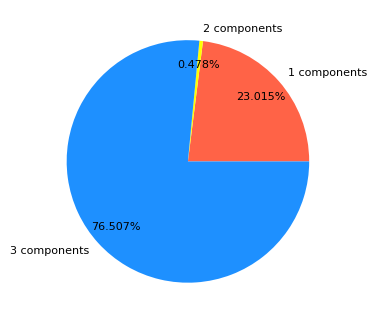

In [240]:
cm = 1 / 2.54
fig, ax = plt.subplots(1, 1, figsize=(12 * cm, 10 * cm))
labels = []
counts = []
for label, count in comp_stats.items():
    labels.append(f"{label} components")
    counts.append(count)
print(labels)
print(counts)
fts = 8
ax.pie(
    counts,
    labels=labels,
    autopct="%1.3f%%",
    colors=["tomato", "yellow", "dodgerblue"],
    textprops={"fontsize": fts},
    #    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    pctdistance=0.8,
)
# plt.savefig(
#     "/home/zhongyiyuan/DATA/my_datasets_seisbench/components_pie_chart.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )

In [241]:
ncedc_comp_stats

{1: 4220, 2: 94, 3: 5368}

In [242]:
ak_comp_stats

{1: 71243, 2: 293, 3: 38522}

In [249]:
westernus_comp_stat

{1: 5018, 2: 95, 3: 6189}

['1 components', '2 components', '3 components']
[71243, 293, 38522]
['1 components', '2 components', '3 components']
[2460, 46, 36412]
['1 components', '2 components', '3 components']
[97, 1186, 179053]
['1 components', '2 components', '3 components']
[5018, 95, 6189]
['1 components', '2 components', '3 components']
[78020, 1619, 259355]
{'bbox_to_anchor': (1.3, 0, 0.5, 1)}


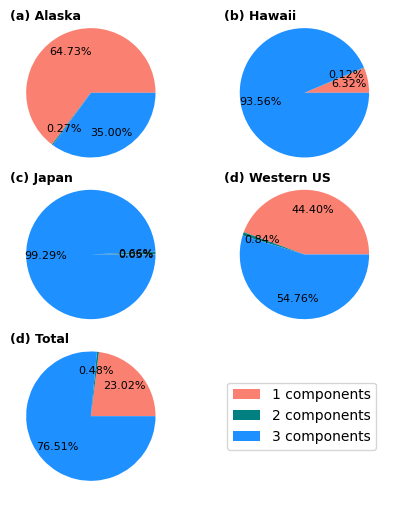

In [262]:
fig, axs = plt.subplots(3, 2, figsize=(14 * cm, 16 * cm))
plt.subplots_adjust(wspace=0.0, hspace=0.0)


def plot_comp(ax, comp_stats, ax_title, legend_kwargs=None):
    labels = []
    counts = []
    for label, count in comp_stats.items():
        labels.append(f"{label} components")
        counts.append(count)
    print(labels)
    print(counts)
    fts = 8
    wedges, texts, autotexts = ax.pie(
        counts,
        # labels=labels,
        autopct="%1.2f%%",
        colors=[
            "salmon",
            "teal",
            "dodgerblue",
        ],
        textprops={"fontsize": fts},
        #    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
        pctdistance=0.7,
    )
    ax.set_title(
        ax_title,
        fontsize=fts + 1,
        x=0,
        y=0.9,
        weight="bold",
        horizontalalignment="left",
    )
    if legend_kwargs is not None:
        print(legend_kwargs)
        ax.legend(
            wedges,
            labels,
            loc="center left",
            # frameon=False,
            **legend_kwargs,
            # bbox_to_anchor=(1, 0, 0.5, 1),
        )


plot_comp(axs[0][0], ak_comp_stats, "(a) Alaska")
plot_comp(axs[0][1], hw_comp_stats, "(b) Hawaii")
plot_comp(axs[1][0], jp_comp_stats, "(c) Japan")
plot_comp(axs[1][1], westernus_comp_stat, "(d) Western US")
plot_comp(
    axs[2][0],
    comp_stats,
    "(d) Total",
    legend_kwargs={
        "bbox_to_anchor": (1.3, 0, 0.5, 1),
    },
)
plt.delaxes(axs[2][1])
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/components_pie_chart.jpg",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0,
)
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/components_pie_chart.pdf",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0,
)

# Distance to volcanoes

In [268]:
from obspy.geodetics import gps2dist_azimuth

In [269]:
volcano_path = Path("/home/zhongyiyuan/DATA/volcano_information")

Alaska

In [270]:
np.unique(data_eq.metadata["trace_chunk"])

array(['_ak_lp', '_ak_rg', '_hw12t21_lp', '_hw12t21_rg', '_japan_vol_lp',
       '_japan_vt'], dtype=object)

In [271]:
np.all(
    (
        pd.notna(data_eq.metadata["trace_p_arrival_sample"])
        | pd.notna(data_eq.metadata["trace_s_arrival_sample"])
    )
)

True

In [272]:
data_eq_events = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False, ignore_index=True
)

In [273]:
ak_e = data_eq_events[
    (data_eq_events["trace_chunk"] == "_ak_lp")
    | (data_eq_events["trace_chunk"] == "_ak_rg")
].copy()

In [274]:
print(f"Number: {len(ak_e)}")
print(f"Minimum date: {min(ak_e['source_origin_time'])}")
print(f"Maximum date: {max(ak_e['source_origin_time'])}")
print(f"Minimum latitude: {min(ak_e['source_latitude_deg'])}")
print(f"Maximum latitude: {max(ak_e['source_latitude_deg'])}")
print(f"Minimum longitude: {min(ak_e['source_longitude_deg'])}")
print(f"Maximum longitude: {max(ak_e['source_longitude_deg'])}")

Number: 31220
Minimum date: 1997-09-21T23:33:08.870000Z
Maximum date: 2017-12-31T05:39:16.940000Z
Minimum latitude: 51.1855
Maximum latitude: 62.213166666666666
Minimum longitude: -179.29416666666663
Maximum longitude: 179.96833333333333


In [275]:
alaska_vol_full = pd.read_csv(volcano_path / "alaska_volcanoes" / "alaska_vol.csv")
alaska_vol = pd.read_csv(
    volcano_path / "alaska_volcanoes" / "alaska_vol_instrumented.csv"
)

In [276]:
ak_dists_to_vol = []
ak_nearest_volcanoes = []
for i in tqdm(range(len(ak_e))):
    lat_e = ak_e.iloc[i]["source_latitude_deg"]
    lon_e = ak_e.iloc[i]["source_longitude_deg"]

    # distance of the current earthquake to all volcanoes
    distances_to_volcanoes = alaska_vol.apply(
        lambda x: gps2dist_azimuth(lat_e, lon_e, x["lat"], x["lon"])[0], axis=1
    ).values
    # distance of the current earthquake to the nearest volcano
    ak_dists_to_vol.append(np.min(distances_to_volcanoes))

    # the nearest volcano
    row_idx = np.argmin(distances_to_volcanoes)
    ak_nearest_volcanoes.append(alaska_vol.iloc[row_idx]["volcano"])

ak_e["distance_to_volcano"] = ak_dists_to_vol
ak_e["nearest_volcano"] = ak_nearest_volcanoes
alaska_vol_with_data = alaska_vol[
    alaska_vol["volcano"].isin(ak_e["nearest_volcano"])
].copy()

100%|██████████| 31220/31220 [02:52<00:00, 181.00it/s]


Hawaii

In [277]:
hawaii_vol = pd.read_csv(volcano_path / "hawaii_volcanoes" / "hawaii_vol.csv")

In [278]:
hw_e = data_eq_events[
    (data_eq_events["trace_chunk"] == "_hw12t21_lp")
    | (data_eq_events["trace_chunk"] == "_hw12t21_rg")
].copy()

In [279]:
hw_dists_to_vol = []
hw_nearest_volcanoes = []
for i in tqdm(range(len(hw_e))):
    lat_e = hw_e.iloc[i]["source_latitude_deg"]
    lon_e = hw_e.iloc[i]["source_longitude_deg"]

    # distance of the current earthquake to all volcanoes
    distances_to_volcanoes = hawaii_vol.apply(
        lambda x: gps2dist_azimuth(lat_e, lon_e, x["lat"], x["lon"])[0], axis=1
    ).values
    # distance of the current earthquake to the nearest volcano
    hw_dists_to_vol.append(np.min(distances_to_volcanoes))

    # the nearest volcano
    row_idx = np.argmin(distances_to_volcanoes)
    hw_nearest_volcanoes.append(hawaii_vol.iloc[row_idx]["volcano"])

hw_e["distance_to_volcano"] = hw_dists_to_vol
hw_e["nearest_volcano"] = hw_nearest_volcanoes
hawaii_vol_with_data = hawaii_vol[
    hawaii_vol["volcano"].isin(hw_e["nearest_volcano"])
].copy()

100%|██████████| 5117/5117 [00:06<00:00, 759.44it/s]


Japan

In [280]:
jp_e = data_eq_events[
    (data_eq_events["trace_chunk"] == "_japan_vol_lp")
    | (data_eq_events["trace_chunk"] == "_japan_vt")
].copy()

In [281]:
# active volcanoes
jp_active_vol = pd.read_csv(
    volcano_path / "japan_volcanoes" / "japan_active_vol_JMA.csv"
)
jp_active_vol.drop_duplicates(subset=["index"], keep="first", inplace=True)
jp_active_vol["lat"] = (
    jp_active_vol["lat_deg"]
    + jp_active_vol["lat_min"] / 60.0
    + jp_active_vol["lat_sec"] / 3600
)
jp_active_vol["lon"] = (
    jp_active_vol["lon_deg"]
    + jp_active_vol["lon_min"] / 60.0
    + jp_active_vol["lon_sec"] / 3600
)
japan_active_vol2 = pd.read_csv(
    volcano_path / "japan_volcanoes" / "japan_active_vol2.csv"
)

# quaternary volcanoes
japan_qua_vol = pd.read_csv(
    volcano_path / "japan_volcanoes" / "japan_qua_volcanoes.csv"
)

In [282]:
jp_active_vol_GSJ_JMA = pd.concat(
    [jp_active_vol, japan_active_vol2], ignore_index=True
).copy()

In [283]:
jp_dists_to_vol = []
jp_nearest_volcanoes = []
for i in tqdm(range(len(jp_e))):
    lat_e = jp_e.iloc[i]["source_latitude_deg"]
    lon_e = jp_e.iloc[i]["source_longitude_deg"]

    # distance of the current earthquake to all volcanoes
    distances_to_volcanoes = jp_active_vol_GSJ_JMA.apply(
        lambda x: gps2dist_azimuth(lat_e, lon_e, x["lat"], x["lon"])[0], axis=1
    ).values
    # distance of the current earthquake to the nearest volcano
    jp_dists_to_vol.append(np.min(distances_to_volcanoes))

    # the nearest volcano
    row_idx = np.argmin(distances_to_volcanoes)
    jp_nearest_volcanoes.append(jp_active_vol_GSJ_JMA.iloc[row_idx]["volcano"])

jp_e["distance_to_volcano"] = jp_dists_to_vol
jp_e["nearest_volcano"] = jp_nearest_volcanoes
jp_active_vol_GSJ_JMA_with_data = jp_active_vol_GSJ_JMA[
    jp_active_vol_GSJ_JMA["volcano"].isin(jp_e["nearest_volcano"])
].copy()

  0%|          | 0/34015 [00:00<?, ?it/s]

100%|██████████| 34015/34015 [09:35<00:00, 59.07it/s]


NCEDC

In [284]:
california_vol = pd.read_csv(
    volcano_path / "california_volcanoes" / "california_vol.csv"
)

In [285]:
ncedc_e = ncedc.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False, ignore_index=True
).copy()

In [286]:
ncedc_dists_to_vol = []
ncedc_nearest_volcanoes = []
for i in tqdm(range(len(ncedc_e))):
    lat_e = ncedc_e.iloc[i]["source_latitude_deg"]
    lon_e = ncedc_e.iloc[i]["source_longitude_deg"]

    # distance of the current earthquake to all volcanoes
    distances_to_volcanoes = california_vol.apply(
        lambda x: gps2dist_azimuth(lat_e, lon_e, x["lat"], x["lon"])[0], axis=1
    ).values
    # distance of the current earthquake to the nearest volcano
    ncedc_dists_to_vol.append(np.min(distances_to_volcanoes))

    # the nearest volcano
    row_idx = np.argmin(distances_to_volcanoes)
    ncedc_nearest_volcanoes.append(california_vol.iloc[row_idx]["volcano"])

ncedc_e["distance_to_volcano"] = ncedc_dists_to_vol
ncedc_e["nearest_volcano"] = ncedc_nearest_volcanoes
california_vol_with_data = california_vol[
    california_vol["volcano"].isin(ncedc_e["nearest_volcano"])
].copy()

100%|██████████| 2743/2743 [00:05<00:00, 467.70it/s]


Cascade

In [287]:
cascade_vol = pd.read_csv(volcano_path / "cascade_volcanoes/cascade_vol.csv")

In [288]:
cascade_e = cascade.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False, ignore_index=True
).copy()

In [289]:
cascade_dists_to_vol = []
cascade_nearest_volcanoes = []
for i in tqdm(range(len(cascade_e))):
    lat_e = cascade_e.iloc[i]["source_latitude_deg"]
    lon_e = cascade_e.iloc[i]["source_longitude_deg"]

    # distance of the current earthquake to all volcanoes
    distances_to_volcanoes = cascade_vol.apply(
        lambda x: gps2dist_azimuth(lat_e, lon_e, x["lat"], x["lon"])[0], axis=1
    ).values
    # distance of the current earthquake to the nearest volcano
    cascade_dists_to_vol.append(np.min(distances_to_volcanoes))

    # the nearest volcano
    row_idx = np.argmin(distances_to_volcanoes)
    cascade_nearest_volcanoes.append(california_vol.iloc[row_idx]["volcano"])

cascade_e["distance_to_volcano"] = cascade_dists_to_vol
cascade_e["nearest_volcano"] = cascade_nearest_volcanoes
cascade_vol_with_data = cascade_vol[
    cascade_vol["volcano"].isin(cascade_e["nearest_volcano"])
].copy()

100%|██████████| 421/421 [00:00<00:00, 530.77it/s]


In [290]:
all_e = pd.concat([ak_e, jp_e, hw_e, ncedc_e, cascade_e], ignore_index=True).copy()

In [294]:
westernus_e = pd.concat([cascade_e, ncedc_e], ignore_index=True).copy()

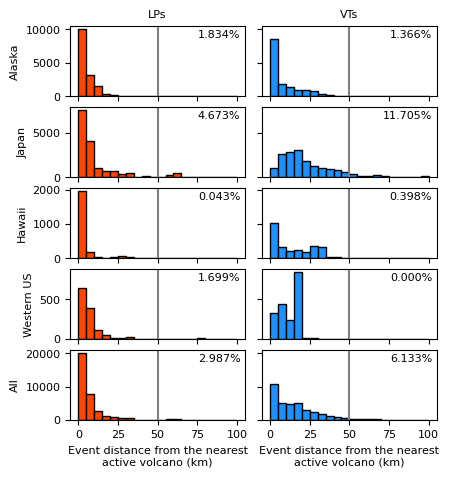

In [297]:
bins = np.arange(0, 100 + 0.1, 5)
vol_dist_lim = 50e3
fig, axs = plt.subplots(
    5, 2, figsize=(12 * cm, 13 * cm), squeeze=False, sharey="row", sharex="col"
)
plt.subplots_adjust(wspace=0.1, hspace=0.15)
for i, (xxx_e, region_name) in enumerate(
    zip(
        [ak_e, jp_e, hw_e, westernus_e, all_e],
        [
            "Alaska",
            "Japan",
            "Hawaii",
            "Western US",
            # "Northern\nCalifornia",
            # "Cascade\nVolcanoes",
            "All",
        ],
    )
):
    axs[i][0].hist(
        np.array(xxx_e[xxx_e["source_type"] == "lp"]["distance_to_volcano"].values)
        / 1000,
        color="orangered",
        edgecolor="black",
        bins=bins,
    )
    out = len(
        xxx_e[
            (xxx_e["source_type"] == "lp")
            & (xxx_e["distance_to_volcano"] > vol_dist_lim)
        ]
    ) / len(xxx_e[(xxx_e["source_type"] == "lp")])
    axs[i][0].text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=axs[i][0].transAxes,
        fontsize=fts,
    )

    axs[i][1].hist(
        np.array(xxx_e[xxx_e["source_type"] != "lp"]["distance_to_volcano"].values)
        / 1000,
        color="dodgerblue",
        edgecolor="black",
        bins=bins,
    )
    out = len(
        xxx_e[
            (xxx_e["source_type"] != "lp")
            & (xxx_e["distance_to_volcano"] > vol_dist_lim)
        ]
    ) / len(xxx_e[(xxx_e["source_type"] != "lp")])
    axs[i][1].text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=axs[i][1].transAxes,
        fontsize=fts,
    )
    axs[i][0].set_ylabel(region_name, fontsize=fts)
    axs[i][0].axvline(vol_dist_lim / 1e3, color="gray")
    axs[i][1].axvline(vol_dist_lim / 1e3, color="gray")

    axs[i][0].tick_params(labelsize=fts)
    axs[i][1].tick_params(labelsize=fts)

axs[0][0].set_title("LPs", fontsize=fts)
axs[0][1].set_title("VTs", fontsize=fts)
axs[-1][0].set_xlabel(
    "Event distance from the nearest\nactive volcano (km)", fontsize=fts
)
axs[-1][1].set_xlabel(
    "Event distance from the nearest\nactive volcano (km)", fontsize=fts
)
plt.savefig("event_distance_to_volcanoes.pdf", dpi=300, bbox_inches="tight")
plt.savefig("event_distance_to_volcanoes.jpg", dpi=300, bbox_inches="tight")
# plt.savefig("event_distance_to_volcanoes.pdf", dpi=300, bbox_inches="tight")

In [292]:
sid_vol_distance_dict = {}
for i in tqdm(range(len(all_e))):
    sid_vol_distance_dict[all_e.iloc[i]["source_id"]] = all_e.iloc[i][
        "distance_to_volcano"
    ]

  0%|          | 0/73516 [00:00<?, ?it/s]

100%|██████████| 73516/73516 [00:08<00:00, 8919.57it/s]


Write event-volcano distance to data

In [113]:
metadata_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis/metadata_ak_lp.csv"
metadata = pd.read_csv(metadata_path)

In [114]:
source_active_volcano_distance = [
    sid_vol_distance_dict[x] for x in metadata["source_id"].to_numpy()
]

In [115]:
metadata["source_active_volcano_distance_m"] = source_active_volcano_distance

In [116]:
metadata.to_csv(metadata_path, index=False)

ak vt

In [117]:
metadata_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis/metadata_ak_rg.csv"
metadata = pd.read_csv(metadata_path)

In [118]:
source_active_volcano_distance = [
    sid_vol_distance_dict[x] for x in metadata["source_id"].to_numpy()
]
metadata["source_active_volcano_distance_m"] = source_active_volcano_distance
metadata.to_csv(metadata_path, index=False)

hw lp

In [119]:
metadata_path = (
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis/metadata_hw12t21_lp.csv"
)
metadata = pd.read_csv(metadata_path)
source_active_volcano_distance = [
    sid_vol_distance_dict[x] for x in metadata["source_id"].to_numpy()
]
metadata["source_active_volcano_distance_m"] = source_active_volcano_distance
metadata.to_csv(metadata_path, index=False)

hw vt

In [120]:
metadata_path = (
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis/metadata_hw12t21_rg.csv"
)
metadata = pd.read_csv(metadata_path)
source_active_volcano_distance = [
    sid_vol_distance_dict[x] for x in metadata["source_id"].to_numpy()
]
metadata["source_active_volcano_distance_m"] = source_active_volcano_distance
metadata.to_csv(metadata_path, index=False)

jp lp

In [121]:
metadata_path = (
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis/metadata_japan_vol_lp.csv"
)
metadata = pd.read_csv(metadata_path)
source_active_volcano_distance = [
    sid_vol_distance_dict[x] for x in metadata["source_id"].to_numpy()
]
metadata["source_active_volcano_distance_m"] = source_active_volcano_distance
metadata.to_csv(metadata_path, index=False)

jp vt

In [122]:
metadata_path = (
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis/metadata_japan_vt.csv"
)
metadata = pd.read_csv(metadata_path)
source_active_volcano_distance = [
    sid_vol_distance_dict[x] for x in metadata["source_id"].to_numpy()
]
metadata["source_active_volcano_distance_m"] = source_active_volcano_distance
metadata.to_csv(metadata_path, index=False)

ncedc

In [124]:
metadata_path = (
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc/metadata_ncedc_lp.csv"
)
metadata = pd.read_csv(metadata_path)
source_active_volcano_distance = [
    sid_vol_distance_dict[x] for x in metadata["source_id"].to_numpy()
]
metadata["source_active_volcano_distance_m"] = source_active_volcano_distance
metadata.to_csv(metadata_path, index=False)

In [125]:
metadata_path = (
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/ncedc/metadata_ncedc_vt.csv"
)
metadata = pd.read_csv(metadata_path)
source_active_volcano_distance = [
    sid_vol_distance_dict[x] for x in metadata["source_id"].to_numpy()
]
metadata["source_active_volcano_distance_m"] = source_active_volcano_distance
metadata.to_csv(metadata_path, index=False)

Plot

In [18]:
data_eq_events = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False, ignore_index=True
)

In [19]:
ak_e = data_eq_events[
    (data_eq_events["trace_chunk"] == "_ak_lp")
    | (data_eq_events["trace_chunk"] == "_ak_rg")
].copy()

hw_e = data_eq_events[
    (data_eq_events["trace_chunk"] == "_hw12t21_lp")
    | (data_eq_events["trace_chunk"] == "_hw12t21_rg")
].copy()

jp_e = data_eq_events[
    (data_eq_events["trace_chunk"] == "_japan_vol_lp")
    | (data_eq_events["trace_chunk"] == "_japan_vt")
].copy()

ncedc_e = ncedc.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False, ignore_index=True
).copy()

In [20]:
all_e = pd.concat([ak_e, jp_e, hw_e, ncedc_e], ignore_index=True).copy()

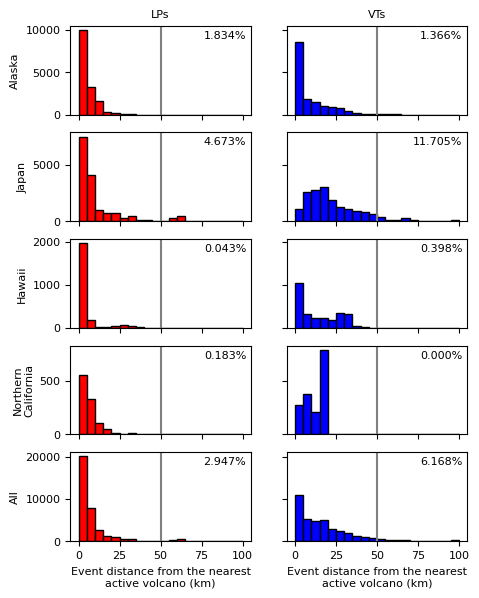

In [21]:
bins = np.arange(0, 100 + 0.1, 5)
vol_dist_lim = 50e3
fig, axs = plt.subplots(
    5, 2, figsize=(13 * cm, 17 * cm), squeeze=False, sharey="row", sharex="col"
)
for i, (xxx_e, region_name) in enumerate(
    zip(
        [ak_e, jp_e, hw_e, ncedc_e, all_e],
        ["Alaska", "Japan", "Hawaii", "Northern\nCalifornia", "All"],
    )
):
    axs[i][0].hist(
        np.array(
            xxx_e[xxx_e["source_type"] == "lp"][
                "source_active_volcano_distance_m"
            ].values
        )
        / 1000,
        color="red",
        edgecolor="black",
        bins=bins,
    )
    out = len(
        xxx_e[
            (xxx_e["source_type"] == "lp")
            & (xxx_e["source_active_volcano_distance_m"] > vol_dist_lim)
        ]
    ) / len(xxx_e[(xxx_e["source_type"] == "lp")])
    axs[i][0].text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=axs[i][0].transAxes,
        fontsize=fts,
    )

    axs[i][1].hist(
        np.array(
            xxx_e[xxx_e["source_type"] != "lp"][
                "source_active_volcano_distance_m"
            ].values
        )
        / 1000,
        color="blue",
        edgecolor="black",
        bins=bins,
    )
    out = len(
        xxx_e[
            (xxx_e["source_type"] != "lp")
            & (xxx_e["source_active_volcano_distance_m"] > vol_dist_lim)
        ]
    ) / len(xxx_e[(xxx_e["source_type"] != "lp")])
    axs[i][1].text(
        0.975,
        0.95,
        f"""{out*100:>5.3f}%""",
        verticalalignment="top",
        horizontalalignment="right",
        transform=axs[i][1].transAxes,
        fontsize=fts,
    )
    axs[i][0].set_ylabel(region_name, fontsize=fts)
    axs[i][0].axvline(vol_dist_lim / 1e3, color="gray")
    axs[i][1].axvline(vol_dist_lim / 1e3, color="gray")

    axs[i][0].tick_params(labelsize=fts)
    axs[i][1].tick_params(labelsize=fts)

axs[0][0].set_title("LPs", fontsize=fts)
axs[0][1].set_title("VTs", fontsize=fts)
axs[-1][0].set_xlabel(
    "Event distance from the nearest\nactive volcano (km)", fontsize=fts
)
axs[-1][1].set_xlabel(
    "Event distance from the nearest\nactive volcano (km)", fontsize=fts
)
plt.savefig("event_distance_to_volcanoes.pdf", dpi=300, bbox_inches="tight")
plt.savefig("event_distance_to_volcanoes.jpg", dpi=300, bbox_inches="tight")
# plt.savefig("event_distance_to_volcanoes.pdf", dpi=300, bbox_inches="tight")

# Avoid violating NIED data policy (https://www.mowlas.bosai.go.jp/policy/guideline/?LANG=en)

In [378]:
metadata_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/dataset_metadata/alaska_hawaii_japan/metadata_japan_vol_lp.csv"
metadata = pd.read_csv(metadata_path)
metadata.drop(
    labels=[
        "source_id",
        "source_type",
        "source_origin_time",
        "source_latitude_deg",
        "source_longitude_deg",
        "source_depth_km",
        "source_magnitude",
        "source_magnitude_type",
        "station_network_code",
        "station_epicentral_distance_m",
        "station_location_code",
        "trace_channel",
        "station_latitude_deg",
        "station_longitude_deg",
        "station_elevation_m",
        "path_azimuth_deg",
        "path_back_azimuth_deg",
        "trace_sampling_rate_hz",
        "trace_p_arrival_time",
        "trace_s_arrival_time",
        "trace_mean_snr_db",
        "trace_p_status",
        "trace_s_status",
        "trace_has_spikes",
        "trace_name",
        "trace_name_original",
        "source_active_volcano_distance_m",
    ],
    axis=1,
    inplace=True,
)
metadata.rename(
    columns={
        "trace_p_arrival_sample": "p_arrival_sample_at_100Hz",
        "trace_s_arrival_sample": "s_arrival_sample_at_100Hz",
    },
    inplace=True,
)
metadata.to_csv(metadata_path, index=False)

In [379]:
metadata

,station_code,trace_start_time,p_arrival_sample_at_100Hz,s_arrival_sample_at_100Hz,trace_snr_db,trace_frequency_index,split,source_frequency_index
0,N.KTRH,2004-04-01T09:36:31.000000Z,2090,2386,"[8.575475133113297, 10.048054641804192, 13.321...",-1.036866,train,-1.138430
1,N.KOKH,2004-04-01T09:36:31.000000Z,2174,2594,"[17.498771796347018, 15.78253364423029, 6.4174...",-1.284453,train,-1.138430
2,DP.KTJ,2004-04-01T09:36:31.000000Z,2231,2625,"[14.048785967454192, 13.906122858669347, 13.68...",-1.169874,train,-1.138430
3,NIUKAW,2004-04-01T09:36:31.000000Z,2211,2559,"[13.261064260466409, 11.826764974903822, 16.65...",-1.062528,train,-1.138430
4,NIUKAW,2004-04-01T09:41:02.000000Z,2158,2596,"[7.165314747194533, 6.670605395859303, 9.61753...",-0.871709,train,-0.631390
...,...,...,...,...,...,...,...,...
82578,N.NITH,2023-06-27T19:37:34.000000Z,2102,2458,"[5.4180400611748585, 9.4692248350453, 10.85849...",-0.740034,test,-0.680433
82579,N.TTAH,2023-06-27T19:37:34.000000Z,2346,2916,"[8.023079538850762, 13.789222068325437, 9.1628...",-0.687194,train,-0.680433
82580,HU.HSS,2023-06-28T14:22:48.000000Z,2117,2479,"[11.689864758630183, 11.523587200542542, 9.620...",-0.469389,dev,-0.699466
82581,ENIWA,2023-06-28T14:22:48.000000Z,2087,2452,"[6.617064884533636, 6.87958872011687, 7.094960...",-0.953802,train,-0.699466


In [380]:
metadata_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/dataset_metadata/alaska_hawaii_japan/metadata_japan_vt.csv"
metadata = pd.read_csv(metadata_path)
metadata.drop(
    labels=[
        "source_id",
        "source_type",
        "source_origin_time",
        "source_latitude_deg",
        "source_longitude_deg",
        "source_depth_km",
        "source_magnitude",
        "source_magnitude_type",
        "station_network_code",
        "station_epicentral_distance_m",
        "station_location_code",
        "trace_channel",
        "station_latitude_deg",
        "station_longitude_deg",
        "station_elevation_m",
        "path_azimuth_deg",
        "path_back_azimuth_deg",
        "trace_sampling_rate_hz",
        "trace_p_arrival_time",
        "trace_s_arrival_time",
        "trace_mean_snr_db",
        "trace_p_status",
        "trace_s_status",
        "trace_has_spikes",
        "trace_name",
        "trace_name_original",
        "source_active_volcano_distance_m",
    ],
    axis=1,
    inplace=True,
)
metadata.rename(
    columns={
        "trace_p_arrival_sample": "p_arrival_sample_at_100Hz",
        "trace_s_arrival_sample": "s_arrival_sample_at_100Hz",
    },
    inplace=True,
)
metadata.to_csv(metadata_path, index=False)

In [381]:
metadata_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/dataset_metadata/alaska_hawaii_japan/metadata_jpnoise.csv"
metadata = pd.read_csv(metadata_path)
metadata.drop(
    labels=[
        "source_id",
        "source_type",
        "source_origin_time",
        "source_latitude_deg",
        "source_longitude_deg",
        "source_depth_km",
        "source_magnitude",
        "source_magnitude_type",
        "station_network_code",
        "station_epicentral_distance_m",
        "station_location_code",
        "trace_channel",
        "station_latitude_deg",
        "station_longitude_deg",
        "station_elevation_m",
        "path_azimuth_deg",
        "path_back_azimuth_deg",
        "trace_sampling_rate_hz",
        "trace_p_arrival_sample",
        "trace_s_arrival_sample",
        "trace_p_arrival_time",
        "trace_s_arrival_time",
        "trace_p_max_weight",
        "trace_s_max_weight",
        "trace_p_arrival_sample",
        "trace_p_first_motion",
        "trace_mean_snr_db",
        "trace_p_status",
        "trace_s_status",
        "trace_has_spikes",
        "trace_name",
        "trace_name_original",
        "trace_snr_db",
        "trace_frequency_index",
        "source_frequency_index",
        "split",
    ],
    axis=1,
    inplace=True,
)
metadata.to_csv(metadata_path, index=False)

In [382]:
metadata_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/dataset_metadata/japan_tec_lfe/metadata_japan_tec_lfe.csv"
metadata = pd.read_csv(metadata_path)
metadata.drop(
    labels=[
        "source_id",
        "source_type",
        "source_origin_time",
        "source_latitude_deg",
        "source_longitude_deg",
        "source_depth_km",
        "source_magnitude",
        "source_magnitude_type",
        "station_network_code",
        "station_epicentral_distance_m",
        "station_location_code",
        "trace_channel",
        "station_latitude_deg",
        "station_longitude_deg",
        "station_elevation_m",
        "path_azimuth_deg",
        "path_back_azimuth_deg",
        "trace_sampling_rate_hz",
        "trace_p_arrival_time",
        "trace_s_arrival_time",
        "trace_mean_snr_db",
        "trace_p_status",
        "trace_s_status",
        "trace_has_spikes",
        "trace_name",
        "trace_name_original",
    ],
    axis=1,
    inplace=True,
)
metadata.rename(
    columns={
        "trace_p_arrival_sample": "p_arrival_sample_at_100Hz",
        "trace_s_arrival_sample": "s_arrival_sample_at_100Hz",
    },
    inplace=True,
)
metadata.to_csv(metadata_path, index=False)

In [ ]:
# metadata_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/dataset_metadata/japan_tec_lp/metadata_japan_tec_lp.csv"
# metadata = pd.read_csv(metadata_path)
# metadata.drop(
#     labels=[
#         "source_origin_time",
#         "source_latitude_deg",
#         "source_longitude_deg",
#         "source_depth_km",
#         "source_magnitude",
#         "source_magnitude_type",
#         "station_epicentral_distance_m",
#         "path_azimuth_deg",
#         "path_back_azimuth_deg",
#         "trace_p_arrival_time",
#         "trace_s_arrival_time",
#         "trace_p_status",
#         "trace_s_status",
#         "trace_name",
#         "trace_name_original",
#         "source_active_volcano_distance_m",
#     ],
#     axis=1,
#     inplace=True,
# )
# metadata.to_csv(metadata_path, index=False)

# INSTANCE frequency index

In [75]:
# data_instance = sbd.InstanceCountsCombined(
#     sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="full"
# )

In [248]:
data_instance_eq = sbd.InstanceCounts(
    sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="full"
)

In [249]:
data_instance_eq.filter(pd.notna(data_instance_eq.metadata["trace_P_arrival_sample"]))

In [250]:
len(data_instance_eq)

1159249

In [251]:
data_instance_eq.metadata[["trace_P_arrival_sample", "trace_S_arrival_sample"]]

,trace_P_arrival_sample,trace_S_arrival_sample
0,1691,2379.0
1,1755,2443.0
2,1832,2369.0
3,1934,2665.0
4,1828,2621.0
...,...,...
1159244,1823,NaN
1159245,1571,NaN
1159246,1655,NaN
1159247,1776,NaN


In [252]:
data_records = []
for i in range(len(data_instance_eq)):
    data, trace_params = data_instance_eq.get_sample(i)
    sampling_rate = trace_params["trace_sampling_rate_hz"]
    assert np.isclose(sampling_rate, 100)

    if pd.notna(trace_params["trace_P_arrival_sample"]) or pd.notna(
        trace_params["trace_S_arrival_sample"]
    ):
        # add frequency index
        win_before = 1 * sampling_rate
        win_after = 6 * sampling_rate
        component_FIs = []
        if trace_params["trace_P_arrival_sample"]:
            ref_sample = trace_params["trace_P_arrival_sample"]
        elif trace_params["trace_S_arrival_sample"]:
            ref_sample = trace_params["trace_S_arrival_sample"]
        else:
            ref_sample = None
        if ref_sample:
            for a_component in data:
                if np.sum(np.abs(np.diff(a_component))) > 1e-9:
                    try:
                        fi = freqency_index(
                            data=a_component[
                                int(max(ref_sample - win_before, 0)) : int(
                                    min(ref_sample + win_after, len(a_component))
                                )
                            ],
                            dt=1.0 / sampling_rate,
                            low_freq_band=[1, 5],
                            high_freq_band=[10, 15],
                        )
                    except Exception:
                        print(trace_params["trace_name"])
                        raise Exception

                    if not np.isnan(fi):
                        component_FIs.append(fi)
        if len(component_FIs) > 0:
            trace_FI = np.nanmean(component_FIs)
        trace_params["trace_frequency_index"] = trace_FI
    else:
        trace_params["trace_frequency_index"] = np.nan
    data_records.append(trace_params)

/home/zhongyiyuan/volpick/volpick/data/utils.py:42: RuntimeWarning: invalid value encountered in scalar divide
  return np.log10(Aupper / Alower)


In [253]:
instance_metadata = pd.DataFrame(data=data_records)
source_ids = np.unique(list(instance_metadata["source_id"]))
source_fi_dict = {}
for sid in source_ids:
    source_fi_dict[sid] = np.mean(
        instance_metadata[instance_metadata["source_id"] == sid][
            "trace_frequency_index"
        ]
    )
source_frequency_index = [
    source_fi_dict[x] for x in instance_metadata["source_id"].to_numpy()
]
instance_metadata["source_frequency_index"] = source_frequency_index

In [121]:
len(source_ids)

54008

In [123]:
instance_FI_df = instance_metadata[
    [
        "source_id",
        "station_network_code",
        "station_code",
        "trace_frequency_index",
        "source_frequency_index",
    ]
]
instance_FI_df.to_csv("instance_FI.csv", index=False)

In [124]:
instance_FI_df

,source_id,station_network_code,station_code,trace_frequency_index,source_frequency_index
0,10000541,MN,AQU,-0.094479,0.383393
1,10000541,MN,AQU,0.297471,0.383393
2,10000541,IV,ARRO,0.030326,0.383393
3,10000541,IV,ASSB,0.430263,0.383393
4,10000541,IV,ATCC,0.219252,0.383393
...,...,...,...,...,...
1159244,908231,IV,TEOL,-0.999045,-0.400826
1159245,908231,MN,VLC,-1.108235,-0.400826
1159246,908231,MN,VLC,-0.451123,-0.400826
1159247,908231,IV,ZCCA,-1.429432,-0.400826


plot FI

1.8370218745856934
-3.702658376370804
0.8052362220173376
-2.1074903503175118


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 5.000e+00, 5.000e+00, 6.000e+00, 6.000e+00, 1.400e+01,
        3.800e+01, 5.500e+01, 9.700e+01, 1.650e+02, 2.850e+02, 4.540e+02,
        7.490e+02, 1.207e+03, 1.625e+03, 2.374e+03, 3.282e+03, 4.415e+03,
        5.674e+03, 7.340e+03, 8.427e+03, 8.355e+03, 6.006e+03, 2.597e+03,
        6.510e+02, 1.420e+02, 2.600e+01, 4.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-2.60000000e+00, -2.50000000e+00, -2.40000000e+00, -2.30000000e+00,
        -2.20000000e+00, -2.10000000e+00, -2.00000000e+00, -1.90000000e+00,
        -1.80000000e+00, -1.70000000e+00, -1.60000000e+00, -1.50000000e+00,
        -1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00,
        -1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01,

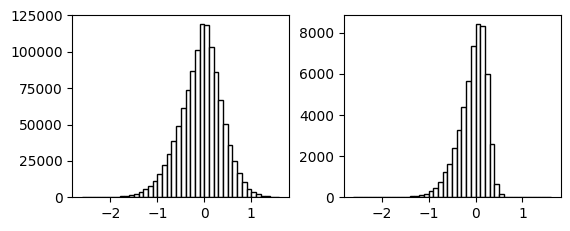

In [185]:
cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(16 * cm, 6 * cm), sharex="row", squeeze=False)
up_b = 1.6
lw_b = -2.6
bins = np.arange(lw_b, up_b + 0.01, 0.1)

fts = 8
plt.subplots_adjust(wspace=0.25, hspace=0.35)
ax = axs[0][0]
freq_indices = instance_metadata["trace_frequency_index"]
print(max(freq_indices))
print(min(freq_indices))
ax.hist(
    freq_indices,
    bins,
    density=False,
    color="white",
    edgecolor="black",
    label="Total",
)

ax = axs[0][1]
event_freq_indices_df = instance_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)
event_freq_indices = event_freq_indices_df["source_frequency_index"]
print(max(event_freq_indices))
print(min(event_freq_indices))
ax.hist(
    event_freq_indices,
    bins,
    density=False,
    color="white",
    edgecolor="black",
    label="Total",
)

# STEAD frequency index

In [302]:
data_stead = sbd.STEAD(component_order="ZNE", dimension_order="NCW", cache="full")

In [126]:
data_stead.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 1265657/1265657 [05:09<00:00, 4089.14it/s] 


In [128]:
np.all(data_stead["trace_sampling_rate_hz"] == 100)

True

In [136]:
data_records = []
for i in range(len(data_stead)):
    data, trace_params = data_stead.get_sample(i)
    sampling_rate = trace_params["trace_sampling_rate_hz"]

    if pd.notna(trace_params["trace_p_arrival_sample"]) or pd.notna(
        trace_params["trace_s_arrival_sample"]
    ):
        # add frequency index
        win_before = 1 * sampling_rate
        win_after = 6 * sampling_rate
        component_FIs = []
        if trace_params["trace_p_arrival_sample"]:
            ref_sample = trace_params["trace_p_arrival_sample"]
        elif trace_params["trace_s_arrival_sample"]:
            ref_sample = trace_params["trace_s_arrival_sample"]
        else:
            ref_sample = None
        if ref_sample:
            for a_component in data:
                if np.sum(np.abs(np.diff(a_component))) > 1e-9:
                    try:
                        fi = freqency_index(
                            data=a_component[
                                int(max(ref_sample - win_before, 0)) : int(
                                    min(ref_sample + win_after, len(a_component))
                                )
                            ],
                            dt=1.0 / sampling_rate,
                            low_freq_band=[1, 5],
                            high_freq_band=[10, 15],
                        )
                    except Exception:
                        print(trace_params["trace_name"])
                        raise Exception

                    if not np.isnan(fi):
                        component_FIs.append(fi)
        if len(component_FIs) > 0:
            trace_FI = np.mean(component_FIs)
        trace_params["trace_frequency_index"] = trace_FI
    else:
        trace_params["trace_frequency_index"] = np.nan
    data_records.append(trace_params)

In [137]:
stead_metadata = pd.DataFrame(data=data_records)
stead_metadata = stead_metadata[stead_metadata["trace_category"] != "noise"].copy()

In [144]:
source_ids[pd.isna(source_ids)]

array([], dtype='<U18')

In [145]:
# very slow! 349 miniutes
source_ids = np.unique(list(stead_metadata["source_id"]))
source_fi_dict = {}
for sid in source_ids:
    source_fi_dict[sid] = np.mean(
        stead_metadata[stead_metadata["source_id"] == sid]["trace_frequency_index"]
    )
source_frequency_index = [
    source_fi_dict[x] for x in stead_metadata["source_id"].to_numpy()
]
stead_metadata["source_frequency_index"] = source_frequency_index

stead_FI_df = stead_metadata[
    [
        "source_id",
        "station_network_code",
        "station_code",
        "trace_frequency_index",
        "source_frequency_index",
    ]
]
stead_FI_df.to_csv("stead_FI.csv", index=False)

In [147]:
print(len(stead_metadata))
print(len(source_ids))

1030231
441705


In [218]:
instance_metadata = pd.read_csv("instance_FI.csv")
stead_metadata = pd.read_csv("stead_FI.csv")

1.7601858772380787
-5.6913336262750605
1.8370218745856934
-3.702658376370804
2.2082716243411524
-6.123734905691734


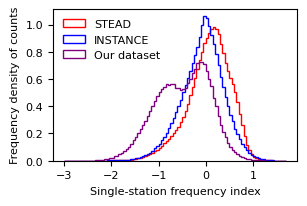

In [195]:
cm = 1 / 2.54
fig, axs = plt.subplots(1, 1, figsize=(8 * cm, 5 * cm), sharex="row", squeeze=False)
up_b = 1.7
lw_b = -3
bins = np.arange(lw_b, up_b + 0.01, 0.05)

fts = 8
plt.subplots_adjust(wspace=0.25, hspace=0.35)
ax = axs[0][0]
freq_indices = stead_metadata["trace_frequency_index"]
print(max(freq_indices))
print(min(freq_indices))
ax.hist(
    freq_indices,
    bins,
    density=True,
    color="white",
    edgecolor="red",
    histtype="step",
    label="STEAD",
)

# ax = axs[0][1]
freq_indices = instance_metadata["trace_frequency_index"]
print(max(freq_indices))
print(min(freq_indices))
ax.hist(
    freq_indices,
    bins,
    density=True,
    color="white",
    edgecolor="blue",
    histtype="step",
    label="INSTANCE",
)

freq_indices = data_eq["trace_frequency_index"]
print(max(freq_indices))
print(min(freq_indices))
ax.hist(
    freq_indices,
    bins,
    density=True,
    color="white",
    edgecolor="purple",
    histtype="step",
    label="Our dataset",
)


ax.tick_params(labelsize=fts)
ax.set_xlabel("Single-station frequency index", fontsize=fts)
ax.set_ylabel("Frequency density of counts", fontsize=fts)
ax.legend(
    fontsize=fts,
    loc="upper left",
    # bbox_to_anchor=(0.0, 1.0, 1, 0.08),
    frameon=False,
    # ncols=2,
)
# ax.grid()

plot

In [8]:
instance_metadata = pd.read_csv("instance_FI.csv")
stead_metadata = pd.read_csv("stead_FI.csv")

In [179]:
len(data_eq)

303088

1.5837200202104442
-5.6913336262750605
0.8052362220173376
-2.107490350317512
1.6273361702316074
-4.667948492281088


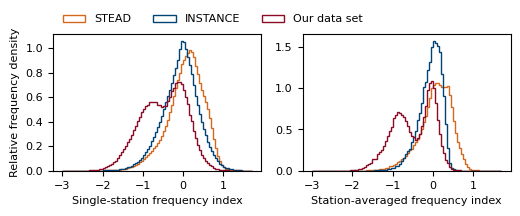

In [9]:
cm = 1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(15 * cm, 4.5 * cm), sharex=True, squeeze=False)
up_b = 1.7
lw_b = -3
bins = np.arange(lw_b, up_b + 0.01, 0.05)

fts = 8
plt.subplots_adjust(wspace=0.2)
ax = axs[0][0]
colors = {"STEAD": "chocolate", "INSTANCE": "#024376", "Our data set": "#880C25"}
# colors = {"STEAD": "teal", "INSTANCE": "dodgerblue", "Our data set": "firebrick"}
for i, (meta, label) in enumerate(
    zip(
        [stead_metadata, instance_metadata, data_eq.metadata],
        ["STEAD", "INSTANCE", "Our data set"],
    )
):
    freq_indices = meta["trace_frequency_index"]
    ax.hist(
        freq_indices,
        bins,
        density=True,
        color="white",
        edgecolor=colors[label],
        histtype="step",
        label=label,
    )
    ax.tick_params(labelsize=fts)
    ax.set_xlabel("Single-station frequency index", fontsize=fts)

ax = axs[0][1]
for i, (meta, label) in enumerate(
    zip(
        [stead_metadata, instance_metadata, data_eq.metadata],
        ["STEAD", "INSTANCE", "Our data set"],
    )
):
    # freq_indices = stead_metadata["trace_frequency_index"]
    # event_freq_indices_df = meta.drop_duplicates(
    #     subset="source_id", keep="first", inplace=False
    # )
    # freq_indices = event_freq_indices_df["source_frequency_index"]
    freq_indices = meta["source_frequency_index"]
    print(max(freq_indices))
    print(min(freq_indices))
    ax.hist(
        freq_indices,
        bins,
        density=True,
        color="white",
        edgecolor=colors[label],
        histtype="step",
        label=label,
    )
    ax.tick_params(labelsize=fts)
    ax.set_xlabel("Station-averaged frequency index", fontsize=fts)

axs[0][0].legend(
    fontsize=fts,
    loc="lower left",
    bbox_to_anchor=(0.0, 1.0, 1, 0.08),
    frameon=False,
    ncols=3,
)
axs[0][0].set_ylabel("Relative frequency density", fontsize=fts)
# ax.grid()
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/stead_instance_FI.pdf",
    dpi=300,
    bbox_inches="tight",
)

1.5837200202104442
-5.6913336262750605
0.8052362220173376
-2.107490350317512
1.6273361702316074
-4.667948492281088


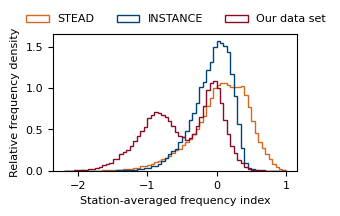

In [13]:
cm = 1 / 2.54
fig, axs = plt.subplots(1, 1, figsize=(8 * cm, 4.5 * cm), sharex=True, squeeze=False)
up_b = 1.0
lw_b = -2.2
bins = np.arange(lw_b, up_b + 0.01, 0.05)

fts = 8
# plt.subplots_adjust(wspace=0.2)
ax = axs[0][0]
for i, (meta, label) in enumerate(
    zip(
        [stead_metadata, instance_metadata, data_eq.metadata],
        ["STEAD", "INSTANCE", "Our data set"],
    )
):
    # # freq_indices = stead_metadata["trace_frequency_index"]
    # event_freq_indices_df = meta.drop_duplicates(
    #     subset="source_id", keep="first", inplace=False
    # )
    # freq_indices = event_freq_indices_df["source_frequency_index"]
    freq_indices = meta["source_frequency_index"]
    print(max(freq_indices))
    print(min(freq_indices))
    ax.hist(
        freq_indices,
        bins,
        density=True,
        color="white",
        edgecolor=colors[label],
        histtype="step",
        label=label,
    )
    ax.tick_params(labelsize=fts)
    ax.set_xlabel("Station-averaged frequency index", fontsize=fts)

axs[0][0].legend(
    fontsize=fts,
    loc="lower left",
    bbox_to_anchor=(-0.15, 1.0, 1, 0.08),
    frameon=False,
    ncols=3,
)
axs[0][0].set_ylabel("Relative frequency density", fontsize=fts)
# ax.grid()
plt.savefig(
    "/home/zhongyiyuan/DATA/my_datasets_seisbench/stead_instance_FI2.pdf",
    dpi=300,
    bbox_inches="tight",
)

# Check overlap with STEAD and INSTANCE dataset

In [142]:
data_stead = sbd.STEAD(component_order="ZNE", dimension_order="NCW", cache="full")
# sampling rate of stead is 100, there is no need to specify sampling rate when initializing

In [152]:
overlap_cascade = data_stead.train().metadata[
    data_stead.train().metadata["source_id"].isin(cascade.metadata["source_id"])
]

In [159]:
overlap_cascade = overlap_cascade[
    overlap_cascade.apply(
        lambda x: f"{x['source_id']}-{x['station_network_code']}-{x['station_code']}",
        axis=1,
    ).isin(
        cascade.metadata.apply(
            lambda x: f"{x['source_id']}-{x['station_network_code']}-{x['station_code']}",
            axis=1,
        )
    )
]

In [160]:
overlap_cascade

,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
236137,236137,TA,A05A,BH,48.99830,-122.085200,174.3,600.0,manual,0.95,...,[17. 18.10000038 16.79999924],[[3199.]],2007-08-12 20:05:07.800000,earthquake_local,"bucket230$35,:3,:6000",train,A05A.TA_20070812200506_EV,,100,ZNE
236153,236153,TA,A05A,BH,48.99830,-122.085200,174.3,700.0,manual,0.95,...,[33.09999847 28.20000076 45.5 ],[[1882.]],2007-12-25 13:12:02.430000,earthquake_local,"bucket230$49,:3,:6000",train,A05A.TA_20071225131201_EV,,100,ZNE
236169,236169,TA,A05A,BH,48.99830,-122.085200,174.3,900.0,manual,0.95,...,[21.70000076 19.70000076 22.89999962],[[2068.]],2008-01-27 12:44:17.180000,earthquake_local,"bucket230$64,:3,:6000",train,A05A.TA_20080127124416_EV,,100,ZNE
267927,267927,CC,ASBU,BH,43.82056,-121.368401,1538.0,700.0,manual,1.00,...,[24.60000038 22. 28.20000076],[[2628.]],2014-04-03 17:41:31.680000,earthquake_local,"bucket261$428,:3,:6000",train,ASBU.CC_20140403174130_EV,,100,ZNE
267928,267928,CC,ASBU,BH,43.82056,-121.368401,1538.0,900.0,manual,0.68,...,[25.60000038 23.20000076 28. ],[[2952.]],2014-09-18 05:48:23.760000,earthquake_local,"bucket261$429,:3,:6000",train,ASBU.CC_20140918054822_EV,,100,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244896,1244896,CC,WIFE,BH,44.05966,-121.817460,1955.0,500.0,manual,0.95,...,[35.79999924 35.29999924 35.09999847],[[1616.]],2005-03-30 00:36:50.160000,earthquake_local,"bucket1214$365,:3,:6000",train,WIFE.CC_20050330003649_EV,,100,ZNE
1244899,1244899,CC,WIFE,BH,44.05966,-121.817460,1955.0,800.0,manual,0.70,...,[16.29999924 22.10000038 19.60000038],[[2544.]],2006-10-04 21:25:57.820000,earthquake_local,"bucket1214$367,:3,:6000",train,WIFE.CC_20061004212556_EV,,100,ZNE
1244903,1244903,CC,WIFE,BH,44.05966,-121.817460,1955.0,800.0,manual,0.95,...,[16.89999962 15.5 11.89999962],[[2520.]],2007-09-18 07:06:20.160000,earthquake_local,"bucket1214$371,:3,:6000",train,WIFE.CC_20070918070619_EV,,100,ZNE
1244908,1244908,CC,WIFE,BH,44.05966,-121.817460,1955.0,600.0,manual,1.00,...,[34.59999847 30.70000076 35.09999847],[[1760.]],2013-06-30 22:54:10.280000,earthquake_local,"bucket1214$375,:3,:6000",train,WIFE.CC_20130630225409_EV,,100,ZNE


In [161]:
cascade.metadata[
    cascade.metadata.apply(
        lambda x: f"{x['source_id']}-{x['station_network_code']}-{x['station_code']}",
        axis=1,
    ).isin(
        overlap_cascade.apply(
            lambda x: f"{x['source_id']}-{x['station_network_code']}-{x['station_code']}",
            axis=1,
        )
    )
]

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_arrival_sample,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,trace_chunk,trace_component_order
259,259,uw10700688,2006-10-04T21:26:03.000000Z,44.1555,-121.7853,5.6,1.50,md,lp,CC,...,6236,NaN,"[5.361750944043662, 13.636353918476225, 0.3849...",6.461033,-1.413098,test,uw10700688_CC.WIFE..BH.mseed,-1.161659,_cascade_lp,ZNE
276,276,uw10725083,2007-08-12T20:05:06.000000Z,48.7427,-121.7655,30.1,1.90,md,lp,TA,...,6755,NaN,"[13.24188984234047, 9.9267733336972, 5.5865521...",9.585072,-1.795462,test,uw10725083_TA.B05A..BH.mseed,-1.317644,_cascade_lp,ZNE
277,277,uw10725083,2007-08-12T20:05:06.000000Z,48.7427,-121.7655,30.1,1.90,md,lp,TA,...,6665,NaN,"[4.296349056912739, 7.270598497304769, 6.41991...",5.995621,-1.332915,test,uw10725083_TA.A05A..BH.mseed,-1.317644,_cascade_lp,ZNE
280,280,uw10727553,2007-08-16T16:11:07.000000Z,46.3182,-122.3218,42.5,0.83,md,lp,TA,...,6781,NaN,"[5.486411148531523, 0.9877661561633084, -0.112...",2.120592,-0.923973,test,uw10727553_TA.E05A..BH.mseed,-0.858835,_cascade_lp,ZNE
339,339,uw60493937,2012-12-06T09:21:32.000000Z,48.7685,-121.8533,35.5,0.84,md,lp,TA,...,6823,NaN,"[-1.2539688284764094, 2.9764891848791724, 0.56...",0.763361,-1.049157,test,uw60493937_TA.B05D..BH.mseed,-0.927408,_cascade_lp,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,647,uw61360506,2017-12-17T11:49:10.000000Z,44.8198,-121.5878,8.5,1.56,ml,local_event,UW,...,6644,NaN,"[13.135684061567243, 13.713590579497343, 11.18...",12.678933,0.264216,test,uw61360506_UW.BLOW..HH.mseed,0.067145,_cascade_vt,ZNE
1461,651,uw61345147,2018-01-27T23:40:50.000000Z,48.6432,-121.7477,3.9,1.35,ml,local_event,UW,...,6305,NaN,"[4.257154900044427, 7.232590190912745, 10.8147...",7.434848,0.535325,test,uw61345147_UW.SHUK..BH.mseed,0.178097,_cascade_vt,ZNE
1463,653,uw61368901,2018-02-13T20:29:53.000000Z,44.3150,-121.5815,14.8,1.22,ml,local_event,UO,...,6786,NaN,"[6.156171460414367, 14.79705871629639, 15.9828...",12.312032,-0.010783,test,uw61368901_UO.RSBO..EH.mseed,0.055369,_cascade_vt,ZNE
1465,655,uw61368901,2018-02-13T20:29:53.000000Z,44.3150,-121.5815,14.8,1.22,ml,local_event,CC,...,6494,NaN,"[7.039624139311958, 7.223791374489651, -5.0874...",3.058662,-0.491254,test,uw61368901_CC.PRLK..BH.mseed,0.055369,_cascade_vt,ZNE


In [6]:
data_stead.metadata["trace_start_time"] = data_stead.metadata["trace_start_time"].apply(
    lambda x: UTCDateTime(x)
)
dataset.metadata["trace_start_time"] = dataset.metadata["trace_start_time"].apply(
    lambda x: UTCDateTime(x)
)

In [63]:
x = data_stead.metadata.iloc[0]

In [7]:
data_stead.get_sample(data_idx)[0].shape[1] / 100

60.0

In [7]:
trace_end_time = []
for i in tqdm(range(len(data_stead))):
    kwargs = {
        "trace_name": data_stead.metadata.iloc[i]["trace_name"],
        "chunk": data_stead.metadata.iloc[i].get("trace_chunk", None),
        "dataset": data_stead.metadata.iloc[i].get("trace_dataset", None),
    }
    data_idx = data_stead.get_idx_from_trace_name(**kwargs)
    time_len = data_stead.get_sample(data_idx)[0].shape[1] / 100
    trace_end_time.append(data_stead.metadata.iloc[i]["trace_start_time"] + time_len)

  0%|          | 0/1265657 [00:00<?, ?it/s]

100%|██████████| 1265657/1265657 [14:32<00:00, 1450.39it/s]


In [9]:
data_stead.metadata["trace_end_time"] = trace_end_time

In [10]:
trace_end_time_vol = []
for i in tqdm(range(len(dataset))):
    kwargs = {
        "trace_name": dataset.metadata.iloc[i]["trace_name"],
        "chunk": dataset.metadata.iloc[i].get("trace_chunk", None),
        "dataset": dataset.metadata.iloc[i].get("trace_dataset", None),
    }
    data_idx = dataset.get_idx_from_trace_name(**kwargs)
    time_len = dataset.get_sample(data_idx)[0].shape[1] / 100
    trace_end_time_vol.append(dataset.metadata.iloc[i]["trace_start_time"] + time_len)

100%|██████████| 323088/323088 [09:42<00:00, 555.08it/s] 


In [62]:
data_stead

In [53]:
overlapped_stations_stead1 = dataset.train().metadata[
    dataset.train()
    .metadata.apply(
        lambda x: f"{x['station_network_code']}-{x['station_code']}", axis=1
    )
    .isin(
        data_stead.test().metadata.apply(
            lambda x: f"{x['station_network_code']}-{x['station_code']}", axis=1
        )
    )
]

In [61]:
overlapped_stations_stead1["trace__time"]

KeyError: 'trace_dataset'

In [ ]:
station_code_last = None
station_network_code_last = None
overlap_records = []
data_stead_test = data_stead.test()
for i in tqdm(range(len(overlapped_stations_stead1))):
    row = overlapped_stations_stead1.iloc[i]
    station_code = row["station_code"]
    station_network_code = row["station_network_code"]
    if (
        station_code != station_code_last
        or station_network_code != station_network_code_last
    ):
        subset = data_stead_test.metadata[
            (data_stead_test.metadata["station_network_code"] == station_network_code)
            & (data_stead_test.metadata["station_code"] == station_code)
        ]
    starttime = row["trace_start_time"]
    x = subset[
        (subset["trace_start_time"] >= starttime - 60)
        & (subset["trace_start_time"] <= starttime + 150)
    ]
    if len(x) > 0:
        overlap_records.append(row.to_dict())

In [45]:
station_code_last = None
station_network_code_last = None
overlap_records = []
for i in tqdm(range(len(overlapped_stations_stead))):
    row = overlapped_stations_stead.iloc[i]
    station_code = row["station_code"]
    station_network_code = row["station_network_code"]
    if (
        station_code != station_code_last
        or station_network_code != station_network_code_last
    ):
        subset = dataset.metadata[
            (dataset.metadata["station_network_code"] == station_network_code)
            & (dataset.metadata["station_code"] == station_code)
        ]
    starttime = row["trace_start_time"]
    x = subset[
        (subset["trace_start_time"] >= starttime - 120)
        & (subset["trace_start_time"] <= starttime + 60)
    ]
    if len(x) > 0:
        overlap_records.append(row.to_dict())

  0%|          | 0/141947 [00:00<?, ?it/s]

100%|██████████| 141947/141947 [1:04:32<00:00, 36.66it/s]


In [49]:
overlap_records = pd.DataFrame(overlap_records)

In [51]:
overlap_records["split"]

0       train
1         dev
2       train
3       train
4        test
        ...  
1017    train
1018    train
1019    train
1020    train
1021    train
Name: split, Length: 1022, dtype: object

In [50]:
len(overlap_records)

1022

In [42]:
min(overlapped_stations_stead["trace_start_time"])

2002-10-23T08:36:05.690000Z

In [40]:
overlapped_stations_stead

,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
14160,14160,AV,ACH,BH,58.210000,-155.32810,960.0,NaN,NaN,NaN,...,NaN,NaN,2017-08-20T07:34:00.000000Z,noise,"bucket12$761,:3,:6000",train,ACH.AV_201708200734_NO,,100,ZNE
14161,14161,AV,ACH,BH,58.210000,-155.32810,960.0,NaN,NaN,NaN,...,NaN,NaN,2017-08-21T01:21:00.000000Z,noise,"bucket12$762,:3,:6000",train,ACH.AV_201708210121_NO,,100,ZNE
14162,14162,AV,ACH,BH,58.210000,-155.32810,960.0,NaN,NaN,NaN,...,NaN,NaN,2017-08-22T13:43:00.000000Z,noise,"bucket12$763,:3,:6000",train,ACH.AV_201708221343_NO,,100,ZNE
14163,14163,AV,ACH,BH,58.210000,-155.32810,960.0,NaN,NaN,NaN,...,NaN,NaN,2017-08-23T14:31:00.000000Z,noise,"bucket12$764,:3,:6000",train,ACH.AV_201708231431_NO,,100,ZNE
14164,14164,AV,ACH,BH,58.210000,-155.32810,960.0,NaN,NaN,NaN,...,NaN,NaN,2017-08-24T05:26:00.000000Z,noise,"bucket19$403,:3,:6000",test,ACH.AV_201708240526_NO,,100,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245800,1245800,HV,WILD,EH,19.466578,-155.58107,4039.0,800.0,manual,0.47,...,[28.20000076 29.20000076 29. ],[[5999.]],2018-10-19T19:52:19.630000Z,earthquake_local,"bucket1215$92,:3,:6000",train,WILD.HV_20181019195219_EV,,100,ZNE
1245801,1245801,HV,WILD,EH,19.466578,-155.58107,4039.0,500.0,manual,0.50,...,[19.60000038 21.60000038 24.60000038],[[3213.]],2018-10-22T10:13:33.310000Z,earthquake_local,"bucket1215$93,:3,:6000",train,WILD.HV_20181022101333_EV,,100,ZNE
1245802,1245802,HV,WILD,EH,19.466578,-155.58107,4039.0,500.0,manual,0.39,...,[40. 40.40000153 36.59999847],[[3799.]],2018-10-23T05:17:44.330000Z,earthquake_local,"bucket1217$699,:3,:6000",test,WILD.HV_20181023051744_EV,,100,ZNE
1245803,1245803,HV,WILD,EH,19.466578,-155.58107,4039.0,800.0,manual,0.48,...,[21. 24.39999962 27. ],[[5999.]],2018-11-21T11:15:08.160000Z,earthquake_local,"bucket1215$94,:3,:6000",train,WILD.HV_20181121111508_EV,,100,ZNE


In [28]:
x = dataset.metadata[
    (dataset.metadata["station_network_code"] == "AV")
    & (dataset.metadata["station_code"] == "ACH")
]
x[x["trace_start_time"] < UTCDateTime("1997-09-23T20:12:01.370000Z")]

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_s_arrival_sample,trace_s_status,trace_snr_db,trace_mean_snr_db,trace_frequency_index,split,trace_name_original,source_frequency_index,trace_chunk,trace_component_order
51947,5,alk61728933,1997-09-23T19:12:01.370000Z,58.224333,-155.1145,2.01,0.8,ml,le,AV,...,6211.0,NaN,"[14.939469125690241, 17.37291403201877, 19.623...",17.312123,-0.207525,train,alk61728933_AV.ACH..EH.mseed,-0.158632,_ak_rg,ZNE


In [12]:
len(
    np.unique(
        overlapped_stations_ste.apply(
            lambda x: (x["station_network_code"], x["station_code"]), axis=1
        )
    )
)

155

In [7]:
overlapped_stations_ste.columns

Index(['index', 'station_network_code', 'station_code', 'trace_channel',
       'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m',
       'trace_p_arrival_sample', 'trace_p_status', 'trace_p_weight',
       'path_p_travel_sec', 'trace_s_arrival_sample', 'trace_s_status',
       'trace_s_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude_deg',
       'source_longitude_deg', 'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'path_back_azimuth_deg', 'trace_snr_db',
       'trace_coda_end_sample', 'trace_start_time', 'trace_category',
       'trace_name', 'split', 'trace_name_original', 'trace_chunk',
       'trace_sampling_rate_hz', 'trace_component_order'],
   

In [ ]:
overlapped_stations_ste[pd.notna(overlapped_stations_ste["source_id"])]

,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
240531,240531,AV,ACH,EH,58.210000,-155.32810,960.0,500.0,manual,0.63,...,[44.40000153 43.40000153 43.5 ],[[1289.]],2010-09-13 02:28:22.336000,earthquake_local,"bucket239$492,:3,:6000",test,ACH.AV_20100913022821_EV,,100,ZNE
240532,240532,AV,ACH,EH,58.210000,-155.32810,960.0,700.0,manual,0.64,...,[33.29999924 32.20000076 27.60000038],[[1313.]],2010-09-13 23:37:15.455000,earthquake_local,"bucket233$683,:3,:6000",train,ACH.AV_20100913233714_EV,,100,ZNE
240533,240533,AV,ACH,EH,58.210000,-155.32810,960.0,900.0,manual,1.00,...,[41.70000076 44.59999847 38.20000076],[[2531.]],2010-09-14 04:58:09.942000,earthquake_local,"bucket233$684,:3,:6000",train,ACH.AV_20100914045808_EV,,100,ZNE
240534,240534,AV,ACH,EH,58.210000,-155.32810,960.0,500.0,manual,0.81,...,[25.10000038 28.10000038 23.89999962],[[2074.]],2010-09-14 05:09:26.156000,earthquake_local,"bucket239$493,:3,:6000",test,ACH.AV_20100914050925_EV,,100,ZNE
240535,240535,AV,ACH,EH,58.210000,-155.32810,960.0,800.0,manual,0.78,...,[20. 19.60000038 14.10000038],[[2333.]],2010-09-14 05:11:45.244000,earthquake_local,"bucket233$685,:3,:6000",train,ACH.AV_20100914051144_EV,,100,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245800,1245800,HV,WILD,EH,19.466578,-155.58107,4039.0,800.0,manual,0.47,...,[28.20000076 29.20000076 29. ],[[5999.]],2018-10-19 19:52:19.630000,earthquake_local,"bucket1215$92,:3,:6000",train,WILD.HV_20181019195219_EV,,100,ZNE
1245801,1245801,HV,WILD,EH,19.466578,-155.58107,4039.0,500.0,manual,0.50,...,[19.60000038 21.60000038 24.60000038],[[3213.]],2018-10-22 10:13:33.310000,earthquake_local,"bucket1215$93,:3,:6000",train,WILD.HV_20181022101333_EV,,100,ZNE
1245802,1245802,HV,WILD,EH,19.466578,-155.58107,4039.0,500.0,manual,0.39,...,[40. 40.40000153 36.59999847],[[3799.]],2018-10-23 05:17:44.330000,earthquake_local,"bucket1217$699,:3,:6000",test,WILD.HV_20181023051744_EV,,100,ZNE
1245803,1245803,HV,WILD,EH,19.466578,-155.58107,4039.0,800.0,manual,0.48,...,[21. 24.39999962 27. ],[[5999.]],2018-11-21 11:15:08.160000,earthquake_local,"bucket1215$94,:3,:6000",train,WILD.HV_20181121111508_EV,,100,ZNE


In [ ]:
data_instance = sbd.InstanceCountsCombined(
    sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="full"
)

In [ ]:
overlapped_stations_ins = data_instance.metadata[
    data_instance.metadata.apply(
        lambda x: f"{x['station_network_code']}-{x['station_code']}", axis=1
    ).isin(
        dataset.metadata.apply(
            lambda x: f"{x['station_network_code']}-{x['station_code']}", axis=1
        )
    )
]

In [ ]:
overlapped_stations_ins

,index,source_id,station_network_code,station_code,station_location_code,station_channels,station_latitude_deg,station_longitude_deg,station_elevation_m,station_vs_30_mps,...,trace_EQT_number_detections,trace_EQT_P_number,trace_EQT_S_number,trace_deconvolved_units,trace_name_original,split,trace_chunk,trace_sampling_rate_hz,trace_component_order,trace_dataset


In [ ]:
overlapped_stations["source_id"]

240531     ak010brexrpj
240532     ak010brrhse4
240533     ak010bt3udka
240534     ak010bt45c0s
240535     ak010bt45t65
               ...     
1245800      hv70662272
1245801      hv70666412
1245802      hv70667462
1245803      hv70698806
1245804      hv70752141
Name: source_id, Length: 125337, dtype: object

In [ ]:
waveforms, metadata = data_eq.get_sample(0)

26.125998545825187
66.30402237472778
0.0
0.0
0.0
0.0
8.089339552166457
([8.089339552166457, nan, nan], 8.089339552166457)


/tmp/ipykernel_502932/569089579.py:13: RuntimeWarning: invalid value encountered in scalar divide
  snrs.append(20*np.log10(np.percentile(np.abs(waveforms[i,int(metadata["trace_s_arrival_sample"]):int(metadata["trace_s_arrival_sample"]+5*metadata["trace_sampling_rate_hz"])]),95)/np.percentile(


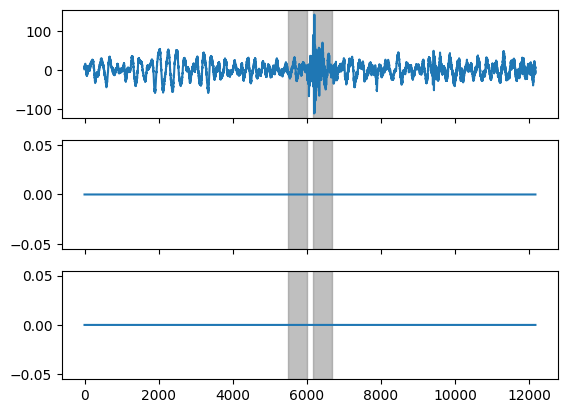

In [ ]:
fig, axs = plt.subplots(3, 1, sharex="all")
snrs = []
for i in range(3):
    ax = axs[i]
    ax.plot(waveforms[i, :].T)
    ax.axvspan(
        metadata["trace_p_arrival_sample"] - 5 * metadata["trace_sampling_rate_hz"],
        metadata["trace_p_arrival_sample"],
        color="gray",
        alpha=0.5,
    )
    ax.axvspan(
        metadata["trace_s_arrival_sample"],
        metadata["trace_s_arrival_sample"] + 5 * metadata["trace_sampling_rate_hz"],
        color="gray",
        alpha=0.5,
    )
    print(
        np.percentile(
            np.abs(
                waveforms[
                    i,
                    int(
                        metadata["trace_p_arrival_sample"]
                        - 5 * metadata["trace_sampling_rate_hz"]
                    ) : int(metadata["trace_p_arrival_sample"]),
                ]
            ),
            95,
        )
    )
    print(
        np.percentile(
            np.abs(
                waveforms[
                    i,
                    int(metadata["trace_s_arrival_sample"]) : int(
                        metadata["trace_s_arrival_sample"]
                        + 5 * metadata["trace_sampling_rate_hz"]
                    ),
                ]
            ),
            95,
        )
    )
    snrs.append(
        20
        * np.log10(
            np.percentile(
                np.abs(
                    waveforms[
                        i,
                        int(metadata["trace_s_arrival_sample"]) : int(
                            metadata["trace_s_arrival_sample"]
                            + 5 * metadata["trace_sampling_rate_hz"]
                        ),
                    ]
                ),
                95,
            )
            / np.percentile(
                np.abs(
                    waveforms[
                        i,
                        int(
                            metadata["trace_p_arrival_sample"]
                            - 5 * metadata["trace_sampling_rate_hz"]
                        ) : int(metadata["trace_p_arrival_sample"]),
                    ]
                ),
                95,
            )
        )
    )
print(np.nanmean(snrs))
print(
    calculate_snr(
        waveforms,
        metadata["trace_p_arrival_sample"],
        metadata["trace_s_arrival_sample"],
        500,
    )
)

In [ ]:
d = {
    "one": [[1.0, 2.0, 3.0], [2.0, np.nan, np.nan], [3.0, 3.0, 3.0], 4.0],
    "two": [4.0, 3.0, 2.0, 1.0],
}
df = pd.DataFrame(d)
df

,one,two
0,"[1.0, 2.0, 3.0]",4.0
1,"[2.0, nan, nan]",3.0
2,"[3.0, 3.0, 3.0]",2.0
3,4.0,1.0


In [ ]:
trace_with_spikes_index = np.flatnonzero(
    dataset.metadata["trace_has_spikes"].to_numpy()
)
print(len(trace_with_spikes_index))

2725


In [ ]:
dataset.filter(~dataset.metadata["trace_has_spikes"], inplace=True)

In [ ]:
ncedc_lp.filter(~ncedc_lp.metadata["trace_has_spikes"], inplace=True)

In [ ]:
dataset_lp = dataset.filter((dataset.metadata["source_type"] == "lp"), inplace=False)
dataset_rg = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    & (dataset.metadata["source_type"] != "noise"),
    inplace=False,
)
dataset_noise = dataset.filter(
    dataset.metadata["source_type"] == "noise", inplace=False
)

print(f"{len(dataset_lp)} lp traces")
print(f"{len(dataset_rg)} regular earthquake traces")
print(f"{len(dataset_noise)} noise traces")

194037 lp traces
194104 regular earthquake traces
200000 noise traces


In [ ]:
source_ids_lp = dataset_lp.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
).to_numpy()
print(f"Number of LP events: {len(source_ids_lp)}")
print(f"Number of LP waveforms: {len(dataset_lp)}")

print(f"Number of LP waveforms in the training set: {len(dataset_lp.train())}")
print(f"Number of LP waveforms in the validation set: {len(dataset_lp.dev())}")
print(f"Number of LP waveforms in the test set: {len(dataset_lp.test())}")

print()
source_ids_rg = dataset_rg.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
).to_numpy()
print(f"Number of regular events: {len(source_ids_rg)}")
print(f"Number of regular waveforms: {len(dataset_rg)}")

print(f"Number of regular waveforms in the training set: {len(dataset_rg.train())}")
print(f"Number of regular waveforms in the validation set: {len(dataset_rg.dev())}")
print(f"Number of regular waveforms in the test set: {len(dataset_rg.test())}")

print()
print(f"Number of noise waveforms: {len(dataset_noise)}")
print(f"Number of noise waveforms in the training set: {len(dataset_noise.train())}")
print(f"Number of noise waveforms in the validation set: {len(dataset_noise.dev())}")
print(f"Number of noise waveforms in the test set: {len(dataset_noise.test())}")

Number of LP events: 48815
Number of LP waveforms: 194037
Number of LP waveforms in the training set: 164967
Number of LP waveforms in the validation set: 9679
Number of LP waveforms in the test set: 19391

Number of regular events: 50405
Number of regular waveforms: 194104
Number of regular waveforms in the training set: 165093
Number of regular waveforms in the validation set: 9678
Number of regular waveforms in the test set: 19333

Number of noise waveforms: 200000
Number of noise waveforms in the training set: 170105
Number of noise waveforms in the validation set: 9951
Number of noise waveforms in the test set: 19944


In [ ]:
alaska = data_eq.filter(
    data_eq.metadata["source_id"].str.contains("alk"), inplace=False
)
hawaii = data_eq.filter(
    data_eq.metadata["source_id"].str[0:6] == "hawaii", inplace=False
)

In [ ]:
alaska.metadata[
    alaska.metadata.apply(
        lambda x: (x["station_network_code"], x["station_code"]), axis=1
    ).isin(
        hawaii.metadata.apply(
            lambda x: (x["station_network_code"], x["station_code"]), axis=1
        )
    )
]

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,...,trace_has_spikes,trace_p_arrival_sample,trace_s_arrival_sample,trace_sampling_rate_hz,trace_frequency_index,source_frequency_index,split,trace_name_original,trace_chunk,trace_component_order


In [ ]:
max([ncedc_lp.get_sample(i)[0].shape[-1] for i in range(len(ncedc_lp))])

13525

In [ ]:
5135 + 5103 + 4313 + 4276 + 1691 + 1662 + 8252 + 8292 + 19944

58668

In [ ]:
print(500165 / 588141)
print(29308 / 588141)
print(58668 / 588141)

0.8504168218165372
0.04983158800355697
0.09975159017990584


In [ ]:
85.04 + 4.98 + 9.98

100.00000000000001

In [ ]:
source_ids_lp = dataset_lp.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
).to_numpy()
print(f"Number of LP events: {len(source_ids_lp)}")
print(f"Number of LP waveforms: {len(dataset_lp)}")

print(f"Number of LP waveforms in the training set: {len(dataset_lp.train())}")
print(f"Number of LP waveforms in the validation set: {len(dataset_lp.dev())}")
print(f"Number of LP waveforms in the test set: {len(dataset_lp.test())}")

print()
source_ids_rg = dataset_rg.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
).to_numpy()
print(f"Number of regular events: {len(source_ids_rg)}")
print(f"Number of regular waveforms: {len(dataset_rg)}")

print(f"Number of regular waveforms in the training set: {len(dataset_rg.train())}")
print(f"Number of regular waveforms in the validation set: {len(dataset_rg.dev())}")
print(f"Number of regular waveforms in the test set: {len(dataset_rg.test())}")

Number of LP events: 32981
Number of LP waveforms: 111452
Number of LP waveforms in the training set: 77979
Number of LP waveforms in the validation set: 11257
Number of LP waveforms in the test set: 22216

Number of regular events: 32195
Number of regular waveforms: 110132
Number of regular waveforms in the training set: 77004
Number of regular waveforms in the validation set: 11125
Number of regular waveforms in the test set: 22003


In [ ]:
data_eq.metadata[
    (abs(data_eq["station_latitude_deg"] - 21.316401) < 1e-1)
    & (data_eq["trace_chunk"].str.contains("_hw"))
].to_csv("HON.csv")

In [ ]:
(data_eq["station_latitude_deg"] - 21.316401) < 1e-2

0         False
1         False
2         False
3         False
4         False
          ...  
315498    False
315499    False
315500    False
315501    False
315502    False
Name: station_latitude_deg, Length: 303088, dtype: bool